# <p style="text-align: center; font-size: 30px;">📊 <b>Statistical ML: Group 10 - XRay Project</b> 📊</p>


## Libraries

In [3]:
import os
import csv
import warnings
import xml.etree.ElementTree as ET
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib as plt
import numpy as np
import torch.nn.functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import ColorJitter, GaussianBlur
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, Subset
import glob
import pickle
import random
import cv2
import torch.nn as nn
import torch.optim as optim
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from tqdm.auto import tqdm
import time
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
import itertools
from functools import partial
import gc
import copy
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
from torchvision.models import resnet50
import math
import torch.nn.init as init
from torchvision.transforms.functional import to_pil_image
import traceback
from itertools import product
from math import sqrt

## Setting-Up & Loading the Data

In [4]:
# Set the environment variable for the VS Code session
os.environ['XRAY_DATA_PATH'] = '/Users/pranavpai/Code/StatsML/Statisitcal_Machine_Learning_Project/XRay'
#
# Use the XRAY_DATA_PATH environment variable
base_path = os.getenv('XRAY_DATA_PATH')

In [ ]:
# Function to convert XML to CSV
def xml_to_csv(xml_folder, output_csv):
    """
    Convert XML annotation files to a CSV file and save it to the specified folder.

    Parameters:
    xml_folder (str): Path to the folder containing XML files.
    output_csv (str): Path where the output CSV file will be saved.

    Returns:
    None: Writes the CSV file to the specified location. If the CSV file exists, exits early and prints a message.
    """
    if os.path.exists(output_csv):
        print(f"{output_csv} already exists. Skipping conversion.")
        return

    with open(output_csv, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        # Write the header row with all the relevant properties
        csvwriter.writerow(['filename', 'width', 'height', 'depth', 'class', 'pose', 'truncated', 'difficult', 'xmin', 'ymin', 'xmax', 'ymax'])

        # Iterate over all XML files in the folder
        for xml_file in os.listdir(xml_folder):
            if xml_file.endswith('.xml'):
                tree = ET.parse(os.path.join(xml_folder, xml_file))
                root = tree.getroot()

                # Extract filename, width, height, and depth
                filename = root.find('filename').text
                size = root.find('size')
                width = int(size.find('width').text)
                height = int(size.find('height').text)
                depth = int(size.find('depth').text)

                # Iterate over all object elements in the XML
                for obj in root.findall('object'):
                    label = obj.find('name').text
                    pose = obj.find('pose').text
                    truncated = int(obj.find('truncated').text)
                    difficult = int(obj.find('difficult').text)
                    bbox = obj.find('bndbox')
                    xmin = int(bbox.find('xmin').text)
                    ymin = int(bbox.find('ymin').text)
                    xmax = int(bbox.find('xmax').text)
                    ymax = int(bbox.find('ymax').text)

                    # Write data to CSV
                    csvwriter.writerow([filename, width, height, depth, label, pose, truncated, difficult, xmin, ymin, xmax, ymax])

    print(f"{output_csv} has been created successfully.")

if base_path is None:
    raise EnvironmentError("Environment variable 'XRAY_DATA_PATH' is not set.")

# Construct paths using the base_path from the environment variable
train_xml_folder = os.path.join(base_path, 'Train', 'Annotations')
test_xml_folder = os.path.join(base_path, 'Test', 'Annotations')

# Output CSV paths
train_output_csv = os.path.join(base_path, 'Train', 'train_annotations.csv')
test_output_csv = os.path.join(base_path, 'Test', 'test_annotations.csv')

# Convert XML to CSV for train and test datasets
xml_to_csv(train_xml_folder, train_output_csv)
xml_to_csv(test_xml_folder, test_output_csv)


In [ ]:
# Load and display stats for Annotation CSV, and return DataFrame
def compute_csv_stats(csv_path, name):
    """
    Load a CSV file, compute basic statistics, and return the data as a DataFrame.

    Parameters:
    csv_path (str): The path to the CSV file containing annotations.
    name (str): Name to use in the printed output for the dataset.

    Returns:
    pd.DataFrame: A DataFrame containing the loaded CSV data with computed stats.
    Returns None if an error occurs while loading the CSV.
    """

    try:
        # Load the CSV into a DataFrame
        df = pd.read_csv(csv_path)

        # Display basic stats
        print(f"--- Stats for {name} ---")
        print(f"Total Rows: {len(df)}")
        print(f"Unique Images: {df['filename'].nunique()}")

        # Show a summary of the dataset (describe numeric fields)
        print("\nSummary Statistics:")
        print(df.describe())

        # Add a blank line after each section for readability
        print("\n" * 3)

        # Return the DataFrame for later use
        return df

    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")
        return None  # Return None if there's an error

# Now you can call the function and store the DataFrames
df_train_annotations = compute_csv_stats(train_output_csv, 'Training Annotations')
df_test_annotations = compute_csv_stats(test_output_csv, 'Testing Annotations')


In [ ]:
# First 5 Rows of the Annotation dataframe (Train)
df_train_annotations.head()

In [ ]:
# First 5 Rows of the Annotation dataframe (Test)
df_test_annotations.head()

In [ ]:
# Function to create a DataFrame for image statistics and display stats using PyTorch
def get_image_dataframe(image_folder, name):
    """
    Create a DataFrame containing image statistics and the actual image tensors for easy access.

    Parameters:
    image_folder (str): The path to the folder containing images.
    name (str): Name to use in the printed output for the dataset.

    Returns:
    pd.DataFrame: A DataFrame containing image filename, width, height, mode, and tensor of images.
    """

    image_stats = []

    # Iterate over all images in the folder
    for image_file in os.listdir(image_folder):
        if image_file.endswith(".jpg"):  # Process only jpg images
            image_path = os.path.join(image_folder, image_file)

            try:
                # Open the image using torchvision
                image = read_image(image_path)  # Loads the image as a tensor (C x H x W)

                # Get image dimensions
                height, width = image.shape[1], image.shape[2]  # (height, width from tensor)

                # Mode isn't as explicit in PyTorch as it is in PIL, so we assume all images are RGB for simplicity
                mode = "RGB" if image.shape[0] == 3 else "Grayscale"

                # Append the image stats along with the actual image tensor
                image_stats.append([image_file, width, height, mode, image])

            except Exception as e:
                print(f"Error processing {image_file}: {e}")

    # Convert the collected image stats into a DataFrame
    df_image_stats = pd.DataFrame(image_stats, columns=['filename', 'width', 'height', 'mode', 'tensor'])

    # Display basic stats
    print(f"--- Stats for {name} ---")
    print(f"Unique Images: {df_image_stats['filename'].nunique()}")

    # Show a summary of image dimensions
    print("\nSummary of Image Dimensions:")
    print(df_image_stats[['width', 'height']].describe())

    # Add a blank line after each section for readability
    print("\n" * 3)

    return df_image_stats

# Define the paths to the image folders
train_image_folder = os.path.join(base_path, 'Train', 'Images')
test_image_folder = os.path.join(base_path, 'Test', 'Images')

# Get DataFrame for train and test images and store the image tensors in the DataFrame
df_train_images = get_image_dataframe(train_image_folder, 'Training Images')
df_test_images = get_image_dataframe(test_image_folder, 'Testing Images')

In [ ]:
# Function to visualize an image tensor
def visualize_image(image_tensor, title="Image"):
    """
    Visualize a tensor image using matplotlib within the given subplot.

    Parameters:
    image_tensor (torch.Tensor): The image tensor to visualize.
    title (str): The title of the image being displayed.
    """
    try:
        # Check if the tensor is grayscale or RGB
        if image_tensor.shape[0] == 3:  # RGB
            # Convert tensor to numpy (C x H x W) -> (H x W x C)
            image_np = image_tensor.permute(1, 2, 0).numpy()
        elif image_tensor.shape[0] == 1:  # Grayscale
            # Squeeze the extra dimension for grayscale
            image_np = image_tensor.squeeze(0).numpy()
            plt.gray()  # Set the colormap to gray for visualization
        else:
            raise ValueError("Unexpected number of channels in the image tensor.")

        # Plot the image in the current axis
        plt.imshow(image_np)
        plt.title(title)
        plt.axis('off')  # Hide axis

    except Exception as e:
        print(f"Error visualizing image: {e}")

# Example: Visualize an image from the training set with a check for valid index
i = 7000  # or any other index

# Ensure 'i' is within bounds
if i < len(df_train_images):
    visualize_image(df_train_images['tensor'][i], title=df_train_images['filename'][i])
else:
    print(f"Index {i} is out of range. The dataset contains {len(df_train_images)} images.")

In [ ]:
def visualize_image_with_bboxes(annotations_df, images_df, filename, ax=None):
    """
    Visualize an image with bounding boxes.

    Parameters:
    - annotations_df (pd.DataFrame): DataFrame containing annotations.
    - images_df (pd.DataFrame): DataFrame containing image tensors and filenames.
    - filename (str): Filename of the image to visualize.
    - ax (matplotlib.axes.Axes, optional): Axes object to plot on.
    """
    # Get all annotations for the specified filename
    annotations = annotations_df[annotations_df['filename'] == filename.replace('_block', '')]

    if annotations.empty:
        print(f"No annotations found for {filename}.")
        if ax is not None:
            ax.axis('off')
        return

    # Get the corresponding image tensor
    image_row = images_df[images_df['filename'] == filename]
    if image_row.empty:
        print(f"Image {filename} not found in images_df.")
        if ax is not None:
            ax.axis('off')
        return
    image_data = image_row['tensor'].values[0]

    # Convert tensor to image (assumes image is in the format of [C, H, W])
    transform = transforms.ToPILImage()
    image = transform(image_data)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the image
    ax.imshow(image)

    # Iterate over all bounding boxes
    for _, row in annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        class_label = row['class']

        # Draw bounding box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Add class label
        ax.text(xmin, ymin, class_label, color='white', fontsize=12,
                 bbox=dict(facecolor='red', alpha=0.5))

    ax.axis('off')
    ax.set_title(filename)




visualize_image_with_bboxes(df_train_annotations, df_train_images, 'P05164.jpg')

In [ ]:
# First 5 Rows of the Image dataframe (Train)
df_train_images.head()

In [ ]:
# First 5 Rows of the Image dataframe (Test)
df_test_images.head()

In [ ]:
# Checking the output of the tensor
df_train_images.iloc[0]['tensor']

In [ ]:
def compute_item_range(df_train_annotations):
    items_per_image = df_train_annotations.groupby('filename').size()
    min_items = items_per_image.min()
    max_items = items_per_image.max()
    item_counts = items_per_image.value_counts().sort_index()

    print(f"Minimum number of items in any image: {min_items}")
    print(f"Maximum number of items in any image: {max_items}")
    print("\nNumber of images at each occlusion level (number of items):")
    for num_items, count in item_counts.items():
        print(f"{num_items} item: {count} image")
    return min_items, max_items, item_counts

min_items, max_items, item_counts = compute_item_range(df_train_annotations)


In [ ]:
visualize_image_with_bboxes(df_train_annotations, df_train_images, 'P00035.jpg')
visualize_image_with_bboxes(df_train_annotations, df_train_images, 'P00800.jpg')
visualize_image_with_bboxes(df_train_annotations, df_train_images, 'P00410.jpg')

## Data Pre-Processing and Feature Generation Steps

### White Space Removal and Resizing

In [1]:
torch_to_np = lambda tse : tse.permute(1, 2, 0).numpy()
np_to_torch = lambda npa : torch.from_numpy(npa).permute(2, 0, 1)

def show_image(pic, convert = False):
  print(f"dtype : {pic.dtype}")
  print(f"Shape : {pic.shape}")
  print(f"Aspect Ratio (h/w) : {round(pic.shape[0]/pic.shape[1], 2)}")
  plt.imshow(pic)
  plt.show()

def remove_white(im, do_vertical = True, do_horizontal = True, v_whiteness_threshold = 80, h_whiteness_threshold = 80, seg_wid = 10, whiteness_tolerance = 33):
  if (do_vertical):
    img_hig = im.shape[0]
    num_of_seg = int(img_hig/seg_wid)
    seg_num, iter, br, all_where = 0, 0, 0, 0
    v_dic = dict(zip([i for i in range(num_of_seg)], [-1 for i in range(num_of_seg)]))
    while (seg_num <= num_of_seg-br+2):
      if (all_where >= img_hig):
        break
      this_seg = im[seg_num*seg_wid:seg_num*seg_wid+seg_wid,:]
      # print(f"VER this_seg = {this_seg.shape}") ###############################
      if (get_whiteness(this_seg, whiteness_tolerance)>v_whiteness_threshold):
        br += 1
        im = np.append(im[:seg_num*seg_wid,:], im[seg_num*seg_wid+seg_wid:,:], 0)
      else:
        v_dic[iter] = iter - br
        seg_num += 1
      iter += 1
      all_where += seg_wid

  # print(f"BEFORE HOR shape of im.shape = {im.shape}")
  if (do_horizontal):
    img_wid = im.shape[1]
    num_of_seg = int(img_wid/seg_wid)
    seg_num, iter, br, all_where = 0, 0, 0, 0
    h_dic = dict(zip([i for i in range(num_of_seg)], [-1 for i in range(num_of_seg)]))
    while (seg_num <= num_of_seg-br+2):
      if (all_where >= img_wid):
        break
      this_seg = im[:,seg_num*seg_wid:seg_num*seg_wid+seg_wid]
      # print(f"HOR this_seg = {this_seg.shape}") ###############################
      if (get_whiteness(this_seg, whiteness_tolerance)>h_whiteness_threshold):
        br += 1
        im = np.append(im[:,:seg_num*seg_wid], im[:,seg_num*seg_wid+seg_wid:], 1)
      else:
        h_dic[iter] = iter - br
        seg_num += 1
      iter += 1
      all_where += seg_wid
  max_val_v_dic = max(v_dic.values())
  for k, v in v_dic.items():
    if (v == 0):
      for i in range(k):
        v_dic[i] = 0
    if (v == max_val_v_dic):
      for i in range(k, len(v_dic)):
        v_dic[i] = max_val_v_dic
  max_val_h_dic = max(h_dic.values())
  for k, v in h_dic.items():
    if (v == 0):
      for i in range(k):
        h_dic[i] = 0
    if (v == max_val_h_dic):
      for i in range(k, len(h_dic)):
        h_dic[i] = max_val_h_dic
    return (seg_wid, h_dic, v_dic, im)

def get_whiteness(im, whiteness_tolerance = 30, mean = (104, 117, 123)):
  mn_np = np.array(mean)
  if isinstance(im, torch.Tensor):
    im = im.numpy()
  im  = im + mn_np
  im = im.reshape((im.shape[0]*im.shape[1],3))
  white_count = 0
  for tup in im:
    if (255-sum(tup)/3 <= whiteness_tolerance):
    # if (sum(tup)/3 <= whiteness_tolerance):
      white_count += 1
  white_per = 100*white_count/len(im)
  # print(f"white_per = {white_per}")
  return round(white_per, 2)

class BaseTransform:
    def __init__(self, resize= (584, 688), rgb_means=(104, 117, 123), transform_ = "medium"):
        self.resize = resize
        self.rgb_means = torch.tensor(rgb_means).view(3, 1, 1)
        self.transform_ = transform_

    def __call__(self, img):
        img = self.resize_image(img)

        if self.transform_ == "light":
            img = img + self.rgb_means
        elif self.transform_ == "dark":
            img = img - self.rgb_means

        return img

    def resize_image(self, img):
        img = F.interpolate(img.unsqueeze(0), size= self.resize, mode='bilinear', align_corners=False).squeeze(0)
        return img

def reflect(old_w, w_max):
    mid_w = w_max//2
    if(mid_w < old_w):
        new_w = old_w - 2*(old_w - mid_w)
    else:
        new_w = old_w + 2*(mid_w - old_w)
    return new_w

def get_nearest_obj(tran_dic, seg_X):
  seg_X = int(seg_X)
  if (tran_dic[seg_X] != -1):
    return seg_X
  bfl = list(tran_dic.keys())[:seg_X]
  bfl = bfl[::-1]
  bf_counter = 0
  bf_seg = -1
  for bf in bfl:
    bf_counter += 1
    if (tran_dic[bf] != -1):
      bf_seg = bf
      break
  if (bf_seg == -1):
    bf_counter = 9999

  afl = list(tran_dic.keys())[seg_X+1:]
  af_counter = 0
  af_seg = -1
  for af in afl:
    af_counter += 1
    if (tran_dic[af] != -1):
      af_seg = af
      break
  if (af_seg == -1):
    af_counter = 9999

  if (bf_counter <= af_counter):
    new_seg = bf_seg
  else:
    new_seg = af_seg
  return new_seg

def rotated_this(old_x, old_y, xmax, ymax):
  new_org_x, new_org_y = (0, xmax)
  return (new_org_x+old_y, new_org_y-old_x)

In [ ]:
this_pic = df_train_images['tensor'][14]
print(this_pic.shape)
show_image(this_pic.permute(1, 2, 0), convert = False)
hld = 99.9
seg_size, h_tran, v_tran, no_whi_np = remove_white(im = this_pic.permute(1, 2, 0), v_whiteness_threshold = hld, h_whiteness_threshold = hld, seg_wid = 1)
print(f"#### white removed no_whi_np.shape = {no_whi_np.shape}")
show_image(no_whi_np)


this_pic = df_train_images['tensor'][15]
print(this_pic.shape)
show_image(this_pic.permute(1, 2, 0), convert = False)
hld = 99.9
seg_size, h_tran, v_tran, no_whi_np = remove_white(im = this_pic.permute(1, 2, 0), v_whiteness_threshold = hld, h_whiteness_threshold = hld, seg_wid = 1)
print(f"#### white removed no_whi_np.shape = {no_whi_np.shape}")
show_image(no_whi_np)

In [ ]:
## RESIZING TEST IMAGES

test_count = len(df_test_images)
image_tensor_list = []
filenames_list = []
object_locations_list = []

for fi in range(test_count):
  ######################################################################################################
  ################################################### ORIGINAL ###################################################
  ######################################################################################################  
  ann_pic = df_test_images['tensor'][fi]
  ann_pic_name = df_test_images['filename'][fi]
  # print(f"{fi}/{test_count} <> {ann_pic_name}")

  # show_image(torch_to_np(ann_pic))
  filenames_list.append(ann_pic_name)



  ######################################################################################################
  ################################################### ORIGINAL WITH BOXES ###################################################
  ######################################################################################################


  # xml_file_path = os.path.join(r"C:\Users\Gaura\OneDrive\Desktop\GAURAV\Unimleb\COMP90051\Statisitcal_Machine_Learning_Project\XRay\Train\Annotations", ann_pic_name[:-4] + ".xml")
  xml_file_path = os.path.join(base_path, 'Test', 'Annotations', ann_pic_name[:-4] + ".xml")

  tree = ET.parse(xml_file_path)
  root = tree.getroot()

  # i = 0
  # obj_id = []
  # for child in root:
  #   if (child.tag == "object"):
  #     obj_id.append(i)
  #   i += 1

  # dim_dic = {}
  # count = 0
  # for i in obj_id:
  #   dim_dic[count] = {}
  #   dim_dic[count]["xmin"] = int(root[i][4][0].text)
  #   dim_dic[count]["ymin"] = int(root[i][4][1].text)
  #   dim_dic[count]["xmax"] = int(root[i][4][2].text)
  #   dim_dic[count]["ymax"] = int(root[i][4][3].text)
  #   dim_dic[count]["name"] = root[i][0].text
  #   count += 1
  # dim_dic

  # boxes = []
  # labels = []
  # for key, value in dim_dic.items():
  #     boxes.append([value['xmin'], value['ymin'], value['xmax'], value['ymax']])
  #     labels.append(value['name'])

  # boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
  # image_with_boxes = draw_bounding_boxes(ann_pic, boxes_tensor, labels=labels, colors="red", width=3)

  # show_image(torch_to_np(image_with_boxes))

  # image_with_boxes_pil = torchvision.transforms.ToPILImage()(image_with_boxes)
  # plt.imshow(image_with_boxes_pil)
  # plt.title("Image with Bounding Boxes")
  # plt.axis("off")  
  # plt.show()


  ######################################################################################################
  ################################################### NO WHITE SPACES ###################################################
  ######################################################################################################

  hld = 99.9
  seg_size, h_tran, v_tran, no_whi_np = remove_white(im = torch_to_np(ann_pic), v_whiteness_threshold = hld, h_whiteness_threshold = hld, seg_wid = 1)
  # show_image(no_whi_np)


  ########## EXTRACTING object location from annotation files ##########
  i = 0
  obj_id = []
  for child in root:
    if (child.tag == "object"):
      obj_id.append(i)
    i += 1

  dim_dic = {}
  count = 0
  for i in obj_id:
    dim_dic[count] = {}
    dim_dic[count]["xmin"] = int(root[i][4][0].text)
    dim_dic[count]["ymin"] = int(root[i][4][1].text)
    dim_dic[count]["xmax"] = int(root[i][4][2].text)
    dim_dic[count]["ymax"] = int(root[i][4][3].text)
    dim_dic[count]["name"] = root[i][0].text
    count += 1

  dim_dic_c = {}
  count = 0
  for i in obj_id:
    dim_dic_c[count] = {}
    dim_dic_c[count]["xmin"] = int(root[i][4][0].text)
    dim_dic_c[count]["ymin"] = int(root[i][4][1].text)
    dim_dic_c[count]["xmax"] = int(root[i][4][2].text)
    dim_dic_c[count]["ymax"] = int(root[i][4][3].text)
    dim_dic_c[count]["name"] = root[i][0].text
    count += 1
  bbox0_list = []
  for bb in dim_dic.values():
    temp = []
    temp.append(bb["ymin"])
    temp.append(bb["xmin"])
    temp.append(bb["ymax"])
    temp.append(bb["xmax"])
    bbox0_list.append(temp)
  bbox0 = np.array(bbox0_list)
  c_bbox = bbox0

  ######################################################################################################
  ################################################### Objects location after Removing white space ###################################################
  ##################################################################################################


  w_bbox = []
  for box in c_bbox: 
    temp_box = []
    y_min = box[0]
    x_min = box[1]
    y_max = box[2]
    x_max = box[3]
    y_min_seg = y_min//seg_size
    x_min_seg = x_min//seg_size  
    y_max_seg = y_max//seg_size
    x_max_seg = x_max//seg_size

    # y_min_seg = y_min//seg_size
    # x_min_seg = x_min//seg_size  
    # y_max_seg = y_max//seg_size
    # x_max_seg = x_max//seg_size

    if (x_min_seg <= 0):
      x_min_seg = min(h_tran.keys())
    if (y_min_seg <= 0):
      y_min_seg = min(v_tran.keys())
    if (x_max_seg >= len(h_tran)):
      x_max_seg = max(h_tran.keys())
    if (y_max_seg >= len(v_tran)):
      y_max_seg = max(v_tran.keys())

    if (v_tran[y_min_seg] == -1):
      y_min_seg = get_nearest_obj(tran_dic = v_tran, seg_X = y_min_seg)
    if (h_tran[x_min_seg] == -1):
      x_min_seg = get_nearest_obj(tran_dic = h_tran, seg_X = x_min_seg)
    if (v_tran[y_max_seg] == -1):
      y_max_seg = get_nearest_obj(tran_dic = v_tran, seg_X = y_max_seg)
    if (h_tran[x_max_seg] == -1):
      x_max_seg = get_nearest_obj(tran_dic = h_tran, seg_X = x_max_seg)

    w_y_min = seg_size*v_tran[y_min_seg] + y_min%seg_size
    w_x_min = seg_size*h_tran[x_min_seg] + x_min%seg_size
    w_y_max = seg_size*v_tran[y_max_seg] + y_max%seg_size
    w_x_max = seg_size*h_tran[x_max_seg] + x_max%seg_size

    temp_box.append(w_y_min)
    temp_box.append(w_x_min)
    temp_box.append(w_y_max)
    temp_box.append(w_x_max)
    w_bbox.append(temp_box)

  # boxes = []
  labels = []
  for key, value in dim_dic.items():
      # boxes.append([value['xmin'], value['ymin'], value['xmax'], value['ymax']])
      labels.append(value['name'])

  rot_c_bbox = []
  for box in w_bbox:
      rot_x1, rot_y1 = rotated_this(old_x = box[1], old_y =box[0], xmax=no_whi_np.shape[1], ymax=no_whi_np.shape[0])
      rot_x2, rot_y2 = rotated_this(old_x = box[3], old_y =box[2], xmax=no_whi_np.shape[1], ymax=no_whi_np.shape[0])
      rot_c_bbox.append([ rot_y2, rot_x1, rot_y1, rot_x2])
  W_boxes = [[int(x) for x in row] for row in rot_c_bbox]


  h_max, w_max, _ = no_whi_np.shape
  res = []
  for bx in W_boxes:
      wmin_, hmin_, wmax_, hmax_ = bx[0], bx[1], bx[2], bx[3],
      this_box_X = [reflect(old_w = wmax_, w_max = w_max),  hmin_, reflect(old_w = wmin_, w_max = w_max),  hmax_]
      res.append(this_box_X)

  W_boxes = res

  # boxes_tensor = torch.tensor(W_boxes, dtype=torch.float32)
  # image_with_boxes = draw_bounding_boxes(np_to_torch(no_whi_np), boxes_tensor, labels=labels, colors="red", width=3)
  # show_image(torch_to_np(image_with_boxes))

  ######################################################################################################
  ################################################### Resizing to 584 x 688 ###################################################
  ##################################################################################################

  # transform = BaseTransform(transform_= "light")
  transform = BaseTransform(transform_= "medium")
  # transform = BaseTransform(transform_= "dark")
  transformed_pic = transform(np_to_torch(no_whi_np))

  transformed_pic_np = torch_to_np(transformed_pic)
  Hratio = transformed_pic_np.shape[1]/no_whi_np.shape[1]
  Wratio = transformed_pic_np.shape[0]/no_whi_np.shape[0]

  ratioLst = [Hratio, Wratio, Hratio, Wratio]
  w_bbox_r = []
  for box in W_boxes:
      box = [abs(int(a * b)) for a, b in zip(box, ratioLst)] 
      w_bbox_r.append(box)
  
  final_obj_location_dict = {}
  for label_index in range(len(labels)):
    final_obj_location_dict[label_index] = [labels[label_index], w_bbox_r[label_index]]

  image_tensor_list.append(transformed_pic)
  object_locations_list.append(final_obj_location_dict)
  print(f"{fi}/{test_count} <> {ann_pic_name} <> final_obj_location_dict = {final_obj_location_dict}")
  # boxes_tensor = torch.tensor(w_bbox_r, dtype=torch.float32)
  # resized_image_with_boxes = draw_bounding_boxes(transformed_pic, boxes_tensor, labels=labels, colors="red", width=3)
  # show_image(torch_to_np(resized_image_with_boxes), convert = False)

In [ ]:
###RESIZING TRAIN IMAGES

train_count = len(df_train_images)
image_tensor_list = []
filenames_list = []
object_locations_list = []

for fi in range(train_count):
  ######################################################################################################
  ################################################### ORIGINAL ###################################################
  ######################################################################################################  
  ann_pic = df_train_images['tensor'][fi]
  ann_pic_name = df_train_images['filename'][fi]
  # print(f"{fi}/{train_count} <> {ann_pic_name}")

  # show_image(torch_to_np(ann_pic))
  filenames_list.append(ann_pic_name)



  ######################################################################################################
  ################################################### ORIGINAL WITH BOXES ###################################################
  ######################################################################################################


  # xml_file_path = os.path.join(r"C:\Users\Gaura\OneDrive\Desktop\GAURAV\Unimleb\COMP90051\Statisitcal_Machine_Learning_Project\XRay\Train\Annotations", ann_pic_name[:-4] + ".xml")
  xml_file_path = os.path.join(base_path, 'Train', 'Annotations', ann_pic_name[:-4] + ".xml")

  tree = ET.parse(xml_file_path)
  root = tree.getroot()

  # i = 0
  # obj_id = []
  # for child in root:
  #   if (child.tag == "object"):
  #     obj_id.append(i)
  #   i += 1

  # dim_dic = {}
  # count = 0
  # for i in obj_id:
  #   dim_dic[count] = {}
  #   dim_dic[count]["xmin"] = int(root[i][4][0].text)
  #   dim_dic[count]["ymin"] = int(root[i][4][1].text)
  #   dim_dic[count]["xmax"] = int(root[i][4][2].text)
  #   dim_dic[count]["ymax"] = int(root[i][4][3].text)
  #   dim_dic[count]["name"] = root[i][0].text
  #   count += 1
  # dim_dic

  # boxes = []
  # labels = []
  # for key, value in dim_dic.items():
  #     boxes.append([value['xmin'], value['ymin'], value['xmax'], value['ymax']])
  #     labels.append(value['name'])

  # boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
  # image_with_boxes = draw_bounding_boxes(ann_pic, boxes_tensor, labels=labels, colors="red", width=3)

  # show_image(torch_to_np(image_with_boxes))

  # image_with_boxes_pil = torchvision.transforms.ToPILImage()(image_with_boxes)
  # plt.imshow(image_with_boxes_pil)
  # plt.title("Image with Bounding Boxes")
  # plt.axis("off")  
  # plt.show()


  ######################################################################################################
  ################################################### NO WHITE SPACES ###################################################
  ######################################################################################################

  hld = 99.9
  seg_size, h_tran, v_tran, no_whi_np = remove_white(im = torch_to_np(ann_pic), v_whiteness_threshold = hld, h_whiteness_threshold = hld, seg_wid = 1)
  # show_image(no_whi_np)


  ########## EXTRACTING object location from annotation files ##########
  i = 0
  obj_id = []
  for child in root:
    if (child.tag == "object"):
      obj_id.append(i)
    i += 1

  dim_dic = {}
  count = 0
  for i in obj_id:
    dim_dic[count] = {}
    dim_dic[count]["xmin"] = int(root[i][4][0].text)
    dim_dic[count]["ymin"] = int(root[i][4][1].text)
    dim_dic[count]["xmax"] = int(root[i][4][2].text)
    dim_dic[count]["ymax"] = int(root[i][4][3].text)
    dim_dic[count]["name"] = root[i][0].text
    count += 1

  dim_dic_c = {}
  count = 0
  for i in obj_id:
    dim_dic_c[count] = {}
    dim_dic_c[count]["xmin"] = int(root[i][4][0].text)
    dim_dic_c[count]["ymin"] = int(root[i][4][1].text)
    dim_dic_c[count]["xmax"] = int(root[i][4][2].text)
    dim_dic_c[count]["ymax"] = int(root[i][4][3].text)
    dim_dic_c[count]["name"] = root[i][0].text
    count += 1
  bbox0_list = []
  for bb in dim_dic.values():
    temp = []
    temp.append(bb["ymin"])
    temp.append(bb["xmin"])
    temp.append(bb["ymax"])
    temp.append(bb["xmax"])
    bbox0_list.append(temp)
  bbox0 = np.array(bbox0_list)
  c_bbox = bbox0

  ######################################################################################################
  ################################################### Objects location after Removing white space ###################################################
  ##################################################################################################


  w_bbox = []
  for box in c_bbox: 
    temp_box = []
    y_min = box[0]
    x_min = box[1]
    y_max = box[2]
    x_max = box[3]
    y_min_seg = y_min//seg_size
    x_min_seg = x_min//seg_size  
    y_max_seg = y_max//seg_size
    x_max_seg = x_max//seg_size

    # y_min_seg = y_min//seg_size
    # x_min_seg = x_min//seg_size  
    # y_max_seg = y_max//seg_size
    # x_max_seg = x_max//seg_size

    if (x_min_seg <= 0):
      x_min_seg = min(h_tran.keys())
    if (y_min_seg <= 0):
      y_min_seg = min(v_tran.keys())
    if (x_max_seg >= len(h_tran)):
      x_max_seg = max(h_tran.keys())
    if (y_max_seg >= len(v_tran)):
      y_max_seg = max(v_tran.keys())

    if (v_tran[y_min_seg] == -1):
      y_min_seg = get_nearest_obj(tran_dic = v_tran, seg_X = y_min_seg)
    if (h_tran[x_min_seg] == -1):
      x_min_seg = get_nearest_obj(tran_dic = h_tran, seg_X = x_min_seg)
    if (v_tran[y_max_seg] == -1):
      y_max_seg = get_nearest_obj(tran_dic = v_tran, seg_X = y_max_seg)
    if (h_tran[x_max_seg] == -1):
      x_max_seg = get_nearest_obj(tran_dic = h_tran, seg_X = x_max_seg)

    w_y_min = seg_size*v_tran[y_min_seg] + y_min%seg_size
    w_x_min = seg_size*h_tran[x_min_seg] + x_min%seg_size
    w_y_max = seg_size*v_tran[y_max_seg] + y_max%seg_size
    w_x_max = seg_size*h_tran[x_max_seg] + x_max%seg_size

    temp_box.append(w_y_min)
    temp_box.append(w_x_min)
    temp_box.append(w_y_max)
    temp_box.append(w_x_max)
    w_bbox.append(temp_box)

  # boxes = []
  labels = []
  for key, value in dim_dic.items():
      # boxes.append([value['xmin'], value['ymin'], value['xmax'], value['ymax']])
      labels.append(value['name'])

  rot_c_bbox = []
  for box in w_bbox:
      rot_x1, rot_y1 = rotated_this(old_x = box[1], old_y =box[0], xmax=no_whi_np.shape[1], ymax=no_whi_np.shape[0])
      rot_x2, rot_y2 = rotated_this(old_x = box[3], old_y =box[2], xmax=no_whi_np.shape[1], ymax=no_whi_np.shape[0])
      rot_c_bbox.append([ rot_y2, rot_x1, rot_y1, rot_x2])
  W_boxes = [[int(x) for x in row] for row in rot_c_bbox]


  h_max, w_max, _ = no_whi_np.shape
  res = []
  for bx in W_boxes:
      wmin_, hmin_, wmax_, hmax_ = bx[0], bx[1], bx[2], bx[3],
      this_box_X = [reflect(old_w = wmax_, w_max = w_max),  hmin_, reflect(old_w = wmin_, w_max = w_max),  hmax_]
      res.append(this_box_X)

  W_boxes = res

  # boxes_tensor = torch.tensor(W_boxes, dtype=torch.float32)
  # image_with_boxes = draw_bounding_boxes(np_to_torch(no_whi_np), boxes_tensor, labels=labels, colors="red", width=3)
  # show_image(torch_to_np(image_with_boxes))

  ######################################################################################################
  ################################################### Resizing to 584 x 688 ###################################################
  ##################################################################################################

  # transform = BaseTransform(transform_= "light")
  transform = BaseTransform(transform_= "medium")
  # transform = BaseTransform(transform_= "dark")
  transformed_pic = transform(np_to_torch(no_whi_np))

  transformed_pic_np = torch_to_np(transformed_pic)
  Hratio = transformed_pic_np.shape[1]/no_whi_np.shape[1]
  Wratio = transformed_pic_np.shape[0]/no_whi_np.shape[0]

  ratioLst = [Hratio, Wratio, Hratio, Wratio]
  w_bbox_r = []
  for box in W_boxes:
      box = [abs(int(a * b)) for a, b in zip(box, ratioLst)] 
      w_bbox_r.append(box)
  
  final_obj_location_dict = {}
  for label_index in range(len(labels)):
    final_obj_location_dict[label_index] = [labels[label_index], w_bbox_r[label_index]]

  image_tensor_list.append(transformed_pic)
  object_locations_list.append(final_obj_location_dict)
  print(f"{fi}/{train_count} <> {ann_pic_name} <> final_obj_location_dict = {final_obj_location_dict}")
  # boxes_tensor = torch.tensor(w_bbox_r, dtype=torch.float32)
  # resized_image_with_boxes = draw_bounding_boxes(transformed_pic, boxes_tensor, labels=labels, colors="red", width=3)
  # show_image(torch_to_np(resized_image_with_boxes), convert = False)

In [18]:
# # Saving files in pickle

# data = {
#     "file_names": image_tensor_list,
#     "object_locations": object_locations_list,
#     "images": image_tensor_list
# }

# with open('data.pkl', 'wb') as f:
#     pickle.dump(data, f)

# print("Data saved to pickle file.")

### Loading the Resized Images (pkl file) and Updating our dataframe (TRAINING & TESTING DATA)

In [19]:
def load_pickle_file(base_path, file_name):
    # Create the full path to the pickle file
    pickle_file_path = os.path.join(base_path, file_name)

    # Open the pickle file and load the data
    with open(pickle_file_path, 'rb') as file:
        data = pickle.load(file)

    # Print the keys of the loaded pickle data for reference
    print(f"Keys in {file_name}: {data.keys()}")

    # Return the loaded data
    return data

In [20]:
def extract_pickle_data(data):
    # Extract filenames, resized images, and object locations from the loaded data
    filenames = data['file_names']
    resized_images = data['images']
    object_location = data['object_locations']

    # Return the extracted data
    return filenames, resized_images, object_location

In [21]:
# Function to update either training or testing image DataFrame
def update_image_dataframe(df_images, filenames, resized_images, fixed_width=688, fixed_height=584):
    # Loop through each filename in the list to update the corresponding image tensor
    for i, filename in enumerate(filenames):
        # Find the row in df_images for the current filename
        image_row_idx = df_images.index[df_images['filename'] == filename]

        # Ensure the filename exists in the DataFrame before updating
        if not image_row_idx.empty:
            # Get the corresponding resized tensor
            resized_tensor = resized_images[i]

            # Check if the resized image is a tensor before updating the dataframe
            if isinstance(resized_tensor, torch.Tensor):
                df_images.at[image_row_idx[0], 'tensor'] = resized_tensor
                # Set the fixed width and height values for the image
                df_images.at[image_row_idx[0], 'width'] = int(fixed_width)
                df_images.at[image_row_idx[0], 'height'] = int(fixed_height)
            else:
                # Log a message if the resized image is not a tensor
                print(f"Resized image for {filename} is not a tensor.")
        else:
            # Log a message if the filename is not found in df_images
            print(f"File {filename} not found in df_images.")

    # Return the updated DataFrame
    return df_images

In [22]:
# Function to update either training or testing annotation DataFrame
def update_annotation_dataframe(df_annotations, filenames, object_location, fixed_width=688, fixed_height=584):
    # Loop through each image filename and its corresponding bounding boxes
    for filename, bbox_dict in zip(filenames, object_location):
        # Ensure the filename exists in df_annotations
        if filename in df_annotations['filename'].values:
            # Initialize a counter to track the number of bounding boxes processed for each class
            class_counter = {}

            # Loop through the bounding boxes and update coordinates for the current image
            for bbox_index, (class_label, bbox_coords) in bbox_dict.items():
                # Find all rows in df_annotations matching the filename and class label
                matching_rows = df_annotations[(df_annotations['filename'] == filename) &
                                               (df_annotations['class'] == class_label)]

                # Ensure there are rows to update for the current class and filename
                if not matching_rows.empty:
                    # Initialize or increment the counter for the current class label
                    if class_label not in class_counter:
                        class_counter[class_label] = 0
                    current_idx = class_counter[class_label]

                    # Ensure we have enough rows for the number of bounding boxes
                    if current_idx < len(matching_rows):
                        # Get the index of the row to update and update the bounding box coordinates
                        row_to_update = matching_rows.index[current_idx]
                        df_annotations.loc[row_to_update, ['xmin', 'ymin', 'xmax', 'ymax']] = bbox_coords

                        # Increment the class counter
                        class_counter[class_label] += 1

                        # Update the height and width for the image in the annotation dataframe
                        df_annotations.loc[df_annotations['filename'] == filename, 'height'] = int(fixed_height)
                        df_annotations.loc[df_annotations['filename'] == filename, 'width'] = int(fixed_width)
                    else:
                        # Log a warning if there are more bounding boxes than entries for a class
                        print(f"Warning: More bounding boxes than entries for class '{class_label}' in {filename}.")
                else:
                    # Log a message if no matching rows are found for the class and filename
                    print(f"No matching class '{class_label}' found in {filename}.")

    # Return the updated annotation DataFrame
    return df_annotations

In [ ]:
# Load the pickle data
data_train = load_pickle_file(base_path, 'WSR_train_data.pkl')
data_test = data = load_pickle_file(base_path, 'WSR_test_data.pkl')

In [24]:
# Extract necessary fields
train_filenames, train_resized_images, train_object_location = extract_pickle_data(data_train)
test_filenames, test_resized_images, test_object_location = extract_pickle_data(data_test)

In [ ]:
print(data_test.keys())

In [ ]:
print(data_test['images'])

In [ ]:
# Check the structure of object_locations
for i, (filename, bbox_dict) in enumerate(zip(train_filenames, train_object_location)):
    print(f"Image: {filename}")
    print("Bounding boxes:")
    print(bbox_dict)
    print("-" * 40)


    if i >= 5:
        break


In [ ]:
# Check the structure of object_locations
for i, (filename, bbox_dict) in enumerate(zip(test_filenames, test_object_location)):
    print(f"Image: {filename}")
    print("Bounding boxes:")
    print(bbox_dict)
    print("-" * 40)


    if i >= 5:
        break

In [29]:
# Update the image dataframe
df_train_images = update_image_dataframe(df_train_images, train_filenames, train_resized_images)
df_test_images = update_image_dataframe(df_test_images, test_filenames, test_resized_images)


In [30]:
# Update the annotation dataframe
df_train_annotations = update_annotation_dataframe(df_train_annotations, train_filenames, train_object_location)
df_test_annotations = update_annotation_dataframe(df_test_annotations, test_filenames, test_object_location)


In [ ]:
# Df check for resized annotaions
df_train_annotations[df_train_annotations['filename'] == 'P00002.jpg']

In [ ]:
# Df check for resized image
df_train_images[df_train_images['filename'] == 'P00002.jpg']

In [ ]:
# Image check with new BoundingBox
visualize_image_with_bboxes(df_train_annotations, df_train_images, 'P00002.jpg')

In [ ]:
# Checking the updated df of training images
df_train_images.head()

In [ ]:
# Checking the updated df of training annotations
df_train_annotations.head()

In [ ]:
df_train_annotations.describe()

In [ ]:
df_test_annotations.describe()

In [ ]:
df_test_images.describe()

In [ ]:
df_test_annotations.head()

In [ ]:
df_test_images.head()

### Taking a subset due to limited GPU memory

In [ ]:
# TRAIN SET (Our subest is 1% of the train dataset)

# Set seed for reproducibility
random_seed = 42
random.seed(random_seed)

# Calculate the number of images to select (1% of total)
num_images_to_select = int(0.01 * len(df_train_images))

# Randomly select 30% of the images
selected_filenames = random.sample(list(df_train_images['filename']), num_images_to_select)

# Filter df_test_images to keep only the selected images
df_train_images = df_train_images[df_train_images['filename'].isin(selected_filenames)].reset_index(drop=True)

# Filter df_test_annotations to keep only annotations matching the selected images
df_train_annotations = df_train_annotations[df_train_annotations['filename'].isin(selected_filenames)].reset_index(drop=True)

# Print the resulting dataframes to verify
print(f"Number of selected images: {len(df_train_images)}")
print(f"Number of corresponding annotations: {len(df_train_annotations)}")

# Display first few records to verify
print(df_train_images.head())
print(df_train_annotations.head())


In [ ]:
# TEST SET (Our subest is 7% of the test dataset)

# Set seed for reproducibility
random_seed = 42
random.seed(random_seed)

# Calculate the number of images to select (10% of total)
num_images_to_select = int(0.07 * len(df_test_images))

# Randomly select 30% of the images
selected_filenames = random.sample(list(df_test_images['filename']), num_images_to_select)

# Filter df_test_images to keep only the selected images
df_test_images = df_test_images[df_test_images['filename'].isin(selected_filenames)].reset_index(drop=True)

# Filter df_test_annotations to keep only annotations matching the selected images
df_test_annotations = df_test_annotations[df_test_annotations['filename'].isin(selected_filenames)].reset_index(drop=True)

# Print the resulting dataframes to verify
print(f"Number of selected images: {len(df_test_images)}")
print(f"Number of corresponding annotations: {len(df_test_annotations)}")

# Display first few records to verify
print(df_test_images.head())
print(df_test_annotations.head())


### Adding ColourJitter'd images to the dataset for generalizibility (10 Added Transformations)

In [ ]:
# Use this to add 1000 ColorJitter transformations to the dataset
def apply_color_jitter_augmentation(df_train_images, df_train_annotations):
    """
    Applies ColorJitter transformations to 1000 random images from the training dataset.
    If the augmentation has already been performed, the function will output a message and some samples.
    
    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image data and tensors.
    - df_train_annotations (pd.DataFrame): DataFrame containing annotations for images.
    
    Returns:
    - df_train_images (pd.DataFrame): Updated DataFrame with augmented images added.
    - df_train_annotations (pd.DataFrame): Updated DataFrame with annotations for augmented images added.
    """
    # Check if augmentation has already been performed by looking for filenames ending with '_jit.jpg'
    augmented_filenames = df_train_images[df_train_images['filename'].str.contains('_jit.jpg')]
    
    if not augmented_filenames.empty:
        print("ColorJitter augmentation has already been implemented.")
        # Optionally, display some of the already augmented images
        display_jittered_images(df_train_images)
        return df_train_images, df_train_annotations
    
    else:
        print("Starting ColorJitter augmentation...")
        
        # Step 1: Select 1000 Random Images from the Training Dataset
        # Get unique filenames from the DataFrame
        unique_filenames = df_train_images['filename'].unique()
        
        if len(unique_filenames) < 10:
            num_images = len(unique_filenames)
            print(f"Only {num_images} unique images available. Selecting all of them.")
        else:
            num_images = 10
        
        np.random.seed(47) # Set Seed for reproducibility
        
        random_filenames = np.random.choice(unique_filenames, size=num_images, replace=False)
        
        # Filter the DataFrame to get the selected images
        selected_images_df = df_train_images[df_train_images['filename'].isin(random_filenames)].copy()
        
        # Step 2: Apply ColorJitter Transformations
        # Define the ColorJitter transformation
        color_jitter = ColorJitter(brightness=(0.8, 2),
                                   contrast=(0.8, 2),
                                   saturation=(0.8, 2),
                                   hue=(-0.1, 0.1))
        
        augmented_images = []
        augmented_annotations = []
        
        for idx, row in selected_images_df.iterrows():
            original_filename = row['filename']
            tensor = row['tensor']
            
            # Apply ColorJitter transformation
            transformed_tensor = color_jitter(tensor)
            
            # Create a new filename by appending '_jit.jpg'
            new_filename = original_filename.replace('.jpg', '_jit.jpg')
            
            # Update the image data
            new_row = row.copy()
            new_row['filename'] = new_filename
            new_row['tensor'] = transformed_tensor
            augmented_images.append(new_row)
            
            # Step 3: Add the Transformed Images Back to the Dataset
            # The annotations remain the same except for the filename
            annotations = df_train_annotations[df_train_annotations['filename'] == original_filename].copy()
            annotations['filename'] = new_filename
            augmented_annotations.append(annotations)
        
        # Convert the list of augmented images and annotations to DataFrames
        augmented_images_df = pd.DataFrame(augmented_images)
        augmented_annotations_df = pd.concat(augmented_annotations, ignore_index=True)
        
        # Add the augmented images and annotations to the original DataFrames
        df_train_images = pd.concat([df_train_images, augmented_images_df], ignore_index=True)
        df_train_annotations = pd.concat([df_train_annotations, augmented_annotations_df], ignore_index=True)
        
        print("ColorJitter augmentation completed.")
        print("Here are some examples of how it looks:")
        
        # Step 4: Output a Few Transformed Images
        display_jittered_images(df_train_images, original_filenames=random_filenames)
        
        return df_train_images, df_train_annotations

def display_jittered_images(df_train_images, original_filenames=None, num_examples=5):
    """
    Displays a comparison between original and augmented images.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image data and tensors.
    - original_filenames (list): List of original filenames to display. If None, selects the first few non-augmented examples.
    - num_examples (int): Number of examples to display.
    """
    displayed_count = 0  # To track how many examples we've displayed

    if original_filenames is None or len(original_filenames) == 0:
        print("Here are some examples of how it looks:")
        # Get unique original filenames (without '_jit.jpg')
        original_filenames = df_train_images[~df_train_images['filename'].str.contains('_jit.jpg')]['filename'].unique()

        if len(original_filenames) == 0:
            print("No image found.")
            return

    for filename in original_filenames:
        # Get original image tensor
        original_image_row = df_train_images[df_train_images['filename'] == filename]
        if original_image_row.empty:
            continue
        original_tensor = original_image_row.iloc[0]['tensor']

        # Get augmented image tensor
        augmented_filename = filename.replace('.jpg', '_jit.jpg')
        augmented_image_row = df_train_images[df_train_images['filename'] == augmented_filename]
        if augmented_image_row.empty:
            continue  # Skip if there's no corresponding augmented image

        augmented_tensor = augmented_image_row.iloc[0]['tensor']

        # Create a figure with two subplots for side-by-side comparison
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Use visualize_image directly inside each subplot
        plt.sca(axs[0])
        visualize_image(original_tensor, title=f"Original: {filename}")

        plt.sca(axs[1])
        visualize_image(augmented_tensor, title=f"Augmented: {augmented_filename}")

        # Display the images
        plt.tight_layout()
        plt.show()

        displayed_count += 1
        if displayed_count >= num_examples:
            break  # Stop once we've displayed the requested number of examples



df_train_images, df_train_annotations = apply_color_jitter_augmentation(df_train_images, df_train_annotations)

In [ ]:
# Check for the number of added annotations
df_train_annotations.describe()

In [ ]:
# Check for the number of added images
df_train_images.describe()

In [ ]:
# Df image Check for _jit.jpg
df_train_images[df_train_images['filename'] == 'P03803_jit.jpg']

In [ ]:
# Df check for OG image of _jit.jpg
df_train_images[df_train_images['filename'] == 'P03803.jpg']

In [ ]:
# Df annotation check of _jit.jpg
df_train_annotations[df_train_annotations['filename'] == 'P03803_jit.jpg']

In [ ]:
# Df Check OG annotation for _jit.jpg
df_train_annotations[df_train_annotations['filename'] == 'P03803.jpg']

In [ ]:
# Visualising a ColourJittered Image of with Bounding Boxes
visualize_image_with_bboxes(df_train_annotations, df_train_images, 'P03803_jit.jpg')

### Adding Gaussian Blur images to the dataset for generalizibility (10 Added Transformations)

In [ ]:
def apply_gaussian_blur_augmentation(df_train_images, df_train_annotations):
    """
    Applies Gaussian blur augmentation to 500 random images from the training dataset.
    If the augmentation has already been performed, the function will output a message and exit.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image data and tensors.
    - df_train_annotations (pd.DataFrame): DataFrame containing annotations for images.

    Returns:
    - df_train_images (pd.DataFrame): Updated DataFrame with augmented images added.
    - df_train_annotations (pd.DataFrame): Updated DataFrame with annotations for augmented images added.
    """
    np.random.seed(48) # Set Seed for reproducibility
    
    # Check if augmentation has already been performed by looking for filenames ending with '_blur.jpg'
    augmented_filenames = df_train_images[df_train_images['filename'].str.contains('_blur.jpg')]

    if not augmented_filenames.empty:
        print("Gaussian blur augmentation has already been implemented.")
        # Optionally, display some of the already augmented images
        display_gaussian_blur_augmented_images(df_train_images)
        return df_train_images, df_train_annotations
    else:
        print("Starting Gaussian blur augmentation...")

        # Step 1: Select 500 Random Images from the Training Dataset
        # Get unique filenames from the DataFrame
        unique_filenames = df_train_images['filename'].unique()

        # Randomly select 500 unique filenames
        if len(unique_filenames) < 10:
            num_images = len(unique_filenames)
            print(f"Only {num_images} unique images available. Selecting all of them.")
        else:
            num_images = 10

        random_filenames = np.random.choice(unique_filenames, size=num_images, replace=False)

        # Filter the DataFrame to get the selected images
        selected_images_df = df_train_images[df_train_images['filename'].isin(random_filenames)].copy()

        # Initialize lists to store augmented images and annotations
        augmented_images = []
        augmented_annotations = []

        # Process each selected image
        for idx, row in selected_images_df.iterrows():
            original_filename = row['filename']
            tensor = row['tensor']

            # Generate random kernel size and sigma for Gaussian blur
            kernel_size = np.random.choice([3, 7]) 
            sigma = np.random.uniform(0.1, 4.0)     

            # Define the GaussianBlur transformation
            gaussian_blur = GaussianBlur(kernel_size=kernel_size, sigma=sigma)

            # Apply Gaussian blur transformation
            try:
                transformed_tensor = gaussian_blur(tensor)
            except Exception as e:
                print(f"Error processing image {original_filename}: {e}")
                continue  # Skip to the next image

            # Create a new filename by appending '_blur.jpg'
            new_filename = original_filename.replace('.jpg', '_blur.jpg')

            # Check if the augmented image already exists to avoid duplication
            if new_filename in df_train_images['filename'].values:
                print(f"Augmented image {new_filename} already exists. Skipping.")
                continue

            # Update the image data
            new_row = row.copy()
            new_row['filename'] = new_filename
            new_row['tensor'] = transformed_tensor
            augmented_images.append(new_row)

            # Replicate the annotations with the new filename
            annotations = df_train_annotations[df_train_annotations['filename'] == original_filename].copy()
            annotations['filename'] = new_filename
            augmented_annotations.append(annotations)

        # Convert the list of augmented images and annotations to DataFrames
        if augmented_images:
            augmented_images_df = pd.DataFrame(augmented_images)
            augmented_annotations_df = pd.concat(augmented_annotations, ignore_index=True)

            # Add the augmented images and annotations to the original DataFrames
            df_train_images = pd.concat([df_train_images, augmented_images_df], ignore_index=True)
            df_train_annotations = pd.concat([df_train_annotations, augmented_annotations_df], ignore_index=True)

            print(f"Gaussian blur augmentation completed. {len(augmented_images)} images were augmented.")
            print("Here are some examples of how it looks:")
        else:
            print("No new images were augmented.")

        # Display a few examples of the original and augmented images
        display_gaussian_blur_augmented_images(df_train_images, original_filenames=random_filenames)

        return df_train_images, df_train_annotations

def display_gaussian_blur_augmented_images(df_train_images, original_filenames=None, num_examples=5):
    """
    Displays a comparison between original and Gaussian blurred images.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image data and tensors.
    - original_filenames (list, optional): List of original filenames to display. If None, selects randomly.
    - num_examples (int): Number of examples to display.
    """
    
    displayed_count = 0  # To track how many examples we've displayed

    if original_filenames is None or len(original_filenames) == 0:
        print("Here are some examples of how it looks:")
        # Get unique original filenames (without '_blur.jpg')
        original_filenames = df_train_images[~df_train_images['filename'].str.contains('_blur.jpg')]['filename'].unique()

        if len(original_filenames) == 0:
            print("No image found.")
            return

    for filename in original_filenames:
        # Get original image tensor
        original_image_row = df_train_images[df_train_images['filename'] == filename]
        if original_image_row.empty:
            continue
        original_tensor = original_image_row.iloc[0]['tensor']

        # Get augmented image tensor
        augmented_filename = filename.replace('.jpg', '_blur.jpg')
        augmented_image_row = df_train_images[df_train_images['filename'] == augmented_filename]
        if augmented_image_row.empty:
            continue  # Skip if there's no corresponding augmented image

        augmented_tensor = augmented_image_row.iloc[0]['tensor']

        # Create a figure with two subplots for side-by-side comparison
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Use visualize_image directly inside each subplot
        plt.sca(axs[0])
        visualize_image(original_tensor, title=f"Original: {filename}")

        plt.sca(axs[1])
        visualize_image(augmented_tensor, title=f"Augmented: {augmented_filename}")

        # Display the images
        plt.tight_layout()
        plt.show()

        displayed_count += 1
        if displayed_count >= num_examples:
            break  # Stop once we've displayed the requested number of examples


df_train_images, df_train_annotations = apply_gaussian_blur_augmentation(df_train_images, df_train_annotations)


In [ ]:
# Check for the number of added annotations
df_train_annotations.describe()

In [ ]:
# Check for the number of added images
df_train_images.describe()

In [ ]:
# Df image Check for _blur.jpg
df_train_images[df_train_images['filename'] == 'P04093_blur.jpg']

In [ ]:
# Df image Check for OG image of _blur.jpg
df_train_images[df_train_images['filename'] == 'P04093.jpg']

In [ ]:
# Df annotation check of _blur.jpg
df_train_annotations[df_train_annotations['filename'] == 'P04093_blur.jpg']

In [ ]:
# Df check for OG annotaions of _blur.jpg
df_train_annotations[df_train_annotations['filename'] == 'P04093.jpg']

In [ ]:
# Visualising a Gaussian Blurred Image with Bounding Boxes
visualize_image_with_bboxes(df_train_annotations, df_train_images, 'P04093_blur.jpg')

### Adding Flipped images to the dataset for generalizibility (30 Added Transformations)

In [ ]:
def image_flips(df_train_images, df_train_annotations):
    """
    Performs flip augmentation (horizontal, vertical, both) on randomly selected images,
    adjusts bounding boxes, and visualizes the results.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image tensors and filenames.
    - df_train_annotations (pd.DataFrame): DataFrame containing bounding box coordinates and filenames.

    Returns:
    - df_train_images (pd.DataFrame): Updated DataFrame with augmented images added.
    - df_train_annotations (pd.DataFrame): Updated DataFrame with augmented annotations added.
    """
    # Set dimensions for all images
    img_width = 688
    img_height = 584
    np.random.seed(49)

    # Check if augmentation has already been performed by looking for filenames containing '_flip.jpg'
    augmented_filenames = df_train_images[df_train_images['filename'].str.contains('_hflip.jpg|_vflip.jpg|_hvflip.jpg')]

    # Get original filenames (excluding augmented ones)
    original_filenames = df_train_images[~df_train_images['filename'].str.contains('_hflip.jpg|_vflip.jpg|_hvflip.jpg')]['filename'].unique()

    # List to store original filenames that have all corresponding flips
    original_filenames_with_flips = []

    # Iterate through each original filename and check if all flips exist
    for original_filename in original_filenames:
        base_filename = original_filename.replace('.jpg', '')
        
        # Check if all corresponding flips exist in the augmented_filenames
        hflip = f"{base_filename}_hflip.jpg"
        vflip = f"{base_filename}_vflip.jpg"
        hvflip = f"{base_filename}_hvflip.jpg"
        
        if hflip in df_train_images['filename'].values and vflip in df_train_images['filename'].values and hvflip in df_train_images['filename'].values:
            original_filenames_with_flips.append(original_filename)

    if original_filenames_with_flips:
        print("Flip augmentation has already been implemented.")
        print("Here are some samples of the augmentation:")
        # Select 5 random original images that have flips to display the flips
        if len(original_filenames_with_flips) >= 5:
            selected_images = np.random.choice(original_filenames_with_flips, size=5, replace=False)
        else:
            selected_images = original_filenames_with_flips
        
        for original_filename in selected_images:
            # Pass the original filename to the display function
            display_flip_image(df_train_images, df_train_annotations, original_filename)
        
        return df_train_images, df_train_annotations

    print("Starting Flipping Augmentation...")

    # Randomly select images from the DataFrame
    num_images_to_flip = 10
    if len(original_filenames) >= num_images_to_flip:
        selected_images = np.random.choice(original_filenames, size=num_images_to_flip, replace=False)
    else:
        selected_images = original_filenames
        print(f"Only {len(selected_images)} images are available for augmentation.")

    augmented_images = []
    augmented_annotations = []

    for filename in selected_images:
        # Fetch image row from df_train_images
        image_row = df_train_images[df_train_images['filename'] == filename]
        if image_row.empty:
            continue
        img_tensor = image_row['tensor'].values[0]
        
        # Fetch associated bounding boxes from df_train_annotations
        annotation_rows = df_train_annotations[df_train_annotations['filename'] == filename]

        # Perform flips and adjust bounding boxes
        for flip_type in ['hflip', 'vflip', 'hvflip']:
            if flip_type == 'hflip':
                flipped_tensor = TF.hflip(img_tensor)
            elif flip_type == 'vflip':
                flipped_tensor = TF.vflip(img_tensor)
            elif flip_type == 'hvflip':
                flipped_tensor = TF.hflip(TF.vflip(img_tensor))
            new_filename = filename.replace('.jpg', f'_{flip_type}.jpg')
            annotations = adjust_flips_bounding_boxes(annotation_rows, img_width, img_height, flip_type, new_filename)
            
            # Create new image row with all metadata copied over
            new_image_row = image_row.copy()
            new_image_row['filename'] = new_filename
            new_image_row['tensor'] = [flipped_tensor]  # Ensure it's a list to maintain DataFrame structure
            # Append the flipped image to augmented_images
            augmented_images.append(new_image_row)

            # Append adjusted annotations to augmented_annotations
            augmented_annotations.append(pd.DataFrame(annotations))
    
    # Concatenate augmented images and annotations
    if augmented_images:
        df_augmented_images = pd.concat(augmented_images, ignore_index=True)
        df_augmented_annotations = pd.concat(augmented_annotations, ignore_index=True)

        # Append augmented data to original dataframes
        df_train_images = pd.concat([df_train_images, df_augmented_images], ignore_index=True)
        df_train_annotations = pd.concat([df_train_annotations, df_augmented_annotations], ignore_index=True)
    else:
        print("No images were augmented.")

    # For visualization: select 5 random images from the original selected images to display the flips
    if len(selected_images) >= 5:
        selected_for_visualization = np.random.choice(selected_images, size=5, replace=False)
    else:
        selected_for_visualization = selected_images
    
    # Display side-by-side comparisons for the selected images
    for original_filename in selected_for_visualization:
        display_flip_image(df_train_images, df_train_annotations, original_filename)

    return df_train_images, df_train_annotations

def adjust_flips_bounding_boxes(annotation_rows, img_width, img_height, flip_type, new_filename):
    """
    Adjust bounding boxes according to the flip type.

    Parameters:
    - annotation_rows (pd.DataFrame): DataFrame containing annotations for a single image.
    - img_width (int): Width of the image.
    - img_height (int): Height of the image.
    - flip_type (str): Type of flip ('hflip', 'vflip', 'hvflip').
    - new_filename (str): Filename for the augmented image.

    Returns:
    - adjusted_annotations (list): List of dictionaries with adjusted annotations.
    """
    adjusted_annotations = []
    
    for _, row in annotation_rows.iterrows():
        xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']
        if flip_type == 'hflip':
            # Horizontal flip: adjust x-coordinates
            new_xmin = img_width - xmax
            new_xmax = img_width - xmin
            new_ymin, new_ymax = ymin, ymax
        elif flip_type == 'vflip':
            # Vertical flip: adjust y-coordinates
            new_xmin, new_xmax = xmin, xmax
            new_ymin = img_height - ymax
            new_ymax = img_height - ymin
        elif flip_type == 'hvflip':
            # Both horizontal and vertical flip
            new_xmin = img_width - xmax
            new_xmax = img_width - xmin
            new_ymin = img_height - ymax
            new_ymax = img_height - ymin

        # Ensure coordinates are in the correct order
        new_xmin, new_xmax = sorted([new_xmin, new_xmax])
        new_ymin, new_ymax = sorted([new_ymin, new_ymax])
        
        # Copy over all metadata from the original annotation
        new_annotation = row.copy()
        new_annotation['filename'] = new_filename
        new_annotation['xmin'] = new_xmin
        new_annotation['xmax'] = new_xmax
        new_annotation['ymin'] = new_ymin
        new_annotation['ymax'] = new_ymax

        adjusted_annotations.append(new_annotation)

    return adjusted_annotations

def display_flip_image(df_train_images, df_train_annotations, original_filename):
    """
    Display the original and flipped images with their bounding boxes side by side.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image tensors and filenames.
    - df_train_annotations (pd.DataFrame): DataFrame containing bounding box coordinates and filenames.
    - original_filename (str): Filename of the original image.
    """
    flip_types = ['original', 'hflip', 'vflip', 'hvflip']
    filenames = [original_filename] + [original_filename.replace('.jpg', f'_{flip}.jpg') for flip in ['hflip', 'vflip', 'hvflip']]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, filename in enumerate(filenames):
        visualize_image_with_bboxes(df_train_annotations, df_train_images, filename, ax=axes[i])
    plt.tight_layout()
    plt.show()


df_train_images, df_train_annotations = image_flips(df_train_images, df_train_annotations)


In [ ]:
# Check for the number of added images
df_train_images.describe()

In [ ]:
len(df_train_images)

In [ ]:
# Check for the number of added annotations
df_train_annotations.describe()

In [ ]:
# Df image Check for _hflip.jpg
df_train_images[df_train_images['filename'] == 'P06202_hflip.jpg']

In [ ]:
# Df image Check for _vflip.jpg
df_train_images[df_train_images['filename'] == 'P06202_vflip.jpg']

In [ ]:
# Df image Check for _hvflip.jpg
df_train_images[df_train_images['filename'] == 'P06202_hvflip.jpg']

In [ ]:
# Df image Check for OG image of _blur.jpg
df_train_images[df_train_images['filename'] == 'P06202.jpg']

In [ ]:
# Df annotation Check for _hflip.jpg
df_train_annotations[df_train_annotations['filename'] == 'P06202.jpg']

In [ ]:
# Df annotation Check for _vflip.jpg
df_train_annotations[df_train_annotations['filename'] == 'P06202_vflip.jpg']

In [ ]:
# Df annotation Check for _hvflip.jpg
df_train_annotations[df_train_annotations['filename'] == 'P06202_hflip.jpg']

In [ ]:
# Df check for OG annotaions of _blur.jpg
df_train_annotations[df_train_annotations['filename'] == 'P06202_hvflip.jpg']

### Adding Gaussian Noise images to the dataset for generalizibility (20 Added Transformations)

In [ ]:
def add_gaussian_noise_to_images(df_train_images, df_train_annotations, mean_range=(0.5, 1.5), sigma_range=(20.0, 70.0), num_images=20):
    """
    Adds Gaussian noise to random images in the dataset and appends them back to the dataset
    with "_noise" appended to their filenames. The mean and sigma for the noise are randomly selected
    within the specified ranges for each image.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image tensors and filenames.
    - df_train_annotations (pd.DataFrame): DataFrame containing bounding box annotations.
    - mean_range (tuple): Range (min, max) of the mean of the Gaussian noise.
    - sigma_range (tuple): Range (min, max) of the standard deviation (sigma) of the Gaussian noise.
    - num_images (int): Number of images to augment with Gaussian noise.

    Returns:
    - df_train_images (pd.DataFrame): Updated DataFrame with augmented images added.
    - df_train_annotations (pd.DataFrame): Updated DataFrame with annotations for augmented images added.
    """
    
    random.seed(50)
    torch.manual_seed(50)
    
    # Check if Gaussian noise has already been added
    if df_train_images['filename'].str.contains('_noise').any():
        print("Gaussian Noise Already Added")
        print("Here are some samples")
        # Display some samples
        noised_filenames = df_train_images[df_train_images['filename'].str.contains('_noise')]['filename'].unique()
        sample_filenames = random.sample(list(noised_filenames), min(5, len(noised_filenames)))
        for filename in sample_filenames:
            # Get original filename
            original_filename = filename.replace('_noise', '')
            display_noise_image(df_train_images, df_train_annotations, original_filename, filename)
        return df_train_images, df_train_annotations

    # Exclude images that have already been augmented
    original_filenames = df_train_images[~df_train_images['filename'].str.contains('_noise')]['filename'].unique()

    # Randomly select images to augment
    if len(original_filenames) >= num_images:
        selected_filenames = random.sample(list(original_filenames), num_images)
    else:
        selected_filenames = original_filenames
        print(f"Only {len(selected_filenames)} images are available for augmentation.")

    augmented_images = []
    augmented_annotations = []

    for filename in selected_filenames:
        # Fetch image tensor from df_train_images
        image_row = df_train_images[df_train_images['filename'] == filename]
        img_tensor = image_row.iloc[0]['tensor']
        
        # Randomly select mean and sigma from the specified ranges
        mean = random.uniform(*mean_range)
        sigma = random.uniform(*sigma_range)
        
        # Add Gaussian noise
        noise = torch.randn(img_tensor.size(), device=img_tensor.device) * sigma + mean
        noised_tensor = img_tensor.float() + noise
        noised_tensor = torch.clamp(noised_tensor, 0, 255).type(img_tensor.dtype)
        
        # Create new filename
        new_filename = filename.replace('.jpg', '_noise.jpg')
        
        # Create new image row with all metadata copied over
        new_image_row = image_row.copy()
        new_image_row['filename'] = new_filename
        new_image_row['tensor'] = [noised_tensor]  # Ensure it's a list to maintain DataFrame structure
        augmented_images.append(new_image_row)
        
        # Copy annotations without changes, just update the filename
        annotations = df_train_annotations[df_train_annotations['filename'] == filename].copy()
        annotations['filename'] = new_filename
        augmented_annotations.append(annotations)
        
    # Concatenate augmented images and annotations
    if augmented_images:
        df_augmented_images = pd.concat(augmented_images, ignore_index=True)
        df_augmented_annotations = pd.concat(augmented_annotations, ignore_index=True)
        
        # Append augmented data to original dataframes
        df_train_images = pd.concat([df_train_images, df_augmented_images], ignore_index=True)
        df_train_annotations = pd.concat([df_train_annotations, df_augmented_annotations], ignore_index=True)
    else:
        print("No images were augmented.")
        return df_train_images, df_train_annotations

    # Display side-by-side comparisons for 5 samples
    sample_filenames = random.sample(list(selected_filenames), min(5, len(selected_filenames)))
    for original_filename in sample_filenames:
        new_filename = original_filename.replace('.jpg', '_noise.jpg')
        display_noise_image(df_train_images, df_train_annotations, original_filename, new_filename)

    return df_train_images, df_train_annotations

def display_noise_image(df_train_images, df_train_annotations, original_filename, augmented_filename):
    """
    Displays the original and augmented images with bounding boxes side by side.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image tensors and filenames.
    - df_train_annotations (pd.DataFrame): DataFrame containing bounding box annotations.
    - original_filename (str): Filename of the original image.
    - augmented_filename (str): Filename of the augmented image.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    for ax, filename in zip(axes, [original_filename, augmented_filename]):
        visualize_image_with_bboxes(df_train_annotations, df_train_images, filename, ax=ax)
    plt.tight_layout()
    plt.show()

df_train_images, df_train_annotations = add_gaussian_noise_to_images(df_train_images, df_train_annotations)


In [ ]:
# Check for the number of added images
df_train_images.describe()

In [ ]:
# Check for the number of added annotations
df_train_annotations.describe()

In [ ]:
# Df image Check OG image of noise
df_train_images[df_train_images['filename'] == 'P03423.jpg']

In [ ]:
# Df image Check for noise.jpg
df_train_images[df_train_images['filename'] == 'P03423_noise.jpg']

In [ ]:
# Df annotation Check for OG image
df_train_annotations[df_train_annotations['filename'] == 'P03423.jpg']

In [ ]:
# Df annotation Check for noise.jpg image
df_train_annotations[df_train_annotations['filename'] == 'P03423_noise.jpg']

### Adding Gaussian Noise to the Bounding Boxes only to the dataset for generalizibility (10 Added Transformations)

In [ ]:
def add_gaussian_noise_to_bboxes(df_train_images, df_train_annotations, mean_range=(0.0, 1.0), sigma_range=(5.0, 15.0), num_images=10):
    """
    Adds Gaussian noise within the bounding boxes of random images in the dataset
    and appends them back to the dataset with "_noisebb" appended to their filenames.
    The mean and sigma for the noise are randomly selected within the specified ranges.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image tensors and filenames.
    - df_train_annotations (pd.DataFrame): DataFrame containing bounding box annotations.
    - mean_range (tuple): Range (min, max) for the mean of the Gaussian noise.
    - sigma_range (tuple): Range (min, max) for the standard deviation (sigma) of the Gaussian noise.
    - num_images (int): Number of images to augment.

    Returns:
    - df_train_images (pd.DataFrame): Updated DataFrame with augmented images added.
    - df_train_annotations (pd.DataFrame): Updated DataFrame with augmented annotations added.
    """
    
    # Set seed for reproducibility
    random.seed(51)
    torch.manual_seed(51)
    
    # Check if Gaussian noise has already been added to bounding boxes
    if df_train_images['filename'].str.contains('_noisebb').any():
        print("Gaussian Noise Already Added to BB")
        print("Here are some samples:")
        # Display some samples
        noised_filenames = df_train_images[df_train_images['filename'].str.contains('_noisebb')]['filename'].unique()
        sample_filenames = random.sample(list(noised_filenames), min(5, len(noised_filenames)))
        for filename in sample_filenames:
            # Get original filename
            original_filename = filename.replace('_noisebb', '')
            display_bb_noise_image(df_train_images, df_train_annotations, original_filename, filename)
        return df_train_images, df_train_annotations

    # Exclude images that have already been augmented
    original_filenames = df_train_images[~df_train_images['filename'].str.contains('_noisebb')]['filename'].unique()

    # Randomly select images to augment
    if len(original_filenames) >= num_images:
        selected_filenames = random.sample(list(original_filenames), num_images)
    else:
        selected_filenames = original_filenames
        print(f"Only {len(selected_filenames)} images are available for augmentation.")

    augmented_images = []
    augmented_annotations = []

    for filename in selected_filenames:
        # Fetch image tensor from df_train_images
        image_row = df_train_images[df_train_images['filename'] == filename]
        img_tensor = image_row.iloc[0]['tensor'].clone()  # Clone to avoid modifying the original tensor

        # Fetch associated annotations
        annotations = df_train_annotations[df_train_annotations['filename'] == filename]

        # Randomly select mean and sigma from the specified ranges
        mean = random.uniform(*mean_range)
        sigma = random.uniform(*sigma_range)

        # Add Gaussian noise within each bounding box
        for _, ann_row in annotations.iterrows():
            xmin = int(ann_row['xmin'])
            xmax = int(ann_row['xmax'])
            ymin = int(ann_row['ymin'])
            ymax = int(ann_row['ymax'])

            # Ensure coordinates are within image dimensions
            xmin = max(0, xmin)
            xmax = min(img_tensor.shape[2] - 1, xmax)
            ymin = max(0, ymin)
            ymax = min(img_tensor.shape[1] - 1, ymax)

            # Generate noise for the bounding box area
            noise = torch.randn(img_tensor[:, ymin:ymax+1, xmin:xmax+1].size()) * sigma + mean
            noise = noise.to(img_tensor.dtype)

            # Add noise to the bounding box area
            img_tensor[:, ymin:ymax+1, xmin:xmax+1] += noise

            # Clamp the values to valid pixel range
            img_tensor = torch.clamp(img_tensor, 0, 255)

        # Create new filename
        new_filename = filename.replace('.jpg', '_noisebb.jpg')

        # Create new image row with all metadata copied over
        new_image_row = image_row.copy()
        new_image_row['filename'] = new_filename
        new_image_row['tensor'] = [img_tensor]
        augmented_images.append(new_image_row)

        # Copy annotations without changes, just update the filename
        new_annotations = annotations.copy()
        new_annotations['filename'] = new_filename
        augmented_annotations.append(new_annotations)

    # Concatenate augmented images and annotations
    if augmented_images:
        df_augmented_images = pd.concat(augmented_images, ignore_index=True)
        df_augmented_annotations = pd.concat(augmented_annotations, ignore_index=True)

        # Append augmented data to original dataframes
        df_train_images = pd.concat([df_train_images, df_augmented_images], ignore_index=True)
        df_train_annotations = pd.concat([df_train_annotations, df_augmented_annotations], ignore_index=True)
    else:
        print("No images were augmented.")
        return df_train_images, df_train_annotations

    # Display side-by-side comparisons for 5 samples
    sample_filenames = random.sample(list(selected_filenames), min(5, len(selected_filenames)))
    for original_filename in sample_filenames:
        new_filename = original_filename.replace('.jpg', '_noisebb.jpg')
        display_bb_noise_image(df_train_images, df_train_annotations, original_filename, new_filename)

    return df_train_images, df_train_annotations

def display_bb_noise_image(df_train_images, df_train_annotations, original_filename, augmented_filename):
    """
    Displays the original and augmented images with bounding boxes side by side.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image tensors and filenames.
    - df_train_annotations (pd.DataFrame): DataFrame containing bounding box annotations.
    - original_filename (str): Filename of the original image.
    - augmented_filename (str): Filename of the augmented image.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    for ax, filename in zip(axes, [original_filename, augmented_filename]):
        visualize_image_with_bboxes(df_train_annotations, df_train_images, filename, ax=ax)
    plt.tight_layout()
    plt.show()

df_train_images, df_train_annotations = add_gaussian_noise_to_bboxes(df_train_images, df_train_annotations)


In [ ]:
# Check for the number of added images
df_train_images.describe()

In [ ]:
# Check for the number of added annotations
df_train_annotations.describe()

In [ ]:
# Df image Check OG image of noise
df_train_images[df_train_images['filename'] == 'P02689.jpg']

In [ ]:
# Df image Check noisebb image of noise
df_train_images[df_train_images['filename'] == 'P02689_noisebb.jpg']

In [ ]:
# Df annotation Check for OG image
df_train_annotations[df_train_annotations['filename'] == 'P02689.jpg']

In [ ]:
# Df annotation Check for noisebb image
df_train_annotations[df_train_annotations['filename'] == 'P02689_noisebb.jpg']

### Adding Random Erasing Augmentation to the dataset for generalizibility (20 Added Transformations)

In [ ]:
def add_random_erasing(df_train_images, df_train_annotations, num_images=20, max_erasing_area_per_bbox=0.7):
    """
    Applies Random Erasing to random images in the dataset while ensuring no more than a specified
    percentage of any object (bounding box) is erased. The augmented images are added back to the dataset
    with "_erase" appended to their filenames.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image tensors and filenames.
    - df_train_annotations (pd.DataFrame): DataFrame containing bounding box annotations.
    - num_images (int): Number of images to augment.
    - max_erasing_area_per_bbox (float): Maximum proportion of any bounding box that can be erased.

    Returns:
    - df_train_images (pd.DataFrame): Updated DataFrame with augmented images added.
    - df_train_annotations (pd.DataFrame): Updated DataFrame with annotations for augmented images added.
    """
    random.seed(52)
    torch.manual_seed(52)
    
    # Check if Random Erasing has already been applied
    if df_train_images['filename'].str.contains('_erase').any():
        print("Random Erasing already added to the dataset.")
        # Display some samples
        erased_filenames = df_train_images[df_train_images['filename'].str.contains('_erase')]['filename'].unique()
        sample_filenames = random.sample(list(erased_filenames), min(5, len(erased_filenames)))
        for filename in sample_filenames:
            # Get original filename
            original_filename = filename.replace('_erase', '')
            display_erased_image(df_train_images, df_train_annotations, original_filename, filename)
        return df_train_images, df_train_annotations

    # Exclude images that have already been augmented
    original_filenames = df_train_images[~df_train_images['filename'].str.contains('_erase')]['filename'].unique()

    # Randomly select images to augment
    if len(original_filenames) >= num_images:
        selected_filenames = random.sample(list(original_filenames), num_images)
    else:
        selected_filenames = original_filenames
        print(f"Only {len(selected_filenames)} images are available for augmentation.")

    augmented_images = []
    augmented_annotations = []

    for filename in selected_filenames:
        # Fetch image tensor from df_train_images
        image_row = df_train_images[df_train_images['filename'] == filename]
        img_tensor = image_row.iloc[0]['tensor'].clone()  # Clone to avoid modifying the original tensor

        # Fetch associated annotations
        annotations = df_train_annotations[df_train_annotations['filename'] == filename]

        # Apply Random Erasing with conditional constraints
        img_tensor_erased = apply_random_erasing(
            img_tensor, annotations, max_erasing_area_per_bbox=max_erasing_area_per_bbox)

        # Create new filename
        new_filename = filename.replace('.jpg', '_erase.jpg')

        # Create new image row with all metadata copied over
        new_image_row = image_row.copy()
        new_image_row['filename'] = new_filename
        new_image_row['tensor'] = [img_tensor_erased]
        augmented_images.append(new_image_row)

        # Copy annotations without changes, just update the filename
        annotations = annotations.copy()
        annotations['filename'] = new_filename
        augmented_annotations.append(annotations)

    # Concatenate augmented images and annotations
    if augmented_images:
        df_augmented_images = pd.concat(augmented_images, ignore_index=True)
        df_augmented_annotations = pd.concat(augmented_annotations, ignore_index=True)

        # Append augmented data to original dataframes
        df_train_images = pd.concat([df_train_images, df_augmented_images], ignore_index=True)
        df_train_annotations = pd.concat([df_train_annotations, df_augmented_annotations], ignore_index=True)
    else:
        print("No images were augmented.")
        return df_train_images, df_train_annotations

    # Display side-by-side comparisons for 5 samples
    sample_filenames = random.sample(list(selected_filenames), min(5, len(selected_filenames)))
    for original_filename in sample_filenames:
        new_filename = original_filename.replace('.jpg', '_erase.jpg')
        display_erased_image(df_train_images, df_train_annotations, original_filename, new_filename)

    return df_train_images, df_train_annotations

def apply_random_erasing(img_tensor, annotations, sl=0.02, sh=0.3, r1=0.3,
                         max_erasing_area_per_bbox=0.8, attempts=100):
    """
    Applies Random Erasing to an image tensor while ensuring no more than a specified percentage
    of any object (bounding box) is erased.

    Parameters:
    - img_tensor (torch.Tensor): Image tensor of shape (C, H, W).
    - annotations (pd.DataFrame): DataFrame containing annotations for the image.
    - sl (float): Minimum proportion of erased area against input image.
    - sh (float): Maximum proportion of erased area against input image.
    - r1 (float): Minimum aspect ratio of erased area.
    - max_erasing_area_per_bbox (float): Maximum proportion of any bounding box that can be erased.
    - attempts (int): Number of times to attempt finding a valid erasing rectangle.

    Returns:
    - img_tensor (torch.Tensor): Image tensor with random erasing applied.
    """
    # Convert the tensor to float32 if it's in Byte format
    if img_tensor.dtype == torch.uint8:
        img_tensor = img_tensor.float()

    # Get image dimensions
    C, H, W = img_tensor.shape

    # Extract bounding boxes from annotations
    bboxes = annotations[['xmin', 'ymin', 'xmax', 'ymax']].values  # Shape (num_bboxes, 4)
    bboxes[:, [0, 2]] = np.clip(bboxes[:, [0, 2]], 0, W)
    bboxes[:, [1, 3]] = np.clip(bboxes[:, [1, 3]], 0, H)

    # Compute areas of bounding boxes
    bbox_areas = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])  # Shape (num_bboxes,)

    for attempt in range(attempts):
        # Area of the image
        area = H * W

        # Target area for erasing between sl and sh of the image area
        target_area = random.uniform(sl, sh) * area
        # Aspect ratio between r1 and 1/r1
        aspect_ratio = random.uniform(r1, 1/r1)

        # Compute dimensions of the erasing rectangle
        h = int(round(np.sqrt(target_area / aspect_ratio)))
        w = int(round(np.sqrt(target_area * aspect_ratio)))

        if h < H and w < W:
            # Randomly choose the top-left corner of the rectangle
            x1 = random.randint(0, W - w)
            y1 = random.randint(0, H - h)
            x2 = x1 + w
            y2 = y1 + h

            # Now, check the overlap with each bounding box
            erase_rect = np.array([x1, y1, x2, y2])  # (xmin, ymin, xmax, ymax)

            exceeds_threshold = False

            for bbox, bbox_area in zip(bboxes, bbox_areas):
                # Compute intersection
                xi1 = max(erase_rect[0], bbox[0])
                yi1 = max(erase_rect[1], bbox[1])
                xi2 = min(erase_rect[2], bbox[2])
                yi2 = min(erase_rect[3], bbox[3])

                inter_width = max(0, xi2 - xi1)
                inter_height = max(0, yi2 - yi1)
                intersection_area = inter_width * inter_height

                # Compute overlap ratio
                overlap_ratio = intersection_area / bbox_area if bbox_area > 0 else 0

                if overlap_ratio > max_erasing_area_per_bbox:
                    exceeds_threshold = True
                    break  # No need to check further

            if not exceeds_threshold:
                # Replace the pixels with random values
                img_tensor[:, y1:y2, x1:x2] = torch.randn(
                    (C, y2 - y1, x2 - x1), dtype=img_tensor.dtype, device=img_tensor.device) * img_tensor.std() + img_tensor.mean()
                
                # Clamp the values to be between 0 and 255
                img_tensor = torch.clamp(img_tensor, 0, 255)

                # Convert back to Byte if necessary
                img_tensor = img_tensor.type(torch.uint8)

                return img_tensor

    # If no valid rectangle was found after attempts, return the original image
    print(f"No valid erasing was applied after {attempts} attempts for this image.")
    return img_tensor


def display_erased_image(df_train_images, df_train_annotations, original_filename, augmented_filename):
    """
    Displays the original and augmented images with bounding boxes side by side.

    Parameters:
    - df_train_images (pd.DataFrame): DataFrame containing image tensors and filenames.
    - df_train_annotations (pd.DataFrame): DataFrame containing bounding box annotations.
    - original_filename (str): Filename of the original image.
    - augmented_filename (str): Filename of the augmented image.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    for ax, filename in zip(axes, [original_filename, augmented_filename]):
        visualize_image_with_bboxes(df_train_annotations, df_train_images, filename, ax=ax)
    plt.tight_layout()
    plt.show()


df_train_images, df_train_annotations = add_random_erasing(df_train_images, df_train_annotations)

In [ ]:
# Check for the number of added images
df_train_images.describe()

In [ ]:
# Check for the number of added annotations
df_train_annotations.describe()

In [ ]:
# Df image Check OG image of noise
df_train_images[df_train_images['filename'] == 'P06558.jpg']

In [ ]:
# Df image Check for erase
df_train_images[df_train_images['filename'] == 'P06558_erase.jpg']

In [ ]:
# Df annotation Check for OG image
df_train_annotations[df_train_annotations['filename'] == 'P06558.jpg']

In [ ]:
# Df annotation Check for erase
df_train_annotations[df_train_annotations['filename'] == 'P06558_erase.jpg']

### Random Blocking using Hide and Seek (customized algo)

In [91]:
def calculate_channel_means(image_tensor):
    np.random.seed(53)
    image_tensor = image_tensor.float()
    # Calculate the mean for each channel (assuming 3 channels: R, G, B)
    mean_r = torch.mean(image_tensor[0, :, :]).item()  # Red channel mean
    mean_g = torch.mean(image_tensor[1, :, :]).item()  # Green channel mean
    mean_b = torch.mean(image_tensor[2, :, :]).item()  # Blue channel mean

    return mean_r, mean_g, mean_b

def get_bbox(df, filename):
    np.random.seed(53)
    # Filter the dataframe to find the row with the given filename
    row = df[df['filename'] == filename]
    rand_row  = row.iloc[np.random.randint(0,len(row))]
    # If the image is found, extract the bounding box coordinates
    if not row.empty:
        xmin = int(rand_row['xmin'])
        ymin = int(rand_row['ymin'])
        xmax = int(rand_row['xmax'])
        ymax = int(rand_row['ymax'])
        return xmin, ymin, xmax, ymax
    else:
        raise ValueError(f"Image {filename} not found in the DataFrame.")

def hide_patch(image_tensor, mean_r, mean_g, mean_b, probability=0.2,max_patch=0.5):
    
    np.random.seed(53)
    # Initialize masked_image_tensor as a clone of the original image
    masked_image_tensor = image_tensor.clone()

    # Determine whether to apply the mask (20% probability)
    apply_mask = np.random.rand() <= probability

    if apply_mask:
        # Define the masking region
        height, width = image_tensor.shape[1], image_tensor.shape[2]
        mask_size = int(height * width * np.random.uniform(0.001, max_patch))  # Random size between 0% and 40%
        mask_side = int(np.sqrt(mask_size))  # Assuming a square mask

        # Ensure mask_side does not exceed image dimensions
        mask_side = min(mask_side, height, width)

        # Random starting coordinates
        start_y = np.random.randint(0, height - mask_side)
        start_x = np.random.randint(0, width - mask_side)

        # Create a tensor with the mean values
        mean_value_tensor = torch.tensor([mean_r, mean_g, mean_b], dtype=torch.float32).view(3, 1, 1)

        # Fill the masking region with mean values
        masked_image_tensor[:, start_y:start_y + mask_side, start_x:start_x + mask_side] = mean_value_tensor

        # Convert the masked image to numpy for OpenCV processing
        masked_image_np = masked_image_tensor.permute(1, 2, 0).numpy()

        # Create a mask for the region that needs smoothing
        mask = np.zeros((height, width), dtype=np.uint8)
        mask[start_y:start_y + mask_side, start_x:start_x + mask_side] = 255  # Mark the masked region

        # Apply Gaussian blur to the masked region
        blurred_mask = cv2.GaussianBlur(masked_image_np, (15, 15), 0)

        # Blend the original image with the blurred masked image
        final_image = np.where(mask[:, :, np.newaxis] == 255, blurred_mask, masked_image_np)
    else:
        # If no mask is applied, the final image is just the original image
        final_image = image_tensor.permute(1, 2, 0).numpy()  # Convert to numpy for visualization

    return masked_image_tensor, final_image

def show_images(final_image_np):
    
    # Create a figure with a single subplot (1 row, 1 column)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    if isinstance(final_image_np, torch.Tensor):
        final_image_np = final_image_np.permute(1, 2, 0).cpu().numpy()
    # Show the final image in the single Axes object
    ax.imshow(final_image_np.astype(np.uint8))
    ax.set_title('Final Image')
    ax.axis('off')  # Hide the axes ticks and labels
    
    plt.show()


In [ ]:
def random_blocking(df_train_images, df_train_annotations, blocked=0.1):

    # Set the seed for reproducibility
    random.seed(53)
    np.random.seed(53)
    # Step 1: Calculate the sample size based on the percentage provided (blocked)
    total_images = len(df_train_images)
    sample_size = int(total_images * blocked)
    sample_size = max(sample_size, 1)  # Ensure at least one image is selected

    # Step 2: Randomly select images
    processed_images = []

    while len(processed_images) < sample_size:
        random_image_rows = df_train_images.sample(n=sample_size - len(processed_images))

        for _, row in random_image_rows.iterrows():
            selected_image_filename = row['filename']

            # Check if filename already contains '_block'
            if '_block' in selected_image_filename:
                continue

            # Step 4: Filter the bounding boxes for the selected image
            filtered_bboxes = df_train_annotations[df_train_annotations['filename'] == selected_image_filename]

            # Step 5: Check if any bounding boxes exist for the selected image
            if filtered_bboxes.empty:
                print(f"No bounding boxes found for {selected_image_filename}.")
                continue

            # Step 6: Calculate the area and other metrics for the bounding boxes
            filtered_bboxes['img_size'] = filtered_bboxes['width'] * filtered_bboxes['height']
            filtered_bboxes['bb_width'] = filtered_bboxes['xmax'] - filtered_bboxes['xmin']
            filtered_bboxes['bb_height'] = filtered_bboxes['ymax'] - filtered_bboxes['ymin']
            filtered_bboxes['area'] = filtered_bboxes['bb_width'] * filtered_bboxes['bb_height']

            # Step 7: Get the smallest bounding box
            smallest_bbox = min(filtered_bboxes['area'])

            # Step 8: Calculate the max_patch
            max_patch = smallest_bbox / filtered_bboxes['img_size']
            max_patch = max_patch.values[0]

            # Process the image if it meets the condition
            processed_images.append(selected_image_filename)  # Keep track of processed images
            image_tensor = row['tensor']
            mean_r, mean_g, mean_b = calculate_channel_means(image_tensor)
            masked_image_tensor, final_image = hide_patch(image_tensor, mean_r, mean_g, mean_b, probability=1, max_patch=max_patch)

            # Step 9: Update the tensor in df_train_images and change the filename
            df_train_images['tensor'] = df_train_images['tensor'].astype(object)
            new_row = row.copy()  # Copy the current row
            new_row['tensor'] = masked_image_tensor  # Update the tensor
            new_row['filename'] = f"{selected_image_filename}_block"  # Add '_block' to the filename

            # Append the new row to the dataframe
            df_train_images = pd.concat([df_train_images, pd.DataFrame([new_row])], ignore_index=True)

            # Step 10: Update df_train_annotations with the augmented image's filename (dropping extra columns)
            new_annotations = filtered_bboxes.copy()
            new_annotations['filename'] = f"{selected_image_filename}_block"  # Update the filename

            # Drop the temporary columns before adding to the annotations
            new_annotations = new_annotations.drop(columns=['img_size', 'bb_width', 'bb_height', 'area'])
            df_train_annotations = pd.concat([df_train_annotations, new_annotations], ignore_index=True)


    return df_train_images, df_train_annotations

# Example call (Assuming df_train_images and df_train_annotations are already defined)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Call your function
    df_train_images, df_train_annotations = random_blocking(df_train_images, df_train_annotations)

len(df_train_images), len(df_train_annotations)

In [ ]:
#saving file names after change
block_images = df_train_images[df_train_images['filename'].str.contains('_block')]['filename']

print(block_images)
print(len(df_train_images))
#check for a blocked image
visualize_image_with_bboxes(df_train_annotations,df_train_images,'P07531.jpg')
visualize_image_with_bboxes(df_train_annotations,df_train_images,'P07531.jpg_block')

In [ ]:
# Check for the number of added images
df_train_images.describe()

In [ ]:
# Check for the number of added annotations
df_train_annotations.describe()

In [ ]:
# Df image Check OG image of noise
df_train_images[df_train_images['filename'] == 'P07531.jpg']

In [ ]:
# Df image Check for erase
df_train_images[df_train_images['filename'] == 'P07531.jpg_block']

In [ ]:
# Df annotation Check for OG image
df_train_annotations[df_train_annotations['filename'] == 'P07531.jpg']

In [ ]:
# Df annotation Check for erase
df_train_annotations[df_train_annotations['filename'] == 'P07531.jpg_block']

### Random Blocking - WITHIN BBOX (DO NOT RUN)

In [100]:
# #for bbox masking (not used as of now)
# import cv2  # OpenCV for Gaussian blur

# def mask_and_blur_patch(image_tensor, xmin=None, ymin=None, xmax=None, ymax=None,
#                         mean_r=0.0, mean_g=0.0, mean_b=0.0, probability=0.2, max_patch=0.1):
#     """
#     Applies a random masking patch to the image tensor, restricting the patch to max_patch percent
#     of the bounding box area.

#     Parameters:
#     - image_tensor: Input image tensor of shape (C, H, W).
#     - xmin, ymin, xmax, ymax: Coordinates for a specific bounding box.
#     - mean_r, mean_g, mean_b: Mean values for the red, green, and blue channels.
#     - probability: Probability of applying the mask (default is 0.2 for 20%).
#     - max_patch: Maximum percentage of the bounding box area to be masked (e.g., 0.1 = 10%).

#     Returns:
#     - masked_image_tensor: Image tensor after applying the mask.
#     - final_image: Final blended image after Gaussian blur on the masked region.
#     """

#     # Check if the input is a tensor
#     if not isinstance(image_tensor, torch.Tensor):
#         raise ValueError("Input image_tensor must be a PyTorch tensor")

#     # Clone the original image tensor to avoid modifying it directly
#     masked_image_tensor = image_tensor.clone()

#     # Determine whether to apply the mask based on probability
#     apply_mask = np.random.rand() <= probability

#     if apply_mask:
#         # Ensure the bounding box coordinates are provided
#         if xmin is not None and ymin is not None and xmax is not None and ymax is not None:
#             start_x, start_y, end_x, end_y = xmin, ymin, xmax, ymax

#             # Calculate the bounding box area
#             bbox_width = end_x - start_x
#             bbox_height = end_y - start_y
#             bbox_area = bbox_width * bbox_height

#             # Calculate the maximum patch size within the bounding box (max_patch % of bbox area)
#             max_patch_area = bbox_area * max_patch
#             mask_side = int(np.sqrt(max_patch_area))  # Calculate side of square mask


#             mask_start_x = np.random.randint(start_x, end_x - mask_side)
#             mask_start_y = np.random.randint(start_y, end_y - mask_side)

#             mask_end_x = mask_start_x + mask_side
#             mask_end_y = mask_start_y + mask_side
#         else:
#             # If no bounding box is provided, apply a random mask to the image
#             height, width = image_tensor.shape[1], image_tensor.shape[2]
#             mask_size = int(height * width * np.random.uniform(0, max_patch))  # Random size
#             mask_side = int(np.sqrt(mask_size))

#             # Ensure mask_side does not exceed image dimensions
#             mask_side = min(mask_side, height, width)

#             # Random starting coordinates
#             mask_start_y = np.random.randint(0, height - mask_side)
#             mask_start_x = np.random.randint(0, width - mask_side)

#             mask_end_x = mask_start_x + mask_side
#             mask_end_y = mask_start_y + mask_side

#         # Create a tensor with the mean values
#         mean_value_tensor = torch.tensor([mean_r, mean_g, mean_b], dtype=torch.float32).view(3, 1, 1)

#         # Fill the masking region with mean values in the cloned tensor
#         masked_image_tensor[:, mask_start_y:mask_end_y, mask_start_x:mask_end_x] = mean_value_tensor

#         # Convert the masked image tensor to numpy for OpenCV processing
#         masked_image_np = masked_image_tensor.permute(1, 2, 0).numpy()

#         # Create a mask for the region that needs smoothing
#         mask = np.zeros((masked_image_np.shape[0], masked_image_np.shape[1]), dtype=np.uint8)
#         mask[mask_start_y:mask_end_y, mask_start_x:mask_end_x] = 255  # Mark the masked region

#         # Apply Gaussian blur to the masked region
#         blurred_mask = cv2.GaussianBlur(masked_image_np, (15, 15), 0)

#         # Blend the original image with the blurred masked image
#         final_image_np = np.where(mask[:, :, np.newaxis] == 255, blurred_mask, masked_image_np)

#         # Convert the final image back to tensor
#         final_image = torch.from_numpy(final_image_np).permute(2, 0, 1)  # Convert back to (C, H, W)
#     else:
#         # If no mask is applied, keep the original image unchanged
#         final_image = masked_image_tensor.clone()  # Ensure we return a clone

#     return masked_image_tensor, final_image

# #testing bbox masking
# image_tensor = df_train_images[df_train_images['filename']=='P00785.jpg']['tensor']
# mean_r, mean_g, mean_b = calculate_channel_means(image_tensor.values[0])
# xmin,ymin,xmax,ymax = get_bbox(df_train_annotations,'P00785.jpg')
# bbox = (xmin,ymin,xmax,ymax)
# masked_image_tensor, final_image = mask_and_blur_patch(image_tensor.values[0], xmin, ymin, xmax, ymax, mean_r, mean_g, mean_b, probability=1.0, max_patch=0.2)
# # # Show the images
# show_images(final_image)


### Take out pkl with Transformations

In [ ]:
# # Export to pickle
# df_train_images.to_pickle("df_train_images_subset.pkl")
# df_train_annotations.to_pickle("df_train_annotations_subset.pkl") 

In [5]:
# Import from pickle
df_train_images = pd.read_pickle("df_train_images_subset.pkl")
df_train_annotations = pd.read_pickle("df_train_annotations_subset.pkl")

In [ ]:
df_train_annotations.head()

In [ ]:
df_train_images.head()

In [ ]:
len(df_train_images)

In [ ]:
len(df_train_annotations)

### Normalization - Min Max
- Please note this code will only code if all the tensors have uniform sizing i.e. same width and height

In [ ]:
def normalize_tensor(tensor):
    """
    Normalize a single tensor to the range [0, 1] across its elements.
    :param tensor: A tensor in shape (channels, height, width)
    :return: Normalized tensor
    """
    # Convert to float type to avoid casting issues
    tensor = tensor.float()

    # Flatten the tensor to (channels, height*width)
    channels, height, width = tensor.shape
    tensor = tensor.view(channels, -1)

    # Subtract min per sample
    tensor -= tensor.min(1, keepdim=True)[0]

    # Divide by max per sample (add small epsilon to avoid division by zero)
    tensor /= (tensor.max(1, keepdim=True)[0] + 1e-6)

    # Reshape back to (channels, height, width)
    tensor = tensor.view(channels, height, width)

    return tensor

def process_in_mini_batches(df, batch_size):
    """
    Process and normalize tensors individually within mini-batches, updating in place.
    :param df: DataFrame containing a column 'tensor' with tensors to normalize
    :param batch_size: Number of tensors to process per mini-batch
    """
    num_samples = len(df)

    # Iterate over the DataFrame in mini-batches
    for i in range(0, num_samples, batch_size):
        # Select the mini-batch from the DataFrame
        batch_df = df.iloc[i:i + batch_size]

        # Normalize each tensor individually and update in place
        for idx, tensor in batch_df['tensor'].items():
            df.at[idx, 'normalized_tensor'] = normalize_tensor(tensor)


In [ ]:
# Example usage
# Assume df_train_images contains a column 'tensor' with 3D tensors (channels, height, width)
batch_size = 32  # Define your batch size
df_train_images['normalized_tensor'] = None  # Initialize an empty column
process_in_mini_batches(df_train_images, batch_size)

# Check the normalized tensors
print(df_train_images[:10][['tensor', 'normalized_tensor']])

In [ ]:
#normalization check

def check_normalization(tensor):
    """
    Check if a tensor is normalized (values between 0 and 1).
    Returns True if normalized, False otherwise.
    """
    return (tensor.min() >= 0) and (tensor.max() <= 1) and not torch.any(torch.isnan(tensor))

def validate_normalized_tensors(df):
    """
    Validate all tensors in the DataFrame to check if they are normalized.
    Prints the result for each tensor.
    """
    for index, row in df.iterrows():
        tensor = row['normalized_tensor']
        is_normalized = check_normalization(tensor)
        print(f"Tensor at index {index} normalized: {is_normalized}")

# Example usage
validate_normalized_tensors(df_train_images[:2])

### One hot encoding

In [ ]:
df_train_annotations = pd.get_dummies(df_train_annotations, columns=['class'])
print(df_train_annotations.columns)
df_train_annotations['class'] = df_train_annotations.apply(lambda row: next((col.split('_')[1] for col in df_train_annotations.columns if col.startswith('class_') and row[col]), 'unknown'), axis=1)
df_train_annotations.head()

### Checking for Class Imbalance

In [ ]:
# Function to check for class imbalance
def check_class_imbalance(df_train_annotations):
    """
    This function checks for class imbalance in the dataset,
    plots a class distribution graph, and calculates the percentage of each class.

    Parameters:
    - df_train_annotations (pd.DataFrame): DataFrame containing image annotations with a 'class' column.

    Outputs:
    - Prints the count and percentage of each class.
    """

# Calculate the class distribution
    class_counts = df_train_annotations['class'].value_counts()

    # Calculate the percentage for each class
    class_percentages = (class_counts / len(df_train_annotations)) * 100

    # Plot the distribution graph
    plt.figure(figsize=(10, 6))
    ax = class_counts.plot(kind='bar', color='skyblue')
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Annotate the bars with their counts
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    # Output the class counts and percentages
    for class_name, count in class_counts.items():
        percentage = class_percentages[class_name]
        print(f"Class: {class_name}, Count: {count}, Percentage: {percentage:.2f}%")

# Example usage
check_class_imbalance(df_train_annotations)


### Adjusting class weights

In [17]:
def calculate_class_weights(df_train_annotations, scaling_factor=None):
    """
    Calculates class weights based on the inverse frequency of classes.

    Parameters:
    - df_train_annotations (pd.DataFrame): DataFrame containing annotations with a 'class' column.
    - scaling_factor (float, optional): Optional scaling factor to adjust the class weights.

    Returns:
    - class_weights (dict): Dictionary mapping class labels to their calculated weights.
    """
    # Count the frequency of each class
    class_counts = df_train_annotations['class'].value_counts()

    # Calculate inverse frequencies
    inverse_freq = 1.0 / class_counts

    # Normalize weights to sum to 1
    class_weights = inverse_freq / inverse_freq.sum()

    # Apply scaling factor if provided
    if scaling_factor is not None:
        class_weights *= scaling_factor

    # Convert to dictionary
    class_weights = class_weights.to_dict()

    return class_weights

class_weights = calculate_class_weights(df_train_annotations, scaling_factor=1.0)


In [ ]:
class_weights

### Defining and Segregating Images into three Occlusion levels (low, medium, high) [TEST SET]

In [ ]:
# FUNCTIONS

torch_to_np = lambda tse: tse.permute(1, 2, 0).numpy()
np_to_torch = lambda npa: torch.from_numpy(npa).permute(2, 0, 1)

sorted_join = lambda st: "".join(sorted(list(set("".join(sorted(st))))))

get_area = lambda arbb: (arbb[2]-arbb[0])*(arbb[3]-arbb[1])

def calculate_intersection_area(box1, box2, get_intersection_box=False):
    # Box format: [x_min, y_min, x_max, y_max]
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2
    
    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2)
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)
    
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    
    intersection_area = inter_width * inter_height
    if get_intersection_box:
        return intersection_area, [inter_x_min, inter_y_min, inter_x_max, inter_y_max]
        
    return intersection_area

# GRAPH CLASSES

class Node:
    def __init__(self, label, box):
        self.label = label  
        self.box = box  
        self.area = self.calculate_area(box)  
        self.children = [] 
    
    def calculate_area(self, box):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        return width * height

    def add_child(self, child_node):
        self.children.append(child_node)  

    def __repr__(self):
        return f"Node({self.label}, Box: {self.box}, Area: {self.area}, Children: {[child.label for child in self.children]})"


class BoundingBoxGraph:
    def __init__(self):
        self.nodes = {}
    
    def add_node(self, label, box):
        node = Node(label, box)  
        self.nodes[label] = node 

    def add_edge(self, parent_label, child_label):
        if parent_label in self.nodes and child_label in self.nodes:
            self.nodes[parent_label].add_child(self.nodes[child_label])
    
    # def display_graph(self):
    #     G = nx.DiGraph()

    #     for label, node in self.nodes.items():
    #         G.add_node(label, box=node.box, area=node.area)
    #         for child in node.children:
    #             G.add_edge(label, child.label)

    #     pos = nx.shell_layout(G)  

    #     box_labels = {node: f"Box: {self.nodes[node].box}" for node in self.nodes}
    #     area_labels = {node: f"Area: {self.nodes[node].area}" for node in self.nodes}

    #     nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=400, font_size=9, font_weight='bold', font_color='red',  horizontalalignment='right')
    #     nx.draw_networkx_labels(G, pos, labels=area_labels, font_size=8, verticalalignment='center_baseline', font_color='green', horizontalalignment='left')

    #     plt.show()
    
    def is_blood_line(self, nd1, nd2):
        nd1.children

    def get_nodes(self):
        return self.nodes
    
    def get_node_dict(self):
        n_dict = {}
        for nd in list(self.nodes.items()):
            n_dict[nd[0]] = nd[1]
        return n_dict


    def is_descendant(self, node1_label, node2_label):
        """
        Check if node1 is a descendant of node2.
        This function traverses the graph starting from node2 and looks for node1 in its children.
        """
        if node2_label not in self.nodes or node1_label not in self.nodes:
            return False  

        node2 = self.nodes[node2_label]
        
        def check_descendant(node, target_label):
            if node.label == target_label:
                return True
            for child in node.children:
                if check_descendant(child, target_label):
                    return True
            return False
        
        return check_descendant(node2, node1_label)

    def get_far_descendants(self, element):
        # Convert the input element to a set of characters
        element_set = set(element)
        
        descendants = []
        
        for item in self.get_nodes().keys():
            item_set = set(item)
            
            if element_set.issubset(item_set) and len(item_set) > len(element_set):
                descendants.append(item)
        
        return descendants

    
    def get_all_descendants(self, node_label):
        """
        Get all descendants of a node in a list.
        """
        if node_label not in self.nodes:
            return []  

        node = self.nodes[node_label]
        descendants = []

        def collect_descendants(node):
            for child in node.children:
                descendants.append(child.label)  
                collect_descendants(child)  

        collect_descendants(node)

        return descendants
        
    def print_graph(self):
        # Print all the nodes with their children
        for node in self.nodes.values():
            print(node)

# CONVERT DATA FRAMES TO REQUIRED STRUCTURES

# Assuming df_test_images and df_test_annotations are your data frames

# Extract filenames and images from df_test_images
filenames = df_test_images['filename'].tolist()
resized_images = df_test_images['tensor'].tolist()

# Build object_location

# Ensure 'class' column exists in df_test_annotations
if 'class' not in df_test_annotations.columns:
    raise ValueError("The 'class' column is missing in df_test_annotations.")

object_location = []

for filename in filenames:
    annotations = df_test_annotations[df_test_annotations['filename'] == filename]

    image_annotations = {}

    for idx, row in annotations.iterrows():
        label = row['class']  # Use 'class' column
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        image_annotations[idx] = (label, bbox)  # Use idx from iterrows as a unique index

    object_location.append(image_annotations)

# LOOP

occlusion_dict = {}
file_len = len(filenames)
for fi in range(file_len):
    occ_pic = resized_images[fi]
    occ_fn = filenames[fi]
    occ_ann = object_location[fi]
    print(f"{fi+1}/{file_len} <> {occ_fn}")
    
    item_to_code = {}
    code_to_item = {}
    code_ann = {}
    for idx, (index, val) in enumerate(occ_ann.items()):
        item, bbox = val
        this_code = chr(65+idx)  # Use idx to generate code
        this_item = item + str(idx)  # Combine label and idx for unique identifier
        item_to_code[this_item] = this_code
        code_to_item[this_code] = this_item

        code_ann[index] = [this_code, bbox]

    graph = BoundingBoxGraph()
    for k, v in code_ann.items():          
        graph.add_node(v[0], v[1])
    all_nodes = list(graph.get_nodes().keys())
    combinations = itertools.combinations(all_nodes, 2)
    sorted_combinations = [tuple(sorted(pair)) for pair in combinations]
    sorted_combinations = sorted(sorted_combinations)
    ndict = graph.get_node_dict()
    generation_dict = {}
    pop_list = list(graph.get_node_dict())
    combinations = list(itertools.combinations(all_nodes, 2))
    i = 0
    while len(combinations) > i:
        if i > 200:
            break
        n1, n2 = combinations[i]
        node_1 = ndict[n1]
        node_2 = ndict[n2]
        if (calculate_intersection_area(node_1.box, node_2.box) > 0 and (sorted_join(n1+n2) not in all_nodes) and (not graph.is_descendant(n1, n2)) and (not graph.is_descendant(n2, n1))):
            new_node_name = sorted_join(n1+n2)
            new_area, new_box = calculate_intersection_area(node_1.box, node_2.box, True)
            graph.add_node(new_node_name, new_box)
            graph.add_edge(n1, new_node_name)  
            graph.add_edge(n2, new_node_name)  
            for old_node_name in all_nodes:
                combinations.append((old_node_name, new_node_name))

            all_nodes.append(new_node_name)
            ndict = graph.get_node_dict()
        i += 1
    for iternode in all_nodes:
        if len(iternode) not in generation_dict:
            generation_dict[len(iternode)] = [iternode]
        else:
            generation_dict[len(iternode)].append(iternode)
    if len(generation_dict) > 1:
        second_last_generation = len(generation_dict) - 1

        for this_generation in range(second_last_generation, 0, -1): 
            for young_parrent in generation_dict[this_generation]:
                its_decendents = graph.get_far_descendants(young_parrent)
                if its_decendents:
                    area_of_decendents = sum([ndict[this_decendent].area for this_decendent in its_decendents])
                    ndict[young_parrent].area -= area_of_decendents
    poly_name, poly_area, poly_overlaps = [], [], []
    for this_poly_code, this_poly_node in graph.get_nodes().items():
        if this_poly_node.area > 0:
            poly_items = ""
            for chari, char in enumerate(this_poly_code):
                if chari == 0:
                    poly_items = poly_items + code_to_item[char]
                else:
                    poly_items = poly_items + "_" + code_to_item[char]
            poly_name.append(poly_items)
            poly_area.append(this_poly_node.area)
            poly_overlaps.append(len(this_poly_code))

    temp = {'poly_name': poly_name, 'poly_area': poly_area, 'Number_of_overlaps': poly_overlaps} 
    occlusion_dict[occ_fn] = temp
    # If you want to create a DataFrame for each image, you can uncomment the following line
    # occlusion_df = pd.DataFrame(temp)
    # If you want to display the graph and image, you can uncomment the following lines
    # graph.display_graph()
    # show_image(occ_pic, occ_ann)
    # print(occlusion_df)

# Now occlusion_dict contains the desired data
# If you want to combine all data into a single DataFrame
occlusion_list = []
for filename, data in occlusion_dict.items():
    df = pd.DataFrame(data)
    df['filename'] = filename
    occlusion_list.append(df)

# Combine all DataFrames
final_occlusion_df = pd.concat(occlusion_list, ignore_index=True)

# Display the final DataFrame
print(final_occlusion_df)


In [ ]:
final_occlusion_df.head()

In [ ]:
# Step 1: Calculate SSQ per row
final_occlusion_df['ssq_value'] = (final_occlusion_df['Number_of_overlaps'] ** 2) * final_occlusion_df['poly_area']

# Step 2: Aggregate by filename to get the weighted sum of squares (SSQ)
weighted_ssq_df = final_occlusion_df.groupby('filename')['ssq_value'].sum().reset_index()

# Step 3: Rename column to 'weighted_ssq_occlusions'
weighted_ssq_df.rename(columns={'ssq_value': 'weighted_ssq_occlusions'}, inplace=True)

# Display the resulting DataFrame
weighted_ssq_df.head()


### Removing Unwanted Features [TRAIN SET] of the dataset

In [ ]:
unique_difficult = df_train_annotations['difficult'].unique()
print(f"Unique values in 'difficult': {unique_difficult}")

unique_truncated = df_train_annotations['truncated'].unique()
print(f"Unique values in 'difficult': {unique_truncated}")

unique_pose = df_train_annotations['pose'].unique()
print(f"Unique values in 'pose': {unique_pose}")

In [ ]:
df_train_annotations_cleaned = df_train_annotations.drop(columns=['depth', 'height','width','pose', 'truncated', 'difficult'])
df_train_annotations_cleaned.head()

In [ ]:
df_train_images_cleaned = df_train_images.drop(columns=['tensor', 'height', 'width', 'mode'])
df_train_images_cleaned.head()


### Converting Df to Tensor Dataset [TRAIN SET] and using DataLoader for batching

In [59]:
# Custom collate function to handle varying number of bounding boxes
def custom_collate_fn(batch):
    images = []
    targets = []  # Store dictionaries for boxes and labels

    for item in batch:
        images.append(item[0])  # Image tensor

        # Store targets as a dictionary with 'boxes' and 'labels'
        targets.append({
            'boxes': item[1],   # Bounding boxes
            'labels': item[2]   # Class labels (integer encoded)
        })

    # Stack images normally, since their sizes are uniform
    images = torch.stack(images, 0)

    # Return stacked images and list of dictionaries for boxes and labels
    return images, targets


class XrayDataset(Dataset):
    def __init__(self, df_images, df_annotations):
        self.df_images = df_images
        self.df_annotations = df_annotations

    def __len__(self):
        return len(self.df_images)

    def __getitem__(self, idx):
        # Load image tensor (ensure it's a PyTorch tensor)
        image_tensor = self.df_images.iloc[idx]['normalized_tensor']
        if not isinstance(image_tensor, torch.Tensor):
            image_tensor = torch.tensor(image_tensor, dtype=torch.float32)

        # Get the filename for this image
        filename = self.df_images.iloc[idx]['filename']

        # Get bounding box and labels for the same image
        annotation = self.df_annotations[self.df_annotations['filename'] == filename]

        # Convert bounding box to torch tensors
        boxes = torch.tensor(annotation[['xmin', 'ymin', 'xmax', 'ymax']].values, dtype=torch.float32)

        # Convert one-hot encoded labels back to class indices
        one_hot_labels = annotation[['class_gun', 'class_knife', 'class_plier', 'class_scissor', 'class_wrench']].values
        labels = torch.tensor([label.argmax() for label in one_hot_labels], dtype=torch.int64)  # Integer labels

        return image_tensor, boxes, labels

# Create Dataset and DataLoader with the custom collate function (EXAMPLE USAGE TO CHECK)
train_dataset = XrayDataset(df_train_images_cleaned, df_train_annotations_cleaned)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=custom_collate_fn)

# Check the first few records in DataLoader
for i, (image_tensor, targets) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"Image Tensor Shape: {image_tensor.shape}")  # Image tensor shape
    print(f"Bounding Boxes: {len(targets)} -> {[t['boxes'].shape for t in targets]}")  # Bounding box shapes
    print(f"Labels: {len(targets)} -> {[t['labels'].shape for t in targets]}")  # Labels for each image

    # Print only the first batch for checking
    if i == 0:
        break


In [ ]:
# Unpack the first batch for inspection
for i, (image_tensor, targets) in enumerate(train_loader):
    print(f"\nBatch {i+1}:")

    # Image tensor shape
    print(f"Image Tensor Shape: {image_tensor.shape}")  # Should be (32, 3, 584, 688)

    # Inspect the first image in this batch
    first_image_tensor = image_tensor[0]
    print(f"First Image Tensor Shape: {first_image_tensor.shape}")  # Should be (3, 584, 688)
    print(f"First Image Tensor Values (first 10 pixels): \n{first_image_tensor[:, :11, :11]}")  # Inspect the first few pixel values

    # Bounding boxes for the first image
    first_image_boxes = targets[0]['boxes']
    print(f"Bounding Boxes for First Image: {first_image_boxes.shape}")
    print(f"First Image Bounding Box Coordinates: \n{first_image_boxes}")  # Should print the [xmin, ymin, xmax, ymax] values

    # Labels for the first image
    first_image_labels = targets[0]['labels']
    print(f"Labels for First Image (integer encoded): {first_image_labels}")

    # Interpreting labels as class indices
    interpreted_labels = first_image_labels.tolist()  # Convert the tensor to list
    print(f"Interpreted Labels: {interpreted_labels}")  # Integer encoded class labels

    # Stop after the first batch
    break

In [ ]:
print(image_tensor[2],targets[2])

In [ ]:
len(train_dataset)

### Export Final Tensors as pkl

In [ ]:
# Check the number of items in the dataset
print(f"Total number of items in train_dataset: {len(train_dataset)}")

# Inspect the first few items (images, bounding boxes, and labels)
for idx in range(5):  # Inspect first 5 items
    image_tensor, boxes, labels = train_dataset[idx]

    print(f"\nItem {idx + 1}:")
    print(f"Image Tensor Shape: {image_tensor.shape}")  # Shape of the image tensor
    print(f"Bounding Boxes: {boxes}")  # Bounding boxes as a tensor
    print(f"Labels: {labels}")  # Labels (class indices)

In [27]:
# import pickle
# import gzip

# # Specify the path where you want to save the compressed pkl file
# output_file = 'train_dataset_full.pkl.gz'

# # Prepare an empty list to collect all batches
# full_dataset = []

# batch_size = 100  # Process dataset in batches of 100
# total_items = len(train_dataset)

# # Collect the dataset in chunks (batches)
# for start_idx in range(0, total_items, batch_size):
#     end_idx = min(start_idx + batch_size, total_items)
#     batch = [train_dataset[i] for i in range(start_idx, end_idx)]

#     # Append the current batch to the full dataset
#     full_dataset.extend(batch)
#     print(f"Processed items {start_idx + 1} to {end_idx}")

# # Now, save and compress the entire dataset to a gzip file
# with gzip.open(output_file, 'wb') as f:
#     pickle.dump(full_dataset, f)

# print(f"\ntrain_dataset successfully exported and compressed as {output_file}")


In [ ]:
len(train_dataset[2])

### Deletion of Any Augmented File (Reset Purpose)

In [29]:
# Use this function to delete any type of augmented data (e.g., ColourJitter or Flip)
def delete_augmented_data(df_train_images, df_train_annotations, augmentation_type):
    """
    Deletes all augmented images with filenames containing the specified augmentation type (e.g., '_jit', '_rot'),
    and removes corresponding entries from df_train_images and df_train_annotations DataFrames.
    It checks images and annotations separately and performs actions based on which one has augmented entries.

    Parameters:
    - df_train_images: DataFrame containing image metadata.
    - df_train_annotations: DataFrame containing annotation metadata.
    - augmentation_type: The type of augmentation to delete (e.g., '_jit', '_rot').

    Returns:
    - Updated df_train_images and df_train_annotations DataFrames.
    """
    # Validate input
    if not isinstance(augmentation_type, str) or not augmentation_type.startswith('_'):
        raise ValueError("Invalid augmentation_type. It must be a string that starts with an underscore (e.g., '_jit', '_hvflip').")

    # Part 1: Handle augmented entries in df_train_images
    augmented_df_images = df_train_images[df_train_images['filename'].str.contains(augmentation_type)]
    if not augmented_df_images.empty:
        initial_images_count = len(df_train_images)
        df_train_images = df_train_images[~df_train_images['filename'].str.contains(augmentation_type)]
        images_removed = initial_images_count - len(df_train_images)
        print(f"Removed {images_removed} '{augmentation_type}' entries from df_train_images.")
    else:
        print(f"No '{augmentation_type}' entries found in df_train_images.")

    # Part 2: Handle augmented entries in df_train_annotations
    augmented_df_annotations = df_train_annotations[df_train_annotations['filename'].str.contains(augmentation_type)]
    if not augmented_df_annotations.empty:
        initial_annotations_count = len(df_train_annotations)
        df_train_annotations = df_train_annotations[~df_train_annotations['filename'].str.contains(augmentation_type)]
        annotations_removed = initial_annotations_count - len(df_train_annotations)
        print(f"Removed {annotations_removed} '{augmentation_type}' entries from df_train_annotations.")
    else:
        print(f"No '{augmentation_type}' entries found in df_train_annotations.")

    return df_train_images, df_train_annotations

In [30]:
# Use this to delete all Rotated Images and its corresponding annotations.
# df_train_images, df_train_annotations = delete_augmented_data(
#     df_train_images, df_train_annotations, '_block'
# )

## Deep Learning Models

### Faster R-CNN Model

In [58]:
# Custom collate function to handle varying number of bounding boxes
# Before using the bounding boxes in training
def filter_invalid_images_and_boxes(images, targets):
    """
    Filters out invalid bounding boxes with zero or negative width/height.
    Also removes images that have no valid bounding boxes.

    Parameters:
    - images (list of Tensor): List of image tensors.
    - targets (list of dict): List of target dictionaries containing 'boxes' and 'labels'.

    Returns:
    - filtered_images: List of images with valid targets.
    - filtered_targets: Corresponding list of targets with valid boxes.
    """
    filtered_images = []
    filtered_targets = []

    for img, target in zip(images, targets):
        valid_boxes = []
        valid_labels = []

        for i, box in enumerate(target['boxes']):
            xmin, ymin, xmax, ymax = box.tolist()
            # Check if the box has positive width and height
            if xmax > xmin and ymax > ymin:
                valid_boxes.append(box)
                valid_labels.append(target['labels'][i])
            else:
                # Output the invalid bounding box
                print(f"Invalid bounding box found: {box}")
                print(f"Corresponding label: {target['labels'][i]}")

        # If there are valid boxes, keep the image and the target; otherwise, skip the image
        if valid_boxes:
            filtered_target = {
                'boxes': torch.stack(valid_boxes),  # Stack valid boxes
                'labels': torch.tensor(valid_labels)
            }
            filtered_images.append(img)  # Keep the image
            filtered_targets.append(filtered_target)  # Keep the filtered target
        else:
            print("No valid boxes, skipping image")

    return filtered_images, filtered_targets

In [59]:
# Function to create the Faster R-CNN model
def create_model_frcnn(num_classes, anchor_sizes, aspect_ratios, rpn_nms_thresh, backbone_name='resnet50', pretrained=True):
    """
    Creates a Faster R-CNN model with the specified backbone.

    Parameters:
    - num_classes (int): Number of classes for detection (including background).
    - backbone_name (str): Name of the backbone model.
    - pretrained (bool): Whether to use ImageNet pretrained weights.

    Returns:
    - model (torch.nn.Module): Faster R-CNN model.
    """
    # Load the backbone with pre-trained weights
    if backbone_name == 'resnet50':
        weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = torchvision.models.resnet50(weights=weights)
        backbone = nn.Sequential(*list(backbone.children())[:-2])  # Remove classification head
        backbone.out_channels = 2048
    else:
        raise ValueError(f"Backbone '{backbone_name}' is not supported.")

    # Define anchor generator with sizes and aspect ratios
    anchor_generator = AnchorGenerator(
        sizes=anchor_sizes,
        aspect_ratios=aspect_ratios
    )

    # Define RoIAlign
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0'],  # Names of the feature maps
        output_size=7,
        sampling_ratio=2
    )

    # Put the pieces together inside a FasterRCNN model
    model = FasterRCNN (
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        rpn_pre_nms_top_n_train=2000,  # Pre-NMS Top K
        rpn_post_nms_top_n_train=1000,  # Post-NMS Top K
        rpn_nms_thresh=rpn_nms_thresh  # NMS Threshold
    )

    return model

# Define custom fastrcnn_loss function with class weights
def custom_fastrcnn_loss(class_logits, box_regression, labels, regression_targets, class_weights_tensor, device):
    """
    Computes the loss for Faster R-CNN with class weights.

    Arguments:
        class_logits (Tensor): the predicted class logits
        box_regression (Tensor): the predicted box regression
        labels (list[Tensor]): the ground truth class labels
        regression_targets (Tensor): the ground truth box regression targets

    Returns:
        classification_loss (Tensor)
        box_loss (Tensor)
    """
    labels = torch.cat(labels, dim=0)
    # Use class_weights_tensor in cross_entropy loss
    classification_loss = F.cross_entropy(class_logits, labels, weight=class_weights_tensor)

    # Compute box regression loss
    sampled_pos_inds_subset = torch.where(labels > 0)[0]
    labels_pos = labels[sampled_pos_inds_subset]
    if sampled_pos_inds_subset.numel() > 0:
        box_regression = box_regression[sampled_pos_inds_subset]
        regression_targets = regression_targets[sampled_pos_inds_subset]
        box_loss = F.smooth_l1_loss(
            box_regression,
            regression_targets,
            beta=1 / 9,
            reduction="sum",
        ) / labels.numel()
    else:
        box_loss = torch.tensor(0).to(device)

    return classification_loss, box_loss

# Function to train the model
def train_model_frcnn(model, dataloader, val_loader, optimizer, scheduler, num_epochs, class_weights_tensor, fold_idx=0 , device=None, save_path='best_model_fold_{fold_idx}_epoch_{epoch}.pth'):
    """
    Trains the Faster R-CNN model.

    Parameters:
    - model (torch.nn.Module): The Faster R-CNN model.
    - dataloader (DataLoader): DataLoader for training data.
    - optimizer (torch.optim.Optimizer): Optimizer.
    - scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
    - num_epochs (int): Number of epochs to train.
    - fold_idx (int): Current fold index during 20 fold cross-validation.
    - save_path (str): Path to save the best model.
    - device (torch.device): Device to train on.

    Returns:
    - model (torch.nn.Module): Trained model.
    - best_fold_val_loss (float): Best validation loss for the fold.
    - best_epoch (int): Epoch at which the best validation loss occurred.
    """
    # Initialize TensorBoard writer
    writer = SummaryWriter()

    # Monkey-patch the model's fastrcnn_loss function
    model.roi_heads.fastrcnn_loss = partial(custom_fastrcnn_loss, class_weights_tensor=class_weights_tensor, device=device)

    # Early stopping variables
    best_fold_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 3  # Patience for early stopping
    best_epoch = 0  # Track the epoch where the best loss occurred
    best_model_state = None

    total_training_time = 0.0  # Initialize total training time

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        epoch_loss_classifier = 0.0
        epoch_loss_box_reg = 0.0
        epoch_loss_objectness = 0.0
        epoch_loss_rpn_box_reg = 0.0

        start_time = time.time()

        # Progress bar
        pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True)

        for i, (images, targets) in pbar:
            # Filter out invalid boxes and their corresponding images
            images, targets = filter_invalid_images_and_boxes(images, targets)
            if not images:  # Skip if no valid images in this batch
                continue

            images = [image.to(device) for image in images]
            target_list = [{'boxes': t['boxes'].to(device), 'labels': t['labels'].to(device)} for t in targets]
            for t in targets:
                d = {}
                d['boxes'] = t['boxes'].to(device)
                d['labels'] = t['labels'].to(device)
                target_list.append(d)

            optimizer.zero_grad()

            # Forward pass
            try:
                loss_dict = model(images, target_list)
                losses = sum(loss for loss in loss_dict.values())
                loss_value = losses.item()

                # Backward pass
                losses.backward()
                optimizer.step()

                # Accumulate losses
                epoch_loss += loss_value
                epoch_loss_classifier += loss_dict['loss_classifier'].item()
                epoch_loss_box_reg += loss_dict['loss_box_reg'].item()
                epoch_loss_objectness += loss_dict['loss_objectness'].item()
                epoch_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()

                # Update progress bar
                pbar.set_postfix({
                    'Total Loss': f'{loss_value:.4f}',
                    'Cls': f"{loss_dict['loss_classifier'].item():.4f}",
                    'BoxReg': f"{loss_dict['loss_box_reg'].item():.4f}",
                    'Obj': f"{loss_dict['loss_objectness'].item():.4f}",
                    'RPNBoxReg': f"{loss_dict['loss_rpn_box_reg'].item():.4f}"
                })

                # Log to TensorBoard
                global_step = epoch * len(dataloader) + i
                writer.add_scalar('Loss/Total', loss_value, global_step)
                writer.add_scalar('Loss/Classifier', loss_dict['loss_classifier'].item(), global_step)
                writer.add_scalar('Loss/BoxReg', loss_dict['loss_box_reg'].item(), global_step)
                writer.add_scalar('Loss/Objectness', loss_dict['loss_objectness'].item(), global_step)
                writer.add_scalar('Loss/RPNBoxReg', loss_dict['loss_rpn_box_reg'].item(), global_step)

            except Exception as e:
                print(f"Error during training: {e}")
                continue

        # Scheduler step
        scheduler.step()

        # Calculate average losses
        num_batches = len(dataloader)
        avg_loss = epoch_loss / num_batches
        avg_loss_classifier = epoch_loss_classifier / num_batches
        avg_loss_box_reg = epoch_loss_box_reg / num_batches
        avg_loss_objectness = epoch_loss_objectness / num_batches
        avg_loss_rpn_box_reg = epoch_loss_rpn_box_reg / num_batches

        # Log average losses to TensorBoard
        writer.add_scalar('Loss_epoch/Total', avg_loss, epoch)
        writer.add_scalar('Loss_epoch/Classifier', avg_loss_classifier, epoch)
        writer.add_scalar('Loss_epoch/BoxReg', avg_loss_box_reg, epoch)
        writer.add_scalar('Loss_epoch/Objectness', avg_loss_objectness, epoch)
        writer.add_scalar('Loss_epoch/RPNBoxReg', avg_loss_rpn_box_reg, epoch)

        # Calculate elapsed time for the epoch
        elapsed_time = time.time() - start_time
        total_training_time += elapsed_time  # Accumulate the total training time

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Total Loss: {avg_loss:.4f}, "
              f"Cls Loss: {avg_loss_classifier:.4f}, "
              f"Box Reg Loss: {avg_loss_box_reg:.4f}, "
              f"Obj Loss: {avg_loss_objectness:.4f}, "
              f"RPN Box Reg Loss: {avg_loss_rpn_box_reg:.4f}, "
              f"Time: {elapsed_time:.2f}s")


        print("Calculating Validation loss...")

        # Validation step
        model.train()  # Keep model in training mode during validation to get losses

        # Optionally set BatchNorm layers to eval mode if needed
        # for module in model.modules():
        #     if isinstance(module, torch.nn.modules.BatchNorm2d):
        #         module.eval()

        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                # Filter out invalid boxes and their corresponding images
                images, targets = filter_invalid_images_and_boxes(images, targets)
                if not images:  # Skip if no valid images in this batch
                    continue

                images = [img.to(device) for img in images]

                # Prepare target list
                target_list = [{'boxes': t['boxes'].to(device), 'labels': t['labels'].to(device)} for t in targets]

                # Forward pass
                try:
                    loss_dict = model(images, target_list)  # Now returns losses
                    losses = sum(loss for loss in loss_dict.values())  # loss_dict is a dict now
                    val_loss += losses.item()
                except Exception as e:
                    print(f"Error during validation: {e}")
                    continue


        avg_val_loss = val_loss / len(val_loader)

        # Update the best model if validation loss improves
        if avg_val_loss < best_fold_val_loss:
            print(f"Validation loss improved from {best_fold_val_loss:.4f} to {avg_val_loss:.4f}.")
            best_fold_val_loss = avg_val_loss
            best_epoch = epoch + 1  # Track the epoch at which the best loss occurred
            best_model_state = copy.deepcopy(model.state_dict())  # Save the best model state
            epochs_without_improvement = 0  # Reset counter for early stopping
        else:
            print(f"Validation loss did not improve. Val loss: {avg_val_loss}")
            epochs_without_improvement += 1

        # Check early stopping condition
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    # After all epochs, save the best model for this fold
    if best_model_state is not None:
        model_save_path = save_path.format(fold_idx=fold_idx+1, epoch=best_epoch)
        torch.save(best_model_state, model_save_path)
        print(f"Best model for Fold {fold_idx + 1} saved at {model_save_path}.")

    torch.cuda.empty_cache()  # Clear cache to prevent memory issues
    gc.collect() # Trigger garbage collection to free CPU memory

    # Close TensorBoard writer
    writer.close()

    return model, best_fold_val_loss, best_epoch, total_training_time, best_model_state

### STN+FasterRCNN

In [67]:
#helper function
def compute_projective_grid(transform_params, input_image):#we first create the grid coordinates here specifically for projective stn type - it is similar to affin but can in output change the symmetry of the image
    batch_size, _, _ = transform_params.size()

    height, width = input_image.size(2), input_image.size(3)
    grid_coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, height),
        torch.linspace(-1, 1, width)
    ), dim=-1).unsqueeze(0).expand(batch_size, -1, -1, -1).to(input_image.device)


    grid_coords = grid_coords.view(batch_size, -1, 2)
    grid_coords = torch.cat([grid_coords, torch.ones_like(grid_coords[:, :, :1])], dim=-1)  # Add ones for homogenous coordinates

    grid_transformed = torch.bmm(grid_coords, transform_params.transpose(1, 2))


    grid_transformed = grid_transformed[:, :, :2] / grid_transformed[:, :, 2:].clamp(min=1e-6)

    #once we apply the the grid coordinates to the tensor - it is transformed
    grid_transformed = grid_transformed.view(batch_size, height, width, 2)
    return grid_transformed

def limit_affine_params(transform_params, scale_limit=(0.8, 1.1), translate_limit=(-0.2, 0.2)):
    theta_clamped = transform_params.clone()
    theta_clamped[:, 0, 0] = transform_params[:, 0, 0].clamp(*scale_limit)
    theta_clamped[:, 1, 1] = transform_params[:, 1, 1].clamp(*scale_limit)
    theta_clamped[:, 0, 2] = transform_params[:, 0, 2].clamp(*translate_limit)
    theta_clamped[:, 1, 2] = transform_params[:, 1, 2].clamp(*translate_limit)
    return theta_clamped

# helper function for tps (Thin Plate Spline) for radial basis - https://math.stackexchange.com/questions/4378825/how-to-compute-weights-in-thin-plate-spline-radial-basis-function
def radial_basis_fn(input_pts, base_pts):
    num_inputs = input_pts.size(0)
    num_base = base_pts.size(0)
    diffs = input_pts.view(num_inputs, 1, 2) - base_pts.view(1, num_base, 2) #we calculate the radial basis for the x and y coordinates here
    dist_squared = (diffs ** 2).sum(dim=2) #then get the square
    rbf_output = 0.5 * dist_squared * torch.log(dist_squared + 1e-6)  # small value added to avoid calculation complexity
    return rbf_output.masked_fill(rbf_output != rbf_output, 0) #no nas



# grid generator for tps stn type : inspiration taken from grid gen created here https://github.com/liuzhuang1024/stn_tps/blob/master/tps_grid_gen.py
class FlexibleTPSGrid(nn.Module):
  #tps transformation being slightly more complicated than affine and projective requires a dynamic grid generated
    def __init__(self, output_height, output_width, control_points):
        super(FlexibleTPSGrid, self).__init__()
        num_points = control_points.size(0) #here we first set the num of points - in our case 10 at random
        # kernel matrix
        kernel_matrix = torch.zeros(num_points + 3, num_points + 3) #then we create a matrix which will be square and we initiate this as our grid
        rbf_representation = radial_basis_fn(control_points, control_points) #we calculate the radial basis from above for the points
        kernel_matrix[:num_points, :num_points].copy_(rbf_representation) #we populate using the the radial basis for those positions
        kernel_matrix[:num_points, -3].fill_(1) #rest we fill with one for easier compution
        kernel_matrix[-3, :num_points].fill_(1)
        kernel_matrix[:num_points, -2:].copy_(control_points)
        kernel_matrix[-2:, :num_points].copy_(control_points.transpose(0, 1))

        # we take the inverse if this martix which we will use for further computation
        self.inv_kernel_matrix = torch.inverse(kernel_matrix)

        # grid coordinates
        num_pixels = output_height * output_width
        grid_coords = torch.Tensor(list(itertools.product(range(output_height), range(output_width))))
        y_coords, x_coords = grid_coords.split(1, dim=1)
        y_coords = y_coords * 2 / (output_height - 1) - 1
        x_coords = x_coords * 2 / (output_width - 1) - 1
        final_grid_coords = torch.cat([x_coords, y_coords], dim=1)
        rbf_target = radial_basis_fn(final_grid_coords, control_points)
        self.final_representation = torch.cat([rbf_target, torch.ones(num_pixels, 1), final_grid_coords], dim=1)

        # we had to fix padding matrix to 3 rows to match concat
        self.register_buffer('padding_matrix', torch.zeros(3, 2))  #3,2

    def forward(self, src_control_points):
        # in order to maintain consistency, we first get batch size
        batch_size = src_control_points.size(0)

        # for computiation here we need to add padding 3x2
        padding_matrix_expanded = self.padding_matrix.unsqueeze(0).expand(batch_size, -1, -1)

        # this helps further concatenation
        extended_control_pts = torch.cat([src_control_points, padding_matrix_expanded], dim=1)

        # then we match the inverse matrox for 12x12
        batch_inv_kernel_matrix = self.inv_kernel_matrix.expand(batch_size, -1, -1)

        # we get the transformation matrix by multiplying the points and the inverse matrix
        transformation_matrix = torch.matmul(batch_inv_kernel_matrix, extended_control_pts)

        # we get target gridby using the final representation - radial basis calculation and kernel
        target_grid = torch.matmul(self.final_representation, transformation_matrix)
        return target_grid



# spatial transformer network - affine , projective, tps  - we use only one during training
class DynamicSTN(nn.Module):
    def __init__(self, transformation_type='affine', control_pts=10, out_height=584, out_width=688):#default type set to afiine
        super(DynamicSTN, self).__init__()
        self.transformation_type = transformation_type
        self.control_pts = control_pts
        self.out_height = out_height
        self.out_width = out_width

        # localization network cretaion - inital feature input map for stn , predicts params for affine transformation matrix for tn tutorial in pytorch
        self.localization = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=5, stride=1),
            nn.MaxPool2d(2, stride=2), #we max pool to
            nn.ReLU(True)
        )

        # affine matrix formation
        if self.transformation_type == 'affine':
            self.fc_transform = nn.Sequential(
                nn.Linear(32 * 142 * 168, 128),
                nn.ReLU(True),
                nn.Linear(128, 6)  #2x3 (6 params)
            )
            self.fc_transform[2].weight.data.zero_()
            self.fc_transform[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float, device=self.fc_transform[2].bias.data.device))

        # projective transformation
        elif self.transformation_type == 'projective':
            self.fc_transform = nn.Sequential(
                nn.Linear(32 * 142 * 168, 128),
                nn.ReLU(True),
                nn.Linear(128, 9)  # 3x3 matrix
            )
            self.fc_transform[2].weight.data.zero_()
            self.fc_transform[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=torch.float))

        # tps ransformation
        elif self.transformation_type == 'tps':

            control_pts = self.adjust_control_pts(control_pts) #we need a perfect square for computation


            self.fc_transform = nn.Sequential(
                nn.Linear(32 * 142 * 168, 128),
                nn.ReLU(True),
                nn.Linear(128, control_pts * 2)  # to get tps control points
            )

            # initil wieghts for transformation
            self.fc_transform[2].weight.data.zero_()
            self.fc_transform[2].bias.data.copy_(self._initialize_control_pts(control_pts).view(-1))

            # inititalize grid generator
            self.tps_grid_gen = FlexibleTPSGrid(self.out_height, self.out_width, self._initialize_control_pts(control_pts))

    def adjust_control_pts(self, control_pts):
        #helper fn to get perfect square
        grid_size = int(math.sqrt(control_pts))
        if grid_size ** 2 != control_pts:
            control_pts = grid_size ** 2
            print(f"Adjusted control_pts to {control_pts} (nearest perfect square).")
        return control_pts

    def _initialize_control_pts(self, control_pts): #helper function
        grid_size = int(math.sqrt(control_pts))
        control_grid = torch.meshgrid(
            torch.linspace(-1, 1, grid_size),
            torch.linspace(-1, 1, grid_size),
            indexing='ij'
        )
        control_x = control_grid[0].reshape(-1, 1)
        control_y = control_grid[1].reshape(-1, 1)
        return torch.cat([control_x, control_y], dim=1)


    def forward(self, input_image, targets=None):
        # extract features
        features = self.localization(input_image)
        features = features.view(-1, 32 * 142 * 168)
        transform_params = self.fc_transform(features)

        #transformation based on type
        if self.transformation_type == 'affine':
            transform_params = transform_params.view(-1, 2, 3)
            transform_params = limit_affine_params(transform_params)
            grid = F.affine_grid(transform_params, input_image.size(), align_corners=False)
            print("theta",transform_params)

        elif self.transformation_type == 'projective':
            transform_params = transform_params.view(-1, 3, 3)
            grid = compute_projective_grid(transform_params, input_image)

        elif self.transformation_type == 'tps':

            batch_size = input_image.size(0)
            control_points = transform_params.view(batch_size, 9, 2)
            # print(f"Control Points Shape: {control_points.size()}")

            # use initiated grid gen
            grid = self.tps_grid_gen(control_points)

            # reshape the generated grid to match the image dimensions: [batch_size, height, width, 2]
            height, width = input_image.shape[2], input_image.shape[3]
            grid = grid.view(batch_size, height, width, 2)
            # print(f"Reshaped Grid Shape: {grid.size()}")

        output_image = F.grid_sample(input_image, grid, align_corners=False)

        return output_image

In [68]:
class FasterRCNNWithParallelSTN(nn.Module):

    ##we create a custom mpsule to faster rcnn which runs stn together -
    ##we leverage the existing faster rcnn library but we first call stn on the images to transform them

    def __init__(self, num_classes, anchor_sizes, aspect_ratios, rpn_nms_thresh, device, backbone_name='resnet50', pretrained=True, stn_type='affine'):
        super(FasterRCNNWithParallelSTN, self).__init__()

        # for pre-trained ResNet backbone
        if backbone_name == 'resnet50': #resnet50 backbone chosen because we want to fins occlusions and it is the most efficient pretrained model (Faster R-CNN tutorial by torchvision)
            weights = resnet50(weights='IMAGENET1K_V1') if pretrained else None
            backbone = nn.Sequential(*list(weights.children())[:-2])  # Remove final classification head
            backbone.out_channels = 2048
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

        # DynamicSTN with the specified transformation type (affine/projective/tps)
        self.stn = DynamicSTN(transformation_type='affine').to(device)

        # anchor generator for the Region Proposal Network (RPN)
        anchor_generator = AnchorGenerator(
            sizes=anchor_sizes,
            aspect_ratios=aspect_ratios
        )

        # RoIAlign layer for pooling
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0'], output_size=7, sampling_ratio=2
        )


        # faster R-CNN initialization
        self.faster_rcnn = FasterRCNN(
            backbone=backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler,
            rpn_pre_nms_top_n_train=2000,
            rpn_post_nms_top_n_train=1000,
            rpn_nms_thresh=rpn_nms_thresh
        ) #we declare the regular faster rcnn here

    def forward(self, images, device, targets=None):
        # apply the chosen STN transformation to each image first
        transformed_images = images
        if targets is not None:
            images_tensor = torch.stack(images, dim=0).to(device)
            print(f"Stacked Images Tensor Shape: {images_tensor.shape}")
            # print(images_tensor)

            transformed_images_tensor = self.stn(images_tensor).to(device)
            theta = self.stn.fc_transform[-1].weight.data
            print(f"Transformed Images Tensor Shape: {transformed_images_tensor.shape}")
            print(transformed_images_tensor.shape)
            if (theta.abs() > 1e5).any() or (theta.abs() < 1e-2).all():
                print("Freezing transformation parameters")
                for param in self.stn.fc_transform.parameters():
                    param.requires_grad = False
            else:
                for param in self.stn.fc_transform.parameters():
                    param.requires_grad = True
            transformed_images = [img for img in transformed_images_tensor]
            print(f"Number of Transformed Images: {len(transformed_images)}")
            print(f"First Transformed Image Tensor min: {transformed_images[0].min()}, max: {transformed_images[0].max()}")
            return self.faster_rcnn(transformed_images, targets)
        else:
            return self.faster_rcnn(transformed_images)

In [69]:
#to view stns
def save_transformed_tensors(tensors, transformation_names, save_dir, batch_idx):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for idx, (tensor, transform_name) in enumerate(zip(tensors, transformation_names)):
        tensor_filename = f"{batch_idx}_tensor_{idx}_{transform_name}.pt"
        save_path = os.path.join(save_dir, tensor_filename)
        torch.save(tensor.cpu(), save_path)

In [70]:
def create_model(num_classes, anchor_sizes, aspect_ratios, rpn_nms_thresh, backbone_name='resnet50', pretrained=True, stn_type='affine'):
    """
    Creates a Faster R-CNN model with parallel STNs and dynamic hyperparameters.

    Parameters:
    - num_classes (int): Number of classes for detection (including background).
    - anchor_sizes (tuple): Sizes for anchors.
    - aspect_ratios (tuple): Aspect ratios for anchors.
    - rpn_nms_thresh (float): NMS threshold for Region Proposal Network.
    - backbone_name (str): Name of the backbone model.
    - pretrained (bool): Whether to use ImageNet pretrained weights.

    Returns:
    - model (torch.nn.Module): Faster R-CNN model with parallel STNs.
    """
    return FasterRCNNWithParallelSTN(
        num_classes=num_classes,
        anchor_sizes=anchor_sizes,
        aspect_ratios=aspect_ratios,
        rpn_nms_thresh=rpn_nms_thresh,
        backbone_name=backbone_name,
        pretrained=pretrained,
        stn_type = stn_type
    )


In [71]:
def train_model(model, dataloader, val_loader, optimizer, scheduler, num_epochs, class_weights_tensor, fold_idx=0, device=None, save_path='best_model_fold_{fold_idx}_epoch_{epoch}.pth', save_dir="transformed_tensors"):
    """
    Trains the Faster R-CNN model with parallel STNs and saves transformed tensors.
    """
    # Initialize TensorBoard writer
    writer = SummaryWriter()

    model.faster_rcnn.roi_heads.fastrcnn_loss = partial(custom_fastrcnn_loss, class_weights_tensor=class_weights_tensor, device=device)

    # Early stopping variables and other training setup
    best_fold_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 3  # Early stopping patience
    best_epoch = 0
    total_training_time = 0.0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        epoch_loss_classifier = 0.0
        epoch_loss_box_reg = 0.0
        epoch_loss_objectness = 0.0
        epoch_loss_rpn_box_reg = 0.0

        start_time = time.time()

        # Progress bar
        pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True)

        for i, (images, targets) in pbar:
            images, targets = filter_invalid_images_and_boxes(images, targets)
            if not images:
                continue

            images = [image.to(device) for image in images]
            target_list = [{'boxes': t['boxes'].to(device), 'labels': t['labels'].to(device)} for t in targets]

            for t in targets:
                d = {}
                d['boxes'] = t['boxes'].to(device)
                d['labels'] = t['labels'].to(device)
                target_list.append(d)

            optimizer.zero_grad()

            # Forward pass
            try:
                loss_dict = model(images, target_list)
                losses = sum(loss for loss in loss_dict.values())
                loss_value = losses.item()
                # Debugging: Check the loss dictionary
                print(f"Loss dict: {loss_dict}")
                print(f"Total loss: {loss_value}")
                # Backward pass
                losses.backward()
                optimizer.step()

                # Accumulate losses
                epoch_loss += loss_value
                epoch_loss_classifier += loss_dict['loss_classifier'].item()
                epoch_loss_box_reg += loss_dict['loss_box_reg'].item()
                epoch_loss_objectness += loss_dict['loss_objectness'].item()
                epoch_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()

                # Update progress bar
                pbar.set_postfix({
                    'Total Loss': f'{loss_value:.4f}',
                })

                # Log to TensorBoard
                global_step = epoch * len(dataloader) + i
                writer.add_scalar('Loss/Total', loss_value, global_step)

            except Exception as e:
                print(f"Error during training: {e}")
                traceback.print_exc()
                continue

        # Scheduler step
        scheduler.step()

       # Calculate average losses
        num_batches = len(dataloader)
        avg_loss = epoch_loss / num_batches
        avg_loss_classifier = epoch_loss_classifier / num_batches
        avg_loss_box_reg = epoch_loss_box_reg / num_batches
        avg_loss_objectness = epoch_loss_objectness / num_batches
        avg_loss_rpn_box_reg = epoch_loss_rpn_box_reg / num_batches

        # Log average losses to TensorBoard
        writer.add_scalar('Loss_epoch/Total', avg_loss, epoch)
        writer.add_scalar('Loss_epoch/Classifier', avg_loss_classifier, epoch)
        writer.add_scalar('Loss_epoch/BoxReg', avg_loss_box_reg, epoch)
        writer.add_scalar('Loss_epoch/Objectness', avg_loss_objectness, epoch)
        writer.add_scalar('Loss_epoch/RPNBoxReg', avg_loss_rpn_box_reg, epoch)

        # Calculate elapsed time for the epoch
        elapsed_time = time.time() - start_time
        total_training_time += elapsed_time  # Accumulate the total training time

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Total Loss: {avg_loss:.4f}, "
              f"Cls Loss: {avg_loss_classifier:.4f}, "
              f"Box Reg Loss: {avg_loss_box_reg:.4f}, "
              f"Obj Loss: {avg_loss_objectness:.4f}, "
              f"RPN Box Reg Loss: {avg_loss_rpn_box_reg:.4f}, "
              f"Time: {elapsed_time:.2f}s")

        # Validation step
        model.train()    #to get losses
        val_loss = 0.0
        with torch.no_grad():
              for i, (images, targets) in enumerate(val_loader):
                  images, targets = filter_invalid_images_and_boxes(images, targets)
                  if not images:
                      continue
                  images = [image.to(device) for image in images]
                  target_list = [{'boxes': t['boxes'].to(device), 'labels': t['labels'].to(device)} for t in targets]
                  for t in targets:
                    d = {}
                    d['boxes'] = t['boxes'].to(device)
                    d['labels'] = t['labels'].to(device)
                    target_list.append(d)
                  try:
                    loss_dict = model(images, target_list)  # Now returns losses
                    losses = sum(loss for loss in loss_dict.values())  # loss_dict is a dict now
                    val_loss += losses.item()
                  except Exception as e:
                      print(f"Error during validation: {e}")
                      continue

        avg_val_loss = val_loss / len(val_loader)

        # Save the model if validation loss improves
        if avg_val_loss < best_fold_val_loss:
            print(f"Validation loss improved from {best_fold_val_loss:.4f} to {avg_val_loss:.4f}. Saving model.")
            best_fold_val_loss = avg_val_loss
            best_epoch = epoch + 1  # Track the epoch at which the best loss occurred
            torch.save(model.state_dict(), save_path.format(fold_idx=fold_idx, epoch=epoch+1))
            epochs_without_improvement = 0  # Reset counter for early stopping
        else:
            epochs_without_improvement += 1

        # Check early stopping condition
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    writer.close()
    return model, best_fold_val_loss, best_epoch, total_training_time, model.state_dict()


### RFBNet

In [73]:
# Define the image resizing function
def image_resizer(img, new_dim):
    new_h, new_w = new_dim
    resize_transform = transforms.Resize((new_h, new_w))
    image_resized = resize_transform(transforms.ToPILImage()(img))  # Convert to PIL image and resize
    return transforms.ToTensor()(image_resized)

# Define the object location resizing function
def object_location_resizer(objs, old_dim=(584, 688), new_dim=(512, 512)):
    old_height, old_width = old_dim
    new_height, new_width = new_dim
    height_ratio = new_height / old_height
    width_ratio = new_width / old_width

    ratioLst = [width_ratio, height_ratio, width_ratio, height_ratio]
    new_boxes = []
    for box in objs:
        box = box.tolist()
        box = [abs(int(a * b)) for a, b in zip(box, ratioLst)]
        new_boxes.append(box)
    return torch.tensor(new_boxes)

# Define a custom Dataset that processes the images on-the-fly
class CustomDataset(Dataset):
    def __init__(self, dataset, old_dim=(584, 688), new_dim=(512, 512)):
        self.dataset = dataset
        self.old_dim = old_dim
        self.new_dim = new_dim

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the image, bounding boxes, and labels
        img, boxes, labels = self.dataset[idx]

        # Resize image and bounding boxes on-the-fly
        img_resized = image_resizer(img, self.new_dim)
        boxes_resized = object_location_resizer(boxes, old_dim=self.old_dim, new_dim=self.new_dim)

        return img_resized, boxes_resized, labels

# Instantiate the dataset
train_dataset_rfb = CustomDataset(train_dataset, old_dim=(584, 688), new_dim=(512, 512))

In [74]:
class BasicConv(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class BasicRFB(nn.Module):

    def __init__(self, in_planes, out_planes, stride=1, scale = 0.1,map_reduce=8):
        super(BasicRFB, self).__init__()
        self.scale = scale
        self.out_channels = out_planes
        inter_planes = in_planes // map_reduce

        self.branch0 = nn.Sequential(
                BasicConv(in_planes, 2*inter_planes, kernel_size=1, stride=stride),
                BasicConv(2*inter_planes, 2*inter_planes, kernel_size=3, stride=1, padding=1,relu=False)
                )
        self.branch1 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, 2*inter_planes, kernel_size=(3,3), stride=stride, padding=(1,1)),
                BasicConv(2*inter_planes, 2*inter_planes, kernel_size=3, stride=1, padding=3, dilation=3, relu=False)
                )
        self.branch2 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, (inter_planes//2)*3, kernel_size=3, stride=1, padding=1),
                BasicConv((inter_planes//2)*3, 2*inter_planes, kernel_size=3, stride=stride, padding=1),
                BasicConv(2*inter_planes, 2*inter_planes, kernel_size=3, stride=1, padding=5, dilation=5, relu=False)
                )
        self.branch3 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, (inter_planes//2)*3, kernel_size=(1,7), stride=1, padding=(0,3)),
                BasicConv((inter_planes//2)*3, 2*inter_planes, kernel_size=(7,1), stride=stride, padding=(3,0)),
                BasicConv(2*inter_planes, 2*inter_planes, kernel_size=3, stride=1, padding=7, dilation=7, relu=False)
                )

        self.ConvLinear = BasicConv(8*inter_planes, out_planes, kernel_size=1, stride=1, relu=False)
        self.shortcut = BasicConv(in_planes, out_planes, kernel_size=1, stride=stride, relu=False)
        self.relu = nn.ReLU(inplace=False)

    def forward(self,x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)

        out = torch.cat((x0,x1,x2,x3),1)
        out = self.ConvLinear(out)
        short = self.shortcut(x)
        out = out*self.scale + short
        out = self.relu(out)

        return out

class BasicRFB_c(nn.Module):

    def __init__(self, in_planes, out_planes, stride=1, scale = 0.1,map_reduce=8):
        super(BasicRFB_c, self).__init__()
        self.scale = scale
        self.out_channels = out_planes
        inter_planes = in_planes // map_reduce
        self.branch0 = nn.Sequential(
                BasicConv(in_planes, 2*inter_planes, kernel_size=1, stride=stride),
                BasicConv(2*inter_planes, 2*inter_planes, kernel_size=3, stride=1, padding=1,relu=False)
                )
        self.branch1 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, 2*inter_planes, kernel_size=(3,3), stride=stride, padding=(1,1)),
                BasicConv(2*inter_planes, 2*inter_planes, kernel_size=3, stride=1, padding=3, dilation=3, relu=False)
                )
        self.branch2 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, (inter_planes//2)*3, kernel_size=(1,7), stride=1, padding=(0,3)),
                BasicConv((inter_planes//2)*3, 2*inter_planes, kernel_size=(7,1), stride=stride, padding=(3,0)),
                BasicConv(2*inter_planes, 2*inter_planes, kernel_size=3, stride=1, padding=7, dilation=7, relu=False)
                )

        self.ConvLinear = BasicConv(6*inter_planes, out_planes, kernel_size=1, stride=1, relu=False)
        self.shortcut = BasicConv(in_planes, out_planes, kernel_size=1, stride=stride, relu=False)
        self.relu = nn.ReLU(inplace=False)

    def forward(self,x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)

        out = torch.cat((x0,x1,x2),1)
        out = self.ConvLinear(out)
        short = self.shortcut(x)
        out = out*self.scale + short
        out = self.relu(out)

        return out

class BasicRFB_a(nn.Module):

    def __init__(self, in_planes, out_planes, stride=1, scale = 0.1):
        super(BasicRFB_a, self).__init__()
        self.scale = scale
        self.out_channels = out_planes
        inter_planes = in_planes //8


        self.branch0 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, inter_planes, kernel_size=3, stride=1, padding=1,relu=False)
                )
        self.branch1 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, inter_planes, kernel_size=(3,1), stride=1, padding=(1,0)),
                BasicConv(inter_planes, inter_planes, kernel_size=3, stride=1, padding=3, dilation=3, relu=False)
                )
        self.branch2 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, inter_planes, kernel_size=(1,3), stride=stride, padding=(0,1)),
                BasicConv(inter_planes, inter_planes, kernel_size=3, stride=1, padding=3, dilation=3, relu=False)
                )
        self.branch3 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, inter_planes, kernel_size=(3,1), stride=1, padding=(1,0)),
                BasicConv(inter_planes, inter_planes, kernel_size=3, stride=1, padding=5, dilation=5, relu=False)
                )
        self.branch4 = nn.Sequential(
                BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
                BasicConv(inter_planes, inter_planes, kernel_size=(1,3), stride=stride, padding=(0,1)),
                BasicConv(inter_planes, inter_planes, kernel_size=3, stride=1, padding=5, dilation=5, relu=False)
                )
        self.branch5 = nn.Sequential(
                BasicConv(in_planes, inter_planes//2, kernel_size=1, stride=1),
                BasicConv(inter_planes//2, (inter_planes//4)*3, kernel_size=(1,3), stride=1, padding=(0,1)),
                BasicConv((inter_planes//4)*3, inter_planes, kernel_size=(3,1), stride=stride, padding=(1,0)),
                BasicConv(inter_planes, inter_planes, kernel_size=3, stride=1, padding=7, dilation=7, relu=False)
                )

        self.branch6 = nn.Sequential(
                BasicConv(in_planes, inter_planes//2, kernel_size=1, stride=1),
                BasicConv(inter_planes//2, (inter_planes//4)*3, kernel_size=(3,1), stride=1, padding=(1,0)),
                BasicConv((inter_planes//4)*3, inter_planes, kernel_size=(1,3), stride=stride, padding=(0,1)),
                BasicConv(inter_planes, inter_planes, kernel_size=3, stride=1, padding=7, dilation=7, relu=False)
                )
        self.ConvLinear = BasicConv(7*inter_planes, out_planes, kernel_size=1, stride=1, relu=False)
        self.shortcut = BasicConv(in_planes, out_planes, kernel_size=1, stride=stride, relu=False)
        self.relu = nn.ReLU(inplace=False)

    def forward(self,x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x4 = self.branch4(x)
        x5 = self.branch5(x)
        x6 = self.branch6(x)

        out = torch.cat((x0,x1,x2,x3,x4,x5,x6),1)
        out = self.ConvLinear(out)
        short = self.shortcut(x)
        out = out*self.scale + short
        out = self.relu(out)

        return out

class RFBNet(nn.Module):

    def __init__(self, img_size, base, extras, head, num_classes):
        print("Entered RFB========")
        super(RFBNet, self).__init__()
        self.num_classes = num_classes

        if img_size == 300:
            self.indicator = 3
        elif img_size == 512:
            self.indicator = 5
        else:
            self.indicator = 5
            print(f"GAK PASS RFBNet__init__ : indicator {self.indicator} Error: Sorry only RFB300 and RFB512 are supported!")
            # return
        self.base = nn.ModuleList(base)
        # Layer learns to scale the l2 normalized features from conv4_3

        self.reduce = BasicConv(512,256,kernel_size=1,stride=1)
        self.up_reduce = BasicConv(1024,256,kernel_size=1,stride=1)

        self.rfb = BasicRFB_a(512, 512, stride=1, scale=1.0)
        self.extras = nn.ModuleList(extras)

        self.loc = nn.ModuleList(head[0])
        self.conf = nn.ModuleList(head[1])


    def forward(self, x, phase=''):
        """Applies network layers and ops on input image(s) x.
        Args:
            x: input image or batch of images. Shape: [batch,3*batch,300,300].
        Return:
            Depending on phase:
            test:
                Variable(tensor) of output class label predictions,
                confidence score, and corresponding location predictions for
                each object detected. Shape: [batch,topk,7]
            train:
                list of concat outputs from:
                    1: confidence layers, Shape: [batch*num_priors,num_classes]
                    2: localization layers, Shape: [batch,num_priors*4]
                    3: priorbox layers, Shape: [2,num_priors*4]
        """
        sources = list()
        loc = list()
        conf = list()

        # apply vgg up to conv4_3 relu
        for k in range(23):
            x = self.base[k](x)

        s1 = self.reduce(x)

        # apply vgg up to fc7
        for k in range(23, len(self.base)):
            x = self.base[k](x)
        s2 = self.up_reduce(x)
        s2 = F.upsample(s2, scale_factor=2, mode='bilinear', align_corners=True)
        s = torch.cat((s1,s2),1) # ERROR HERE

        ss = self.rfb(s)
        sources.append(ss)

        # apply extra layers and cache source layer outputs
        for k, v in enumerate(self.extras):
            x = v(x)
            if k < self.indicator or k%2 ==0:
                sources.append(x)

        # apply multibox head to source layers
        for (x, l, c) in zip(sources, self.loc, self.conf):
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        #print([o.size() for o in loc])


        # location predictions
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        loc = loc.view(loc.size(0), -1, 4)

        # class confidence scores
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        if phase == 'eval' or phase == 'test':
            conf = F.softmax(conf.view(-1, self.num_classes), dim=-1)
        else:
            conf = conf.view(conf.size(0), -1, self.num_classes)

        return (loc, conf)

    def load_model(self, model_file):
        print('Loading model weights from', model_file)
        self.load_state_dict(torch.load(model_file))
        print('Done.')

    def load_backbone(self, model_file):
        print('Loading backbone/base model weights from', model_file)
        self.base.load_state_dict(torch.load(model_file))
        print('Done.')

    def init_weights(self, base=False, rfb=True, extras=True, loc=True, conf=True, reduce=True, up_reduce=True):

        def weights_init(m):
            for key in m.state_dict():
                if key.split('.')[-1] == 'weight':
                    if 'conv' in key:
                        init.kaiming_normal_(m.state_dict()[key], mode='fan_out')
                    if 'bn' in key:
                        m.state_dict()[key][...] = 1
                elif key.split('.')[-1] == 'bias':
                    m.state_dict()[key][...] = 0

        print('Initializing weights...')
        print('Init: base: {}, rfb: {}, extras: {}, loc: {}, conf: {}'.format(base, rfb, extras, loc, conf))
        if base: self.base.apply(weights_init)
        if reduce: self.reduce.apply(weights_init)
        if up_reduce: self.up_reduce.apply(weights_init)
        if rfb: self.rfb.apply(weights_init)
        if extras: self.extras.apply(weights_init)
        if loc: self.loc.apply(weights_init)
        if conf: self.conf.apply(weights_init)
        print('Done.')

# This function is derived from torchvision VGG make_layers()
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
def vgg(cfg, i, batch_norm=False):
    layers = []
    in_channels = i
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'C':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return layers

base = {
    '300': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512],
    '512': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512],
}


def add_extras(size, cfg, i, batch_norm=False):
    # Extra layers added to VGG for feature scaling
    layers = []
    in_channels = i
    flag = False
    for k, v in enumerate(cfg):
        if in_channels != 'S':
            if v == 'S':
                if in_channels == 256:
                    layers += [BasicRFB_c(in_channels, cfg[k+1], stride=2, scale = 1.0)]
                else:
                    layers += [BasicRFB(in_channels, cfg[k+1], stride=2, scale = 1.0)]
            else:
                layers += [BasicRFB(in_channels, v, scale = 1.0)]
        in_channels = v
    if size == 512:
        layers += [BasicConv(256,128,kernel_size=1,stride=1)]
        layers += [BasicConv(128,256,kernel_size=4,stride=1,padding=1)]
    elif size ==300:
        layers += [BasicConv(256,128,kernel_size=1,stride=1)]
        layers += [BasicConv(128,256,kernel_size=3,stride=1)]
        layers += [BasicConv(256,128,kernel_size=1,stride=1)]
        layers += [BasicConv(128,256,kernel_size=3,stride=1)]
    else:
        print(f"GAK PASS : size = {size} add_extras: Error: Sorry only RFB300 and RFB512 are supported!")
        layers += [BasicConv(256,128,kernel_size=1,stride=1)]
        layers += [BasicConv(128,256,kernel_size=3,stride=1)]
        layers += [BasicConv(256,128,kernel_size=1,stride=1)]
    return layers

extras = {
    '300': [1024, 'S', 512, 'S', 256],
    '512': [1024, 'S', 512, 'S', 256, 'S', 256,'S',256],
}


def multibox(size, vgg, extra_layers, cfg, num_classes):
    loc_layers = []
    conf_layers = []
    vgg_source = [-2]
    for k, v in enumerate(vgg_source):
        if k == 0:
            loc_layers += [nn.Conv2d(512,
                                 cfg[k] * 4, kernel_size=3, padding=1)]
            conf_layers +=[nn.Conv2d(512,
                                 cfg[k] * num_classes, kernel_size=3, padding=1)]
        else:
            loc_layers += [nn.Conv2d(vgg[v].out_channels,
                                 cfg[k] * 4, kernel_size=3, padding=1)]
            conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        cfg[k] * num_classes, kernel_size=3, padding=1)]
    i = 1
    indicator = 0
    if size == 300:
        indicator = 3
    elif size == 512:
        indicator = 5
    else:
        indicator = 5
        print(f"GAK PASS indicator {indicator}: multibox: Error: Sorry only RFB300 and RFB512 are supported!")
        # return

    for k, v in enumerate(extra_layers):
        if k < indicator or k%2== 0:
            loc_layers += [nn.Conv2d(v.out_channels, cfg[i]
                                 * 4, kernel_size=3, padding=1)]
            conf_layers += [nn.Conv2d(v.out_channels, cfg[i]
                                  * num_classes, kernel_size=3, padding=1)]
            i +=1
    return vgg, extra_layers, (loc_layers, conf_layers)

mbox = {
    '300': [6, 6, 6, 6, 4, 4],  # number of boxes per feature map location
    '512': [6, 6, 6, 6, 6, 4, 4],
}


def build_net(img_size=512, num_classes=2):
    if img_size not in [300, 512]:
        print(f"GAK PASS : size = {img_size} Error: only RFBE300 and RFBE512 are supported!")
        # return

    if img_size not in base.keys():
      base[str(img_size)] = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512]

    if img_size not in extras.keys():
      extras[str(img_size)] = [1024, 'S', 512, 'S', 256, 'S', 256,'S',256]

    if img_size not in mbox.keys():
      mbox[str(img_size)] = [6, 6, 6, 6, 6, 4, 4]

    # print(f"base = {base}")
    # print()
    # print(f"extras = {extras}")
    # print('\nNetwork: RFBE_VGG. Image size: %d. Number of classes: %d' % (img_size, num_classes))

    return RFBNet(img_size, *multibox(img_size, vgg(base[str(img_size)], 3),
                                add_extras(img_size, extras[str(img_size)], 1024),
                                mbox[str(img_size)], num_classes), num_classes)

In [75]:
def jaccard(box_a, box_b):
    """Compute the jaccard overlap (IoU) between two sets of boxes.
    The jaccard overlap is simply the intersection over union of two boxes.

    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects, 4].
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors, 4].

    Return:
        IoU: (tensor) Shape: [num_objects, num_priors]
    """
    # Intersection box: find the max of the min coords and the min of the max coords
    inter_xmin = torch.max(box_a[:, 0].unsqueeze(1), box_b[:, 0])
    inter_ymin = torch.max(box_a[:, 1].unsqueeze(1), box_b[:, 1])
    inter_xmax = torch.min(box_a[:, 2].unsqueeze(1), box_b[:, 2])
    inter_ymax = torch.min(box_a[:, 3].unsqueeze(1), box_b[:, 3])

    # Compute the width and height of the intersection box
    inter_w = torch.clamp(inter_xmax - inter_xmin, min=0)
    inter_h = torch.clamp(inter_ymax - inter_ymin, min=0)

    # Intersection area
    inter_area = inter_w * inter_h

    # Area of both the boxes
    area_a = (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1])  # [num_objects]
    area_b = (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1])  # [num_priors]

    # Union area
    union_area = area_a.unsqueeze(1) + area_b - inter_area

    # IoU calculation
    return inter_area / union_area  # [num_objects, num_priors]

def point_form(boxes):
    """ Convert prior boxes from (cx, cy, w, h) to (xmin, ymin, xmax, ymax).
    Args:
        boxes: (tensor) prior boxes in center-offset form (cx, cy, w, h).
                Shape: [num_priors, 4]
    Return:
        boxes: (tensor) Converted boxes in point (corner) form (xmin, ymin, xmax, ymax).
                Shape: [num_priors, 4]
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:] / 2,  # xmin, ymin
                      boxes[:, :2] + boxes[:, 2:] / 2), 1)  # xmax, ymax


############################################
# from lib.utils.box_utils import match, log_sum_exp
def log_sum_exp(x):
    """Utility function for computing log_sum_exp while determining
    This will be used to determine unaveraged confidence loss across
    all examples in a batch.
    Args:
        x (Variable(tensor)): conf_preds from conf layers
    """
    x_max = x.data.max()
    return torch.log(torch.sum(torch.exp(x-x_max), 1, keepdim=True)) + x_max
def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    conf = labels[best_truth_idx]          # Shape: [num_priors]
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior

def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]

    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]


# Updated voc_eval function
def voc_eval(detections, annotations, cid=None, ovthresh=0.5):
    """
    Top-level function that does the PASCAL VOC evaluation.
    Args:
        detections: dict of detections for a specific class (keyed on image IDs), where
                    each entry is a list of detection bounding boxes and confidences.
        annotations: dict of ground truth annotations keyed on image IDs, where each entry
                    is a list of ground truth boxes with their respective class IDs.
        cid: Class ID to evaluate.
        ovthresh: Overlap threshold for considering a detection as True Positive.
    Returns:
        rec: Recall for the class
        prec: Precision for the class
        ap: Average Precision (AP) for the class
    """
    use_07_metric = False  # Use 11-point interpolation for PASCAL VOC 2007

    # Extract gt objects for this class
    class_recs = {}
    npos = 0
    for imagename in annotations:
        # For each image, list of objects: [[x1, y1, x2, y2, class_id], ...]
        R = [obj[:4] for obj in annotations[imagename] if int(obj[-1]) == cid]
        bbox = np.array(R)
        difficult = np.array([0] * len(R)).astype(np.bool)  # No difficult examples
        det = [False] * len(R)
        npos += sum(~difficult)
        class_recs[imagename] = {'bbox': bbox, 'difficult': difficult, 'det': det}

    # Detections for this class
    image_ids = []
    confidence = []
    BB = []
    class_dict = detections.get(cid, {})
    for image_file in class_dict:
        dets = class_dict[image_file]
        for k in range(dets.shape[0]):
            image_ids.append(image_file)
            BB.append(dets[k, 0:4])
            confidence.append(dets[k, -1])

    BB = np.array(BB)
    confidence = np.array(confidence)

    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    if npos == 0:  # Handle case where there are no ground truths for this class
        return np.zeros(0), np.zeros(0), 0.0
    if BB.shape[0] > 0:
        # Sort by confidence
        sorted_ind = np.argsort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # Go through detections and mark TPs and FPs
        for d in range(nd):
            # Check if the image ID exists in the ground truth for this class
            if image_ids[d] not in class_recs:
                fp[d] = 1.  # Count it as a false positive since no ground truth exists for this image
                continue

            R = class_recs[image_ids[d]]
            bb = BB[d, :].astype(float)
            ovmax = -np.inf
            BBGT = R['bbox'].astype(float)

            if BBGT.size > 0:
                # Compute IoU overlaps
                ixmin = np.maximum(BBGT[:, 0], bb[0])
                iymin = np.maximum(BBGT[:, 1], bb[1])
                ixmax = np.minimum(BBGT[:, 2], bb[2])
                iymax = np.minimum(BBGT[:, 3], bb[3])
                iw = np.maximum(ixmax - ixmin + 1., 0.)
                ih = np.maximum(iymax - iymin + 1., 0.)
                inters = iw * ih
                uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
                       (BBGT[:, 2] - BBGT[:, 0] + 1.) * (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)
                overlaps = inters / uni
                ovmax = np.max(overlaps)
                jmax = np.argmax(overlaps)

            if ovmax > ovthresh:
                if not R['difficult'][jmax]:
                    if not R['det'][jmax]:
                        tp[d] = 1.
                        R['det'][jmax] = 1
                    else:
                        fp[d] = 1.
            else:
                fp[d] = 1.

    # Compute precision-recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)

    return rec, prec, ap


# Helper function to compute AP
def voc_ap(rec, prec, use_07_metric=False):
    """ Compute the average precision (AP) using either the 07 or 12/10 metric """
    if use_07_metric:
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap += p / 11.
    else:
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        i = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

# Evaluation function for all classes
def evaluate_detections(detections_dict, annotations, classes=None, iou_thresh=0.5):
    aps = []
    print('--------------------------------')
    print('Class : \t AP (100)')
    print('--------------------------------')

    for cid, classname in enumerate(classes):
        if classname == '__background__':
            continue
        # print(f"$$$$ voc_eval detections_dict= {detections_dict} <> annotations = {annotations} <>  cid = {cid} <> iou_thresh = {iou_thresh}" )
        rec, prec, ap = voc_eval(detections_dict, annotations, cid, iou_thresh)
        # print(f"@@@@ voc_eval")
        aps.append(ap)
        print(f'{classname} : \t{100 * ap:.2f}')

    mAP = 100 * np.mean(aps)
    print('--------------------------------')
    print(f'mAP: \t{mAP:.2f}')
    print('--------------------------------')

    return aps, mAP

############################################

class MultiBoxLoss(nn.Module):
    """SSD Weighted Loss Function
    Compute Targets:
        1) Produce Confidence Target Indices by matching  ground truth boxes
           with (default) 'priorboxes' that have jaccard index > threshold parameter
           (default threshold: 0.5).
        2) Produce localization target by 'encoding' variance into offsets of ground
           truth boxes and their matched  'priorboxes'.
        3) Hard negative mining to filter the excessive number of negative examples
           that comes with using a large number of default bounding boxes.
           (default negative:positive ratio 3:1)
    Objective Loss:
        L(x,c,l,g) = (Lconf(x, c) + αLloc(x,l,g)) / N
        Where, Lconf is the CrossEntropy Loss and Lloc is the SmoothL1 Loss
        weighted by α which is set to 1 by cross val.
        Args:
            c: class confidences,
            l: predicted boxes,
            g: ground truth boxes
            N: number of matched default boxes
        See: https://arxiv.org/pdf/1512.02325.pdf for more details.
    """


    def __init__(self, num_classes, overlap_thresh, negpos_ratio):
        super(MultiBoxLoss, self).__init__()

        self.num_classes = num_classes
        self.threshold = overlap_thresh
        self.negpos_ratio = negpos_ratio
        self.variance = [0.1, 0.2]

    # TODO: update losses: https://pytorch.org/docs/stable/nn.html?highlight=f%20cross_entropy#torch.nn.functional.cross_entropy
    def forward(self, predictions, priors, targets):
        """Multibox Loss
        Args:
            predictions (tuple): A tuple containing loc preds, conf preds,
            and prior boxes from SSD net.
                conf shape: torch.size(batch_size,num_priors,num_classes)
                loc shape: torch.size(batch_size,num_priors,4)
                priors shape: torch.size(num_priors,4)

            ground_truth (tensor): Ground truth boxes and labels for a batch,
                shape: [batch_size,num_objs,5] (last idx is the label).
        """

        # print("INSIDE MultiBoxLoss forward()")
        # print(f"type(predictions) = {type(predictions)}")       #  <class 'tuple'>
        # print(f"len(predictions) = {len(predictions)}")         # 2
        # print(f"predictions[0].shape = {predictions[0].shape}") # torch.Size([1, 40376, 4])
        # # print(f"predictions = {predictions}")
        # print()
        # print(f"type(priors) = {type(priors)}")                # <class 'torch.Tensor'>
        # print(f"priors.shape = {priors.shape}")                # torch.Size([32756, 4])
        # # print(f"priors = {priors}")
        # print()
        # print(f"type(targets) = {type(targets)}")              # <class 'list'>
        # print(f"len(targets) = {len(targets)}")                # 1
        # print(f"targets[0].shape = {targets[0].shape}")        # torch.Size([4, 5])
        # print(f"targets = {targets}")

        loc_data, conf_data = predictions
        priors = priors
        num = loc_data.size(0)
        num_priors = (priors.size(0))

        # match priors (default boxes) and ground truth boxes
        loc_t = torch.Tensor(num, num_priors, 4)
        conf_t = torch.LongTensor(num, num_priors)
        for idx in range(num):
            truths = targets[idx][:,:-1].data
            labels = targets[idx][:,-1].data
            defaults = priors.data
            match(self.threshold, truths, defaults, self.variance, labels, loc_t, conf_t, idx)


        ## GAK WAS HERE
        ## 01
        # loc_t = loc_t.cuda()
        # conf_t = conf_t.cuda()
        ## / 01
        ## 02
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        loc_t = loc_t.to(device)
        conf_t = conf_t.to(device)
        ## / 02

        pos = conf_t > 0

        # Localization Loss (Smooth L1)
        # Shape: [batch,num_priors,4]
        pos_idx = pos.unsqueeze(pos.dim()).expand_as(loc_data)
        loc_p = loc_data[pos_idx].view(-1,4)
        loc_t = loc_t[pos_idx].view(-1,4)
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # Compute max conf across batch for hard negative mining
        batch_conf = conf_data.view(-1, self.num_classes)
        loss_c = log_sum_exp(batch_conf) - batch_conf.gather(1, conf_t.view(-1,1))

        # Hard Negative Mining
        loss_c[pos.view(-1,1)] = 0 # filter out pos boxes for now
        loss_c = loss_c.view(num, -1)
        _,loss_idx = loss_c.sort(1, descending=True)
        _,idx_rank = loss_idx.sort(1)
        num_pos = pos.long().sum(1,keepdim=True)
        num_neg = torch.clamp(self.negpos_ratio*num_pos, max=pos.size(1)-1)
        neg = idx_rank < num_neg.expand_as(idx_rank)

        # Confidence Loss Including Positive and Negative Examples
        pos_idx = pos.unsqueeze(2).expand_as(conf_data)
        neg_idx = neg.unsqueeze(2).expand_as(conf_data)
        conf_p = conf_data[(pos_idx+neg_idx).gt(0)].view(-1,self.num_classes)
        targets_weighted = conf_t[(pos+neg).gt(0)]
        loss_c = F.cross_entropy(conf_p, targets_weighted, reduction='sum')

        # Sum of losses: L(x,c,l,g) = (Lconf(x, c) + αLloc(x,l,g)) / N

        N = max(num_pos.sum().float(), 1.)
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c


In [76]:
class Anchors_W(object):
    """Compute anchor box coordinates in center-offset form for each source feature map.
    """
    def __init__(self, cfg):
        self.image_size = cfg['min_dim']                     # 512
        self.variance = cfg['variance'] or [0.1, 0.2]        # [0.1, 0.2]
        self.feature_maps = cfg['feature_maps']              # [64, 32, 16, 8, 4, 2, 1]
        self.min_sizes = cfg['min_sizes']                    # [20.48, 51.2, 133.12, 215.04, 296.96, 378.88, 460.8]
        self.max_sizes = cfg['max_sizes']                    # [51.2, 133.12, 215.04, 296.96, 378.88, 460.8, 542.72]
        self.steps = cfg['steps']                            # [8, 16, 32, 64, 128, 256, 512]
        self.aspect_ratios = cfg['aspect_ratios']            # [[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2], [2]]
        self.clip = cfg['clip']                              # True

        for v in self.variance:
            if v <= 0:
                raise ValueError('Variances must be greater than 0')

    def forward(self):
        """Generate the anchor boxes for each feature map."""
        anchor_boxes = []

        for k, f in enumerate(self.feature_maps):  # Iterate through feature maps
            for i, j in product(range(f), repeat=2):  # Iterate through grid positions
                f_k = self.image_size / self.steps[k]  # e.g., 512 / [8, 16, 32, ...] -> [64.0, 32.0, ...]
                cx = (j + 0.5) / f_k  # Center x
                cy = (i + 0.5) / f_k  # Center y

                # Create anchor for aspect ratio 1
                s_k = self.min_sizes[k] / self.image_size  # Scale relative to image size
                anchor_boxes += [cx, cy, s_k, s_k]

                # Create an additional anchor box for aspect ratio 1 with larger size
                s_k_prime = sqrt(s_k * (self.max_sizes[k] / self.image_size))
                anchor_boxes += [cx, cy, s_k_prime, s_k_prime]

                # Create anchors for other aspect ratios
                for ar in self.aspect_ratios[k]:
                    anchor_boxes += [cx, cy, s_k * sqrt(ar), s_k / sqrt(ar)]
                    anchor_boxes += [cx, cy, s_k / sqrt(ar), s_k * sqrt(ar)]

        # Convert the list of anchor boxes into a tensor
        output = torch.Tensor(anchor_boxes).view(-1, 4)

        # Clip the boxes to ensure coordinates are within [0, 1] range
        if self.clip:
            output.clamp_(max=1., min=0.)

        return output


In [77]:
def train_epoch(model, train_data, batch_size, optimizer, multibox_loss, priors, device):
    """
    Trains the model for one epoch.

    Parameters:
    - model: The RFBNet model.
    - train_data: Training dataset.
    - batch_size: Batch size for training.
    - optimizer: Optimizer.
    - multibox_loss: Loss function for object detection.
    - priors: Priors from anchor boxes.
    - device: Device to train on (CPU or GPU).

    Returns:
    - Total training loss (localization and confidence).
    """
    model.train()  # Set the model to training mode
    total_loc_loss = 0.0
    total_conf_loss = 0.0

    for i in range(0, len(train_data), batch_size):
        # Gather batch of images, bounding boxes, and class labels from training data
        batch_images = [train_data[j][0] for j in range(i, min(i + batch_size, len(train_data)))]
        batch_boxes = [train_data[j][1] for j in range(i, min(i + batch_size, len(train_data)))]
        batch_labels = [train_data[j][2] for j in range(i, min(i + batch_size, len(train_data)))]

        # Stack the batch of images into a single tensor
        batch_images = torch.stack(batch_images).to(device)

        # Forward pass through the model to get predictions (loc_preds, conf_preds)
        loc_preds, conf_preds = model(batch_images)

        # Prepare ground truth targets (bounding boxes + labels)
        targets = [torch.cat([boxes, labels.unsqueeze(1)], dim=1).to(device) for boxes, labels in zip(batch_boxes, batch_labels)]

        # Compute the loss
        loss_l, loss_c = multibox_loss((loc_preds, conf_preds), priors, targets)

        # Backpropagation
        optimizer.zero_grad()
        total_loss = loss_l + loss_c
        total_loss.backward()
        optimizer.step()

        total_loc_loss += loss_l.item()
        total_conf_loss += loss_c.item()

    return total_loc_loss / len(train_data), total_conf_loss / len(train_data)


def validate_epoch(model, val_data, batch_size, multibox_loss, priors, device, num_classes):
    """
    Validates the model for one epoch and calculates mAP.

    Parameters:
    - model: The RFBNet model.
    - val_data: Validation dataset.
    - batch_size: Batch size for validation.
    - multibox_loss: Loss function for object detection.
    - priors: Priors from anchor boxes.
    - device: Device to validate on (CPU or GPU).
    - num_classes: Number of classes.

    Returns:
    - Average validation loss (localization and confidence).
    - Detections and annotations for calculating mAP.
    """
    model.eval()  # Set the model to evaluation mode
    val_loc_loss = 0.0
    val_conf_loss = 0.0

    detections_dict = {cid: {} for cid in range(num_classes)}  # Dictionary to store detections
    annotations = {}

    with torch.no_grad():  # Disable gradient calculation during validation
        for i in range(0, len(val_data), batch_size):
            # Gather batch of images, bounding boxes, and class labels from validation data
            val_images = [val_data[j][0] for j in range(i, min(i + batch_size, len(val_data)))]
            val_boxes = [val_data[j][1] for j in range(i, min(i + batch_size, len(val_data)))]
            val_labels = [val_data[j][2] for j in range(i, min(i + batch_size, len(val_data)))]

            # Stack the batch of validation images into a single tensor
            val_images = torch.stack(val_images).to(device)

            # Forward pass through the model to get predictions
            val_loc_preds, val_conf_preds = model(val_images)

            # Prepare ground truth targets for validation
            val_targets = [torch.cat([boxes, labels.unsqueeze(1)], dim=1).to(device) for boxes, labels in zip(val_boxes, val_labels)]

            # Compute validation loss
            val_loss_l, val_loss_c = multibox_loss((val_loc_preds, val_conf_preds), priors, val_targets)
            val_loc_loss += val_loss_l.item()
            val_conf_loss += val_loss_c.item()

            # Store predictions for evaluation later
            for idx, img_id in enumerate(range(i, min(i + batch_size, len(val_data)))):
                decoded_boxes = val_loc_preds[idx].cpu().detach().numpy()
                confidences = val_conf_preds[idx].cpu().detach().numpy()
                for cid in range(1, num_classes):  # Skipping background class (cid=0)
                    class_mask = confidences[:, cid] > 0.5  # Example threshold
                    if class_mask.sum() > 0:
                        detections_dict[cid][img_id] = np.hstack([decoded_boxes[class_mask], confidences[class_mask, cid].reshape(-1, 1)])

            # Store ground truth annotations for evaluation
            annotations[img_id] = [val_data[j][1].cpu().numpy().tolist() for j in range(i, min(i + batch_size, len(val_data)))]

    avg_val_loc_loss = val_loc_loss / len(val_data)
    avg_val_conf_loss = val_conf_loss / len(val_data)

    return avg_val_loc_loss, avg_val_conf_loss, detections_dict, annotations


def train_and_validate_rfbnet(train_data, val_data, num_epochs, batch_size, anchorbox_params, priors, device, fold_idx=0):
    """
    Train and validate the RFBNet model for object detection.

    Parameters:
    - train_data: The training dataset.
    - val_data: The validation dataset.
    - num_epochs: Number of epochs to train.
    - batch_size: The batch size.
    - priors: The anchor boxes used in RFBNet.
    - device: Device to run the training/validation (CPU or GPU).

    Returns:
    - None (Prints out losses and mAP after each epoch)
    """
    img_size = 512
    num_classes = 5
    anchor_cfg = anchorbox_params["RFB_512"]
    anchors_w = Anchors_W(anchor_cfg)
    priors = anchors_w.forward()

    # Instantiate the RFBNet model
    this_rfb = RFBNet(img_size, *multibox(img_size, vgg(base[str(img_size)], 3),
                                  add_extras(img_size, extras[str(img_size)], 1024),
                                  mbox[str(img_size)], num_classes), num_classes)

    # Set model to training mode
    this_rfb.train()

    # Instantiate the MultiBoxLoss
    multibox_loss = MultiBoxLoss(num_classes=num_classes, overlap_thresh=0.5, negpos_ratio=3)

    # Optimizer
    optimizer = torch.optim.Adam(this_rfb.parameters(), lr=0.001)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Move model and priors to the correct device
    this_rfb.to(device)
    priors = priors.to(device)

    # Initialize variables to track the best validation loss and model
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        avg_train_loc_loss, avg_train_conf_loss = train_epoch(this_rfb, train_data, batch_size, optimizer, multibox_loss, priors, device)
        print(f"Epoch {epoch+1}: Train Loc Loss: {avg_train_loc_loss}, Train Conf Loss: {avg_train_conf_loss}")

        # Validation
        avg_val_loc_loss, avg_val_conf_loss, detections, annotations = validate_epoch(this_rfb, val_data, batch_size, multibox_loss, priors, device, num_classes)
        print(f"Epoch {epoch+1}: Val Loc Loss: {avg_val_loc_loss}, Val Conf Loss: {avg_val_conf_loss}")

        # Evaluate mAP
        aps, mAP = evaluate_detections(detections, annotations, classes=['gun', 'knife', 'plier', 'scissor', 'wrench'])
        print(f"Epoch {epoch+1}: mAP: {mAP}")

        # Step the scheduler
        scheduler.step()

        # Total validation loss
        total_val_loss = avg_val_loc_loss + avg_val_conf_loss

        # Check if current validation loss is the best so far
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            best_epoch = epoch + 1  # Epochs are zero-indexed in code, so add 1
            # Save the model state
            best_model_state = copy.deepcopy(this_rfb.state_dict())
            print(f"New best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")

        # Step the scheduler
        scheduler.step()

    # At the end of training, save the best model for this fold
    if best_model_state is not None:
        model_save_path = f'best_model_fold_{fold_idx+1}.pth'
        torch.save(best_model_state, model_save_path)
        print(f"Best model for Fold {fold_idx+1} saved at {model_save_path} with validation loss: {best_val_loss:.4f} from Epoch {best_epoch}")


    # Clean up memory
    torch.cuda.empty_cache()
    gc.collect()

## 20 K-fold Cross Validatation

In [248]:
# Collection of Ground Truth and Predictions during validation
def collect_predictions_and_ground_truths_with_speed(model, val_loader, device, num_images_to_print=3):
    """
    Collect predictions, ground truths, and calculate inference speed during validation.

    Parameters:
    - model (torch.nn.Module): Trained model.
    - val_loader (DataLoader): DataLoader for validation data.
    - device (torch.device): Device to run inference on.
    - num_images_to_print (int): Number of images to print outputs for (after NMS).

    Returns:
    - all_predictions: List of dictionaries containing optimized predictions.
    - all_ground_truths: List of dictionaries containing optimized ground truth labels and bounding boxes.
    - avg_inference_time: Average inference time per image (in seconds).
    """
    model.eval()
    all_predictions = []
    all_ground_truths = []
    total_inference_time = 0.0
    num_images = 0  # Track the total number of images processed
    printed_images = 0  # Counter for printed images

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader):
            # Filter out invalid boxes and their corresponding images
            images, targets = filter_invalid_images_and_boxes(images, targets)
            if not images:  # Skip if no valid images
                continue

            images = [img.to(device) for img in images]

            # Start timing the inference
            start_time = time.time()
            try:
                outputs = model(images)  # Get predictions from the model
            except Exception as e:
                print(f"Error during inference: {e}")
                continue

            end_time = time.time()

            # Calculate time taken for this batch and accumulate
            batch_inference_time = end_time - start_time
            total_inference_time += batch_inference_time
            num_images += len(images)  # Increment by the number of images in the batch

            # Store predictions and ground truths, and print the first few images' predictions
            for i in range(len(images)):
                # Convert predictions to numpy arrays with optimized data types
                pred_boxes = outputs[i]['boxes'].cpu().numpy().astype('float32')
                pred_scores = outputs[i]['scores'].cpu().numpy().astype('float32')
                pred_labels = outputs[i]['labels'].cpu().numpy().astype('int16')

                # Store predictions: 'boxes', 'scores', 'labels'
                pred_dict = {
                    'boxes': pred_boxes,
                    'scores': pred_scores,
                    'labels': pred_labels,
                }
                all_predictions.append(pred_dict)

                # Convert ground truths to numpy arrays with optimized data types
                gt_boxes = targets[i]['boxes'].cpu().numpy().astype('float32')
                gt_labels = targets[i]['labels'].cpu().numpy().astype('int16')

                # Store ground truths: 'boxes', 'labels'
                gt_dict = {
                    'boxes': gt_boxes,
                    'labels': gt_labels,
                }
                all_ground_truths.append(gt_dict)

                # Print the first `num_images_to_print` images' predictions after NMS
                if printed_images < num_images_to_print:
                    print(f"\nImage {printed_images + 1} (after NMS):")
                    if len(pred_boxes) == 0:
                        print("No predictions for this image.")
                    else:
                        for j in range(len(pred_boxes)):
                            print(f"  Prediction {j + 1}:")
                            print(f"    Box: {pred_boxes[j]}")
                            print(f"    Score: {pred_scores[j]:.4f}")
                            print(f"    Label: {pred_labels[j]}")
                    printed_images += 1

    # Calculate the average inference time per image
    avg_inference_time = total_inference_time / num_images

    return all_predictions, all_ground_truths, avg_inference_time


In [79]:
# Function to perform K-Fold cross-validation
def cross_validate_model(model_name, dataset, num_folds, num_epochs, **kwargs):
    """
    Performs K-Fold cross-validation on the given model and dataset.

    Parameters:
    - model_name (str): Name of the model ('faster_rcnn', 'stn_cnn', 'stn_rfbnet').
    - dataset (torch.utils.data.Dataset): The dataset to perform cross-validation on.
    - num_folds (int): Number of folds for cross-validation.
    - num_epochs (int): Number of epochs for training in each fold.
    - kwargs: Additional parameters for model creation and training functions.

    Returns:
    - None
    """
    # Initialize variables to store metrics
    overall_best_loss = float('inf')  # Track the best validation loss across all folds
    overall_best_model_state = None   # To store the best model's state_dict
    overall_best_fold = None          # Track the fold number for the best model
    overall_best_epoch = None         # Track the epoch for the best model
    # Initialize a dictionary to store all the fold-specific data
    all_fold_data = {}

    # Extract the parameters from kwargs
    device = kwargs.get('device')
    anchor_sizes = kwargs.get('anchor_sizes')
    aspect_ratios = kwargs.get('aspect_ratios')
    rpn_nms_thresh = kwargs.get('rpn_nms_thresh')
    anchorbox_params = kwargs.get('anchorbox_params')
    stn_type = kwargs.get('stn_type')
    
    print(f"Number of epochs that will run: {num_epochs}")
    print(f"Number of folds that will run: {num_folds}")

    # Shuffle indices
    num_samples = len(dataset)
    indices = list(range(num_samples))
    random.seed(42)
    random.shuffle(indices)

    fold_size = num_samples // num_folds
    folds = []

    # Mapping class indices to class names
    class_mapping = {0: 'gun', 1: 'knife', 2: 'plier', 3: 'scissor', 4: 'wrench'}

    # Prepare class weights tensor
    class_weights = {'gun': 0.065648621975652,
                     'knife': 0.35833206161710135,
                     'plier': 0.04574451850431081,
                     'scissor': 0.3739117164700188,
                     'wrench': 0.15636308143291694}

    for i in range(num_folds):
        start = i * fold_size
        if i == num_folds - 1:
            end = num_samples  # Last fold takes the remaining samples
        else:
            end = start + fold_size
        fold = indices[start:end]
        folds.append(fold)

    for fold_idx in range(num_folds):
        print(f"\nFold {fold_idx + 1}/{num_folds}")

        # Validation indices for this fold
        val_indices = folds[fold_idx]

        # Training indices are all other indices
        train_indices = [idx for i, fold in enumerate(folds) if i != fold_idx for idx in fold]

        # Create training and validation datasets
        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=kwargs.get('batch_size', 8), shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_subset, batch_size=kwargs.get('batch_size', 8), shuffle=False, collate_fn=custom_collate_fn)


        num_classes = len(class_mapping) + 1  # +1 for background
        class_weights_tensor = torch.ones(num_classes)  # Initialize with ones for all classes including background

        # Map class indices to weights
        for class_index, class_name in class_mapping.items():
            class_weight = class_weights[class_name]
            class_weights_tensor[class_index] = class_weight

        class_weights_tensor = class_weights_tensor.to(device)

        # Create and Train model
        if model_name == 'faster_rcnn':

            model = create_model_frcnn(num_classes=num_classes, anchor_sizes=anchor_sizes, aspect_ratios=aspect_ratios, rpn_nms_thresh=rpn_nms_thresh)

            model.to(device)

            # Define optimizer and scheduler
            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = optim.SGD(
                params,
                lr = 0.005, # Default value if not passed
                momentum=0.9,
                weight_decay=0.0005
            )
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


            # Train model and get the best model state for the current fold
            trained_model, best_fold_val_loss, best_epoch, total_training_time, best_model_state = train_model_frcnn(
                      model, train_loader, val_loader, optimizer, scheduler, num_epochs, class_weights_tensor,
                      fold_idx, device
                  )

            # Update the overall best model if necessary
            if best_fold_val_loss < overall_best_loss:
                print(f"Validation loss in {fold_idx + 1} improved from {overall_best_loss:.4f} to {best_fold_val_loss:.4f} "
                      f"by Epoch {best_epoch}.")
                overall_best_loss = best_fold_val_loss
                overall_best_model_state = best_model_state  # Update overall best model state
                overall_best_fold = fold_idx + 1  # Save fold index (1-based)
                overall_best_epoch = best_epoch  # Save the best epoch

            # Load the best model state for the current fold
            trained_model.load_state_dict(best_model_state)

            print(f"Calculating and Saving Predictions for best model in fold {fold_idx + 1}...")

            # Collect predictions, ground truths, and inference speed
            fold_predictions, fold_ground_truths, avg_inference_time = collect_predictions_and_ground_truths_with_speed(
                trained_model, val_loader, device
            )

            # Create a dictionary for this fold's data
            fold_data = {
                'fold_index': fold_idx + 1,
                'best_fold_val_loss': best_fold_val_loss,
                'best_epoch': best_epoch,
                'total_training_time': total_training_time,
                'avg_inference_time': avg_inference_time,
                'fold_predictions': fold_predictions,
                'fold_ground_truths': fold_ground_truths
            }

            all_fold_data[f"fold_{fold_idx+1}"] = fold_data

            # Clean up
            del model, trained_model, optimizer, scheduler
            torch.cuda.empty_cache()
            gc.collect()

            print("Done. Ready for the next fold...")

        elif model_name == 'stn_frcnn':
            # Implement model creation for STN-CNN

            model = create_model(num_classes=num_classes, anchor_sizes=anchor_sizes, aspect_ratios=aspect_ratios, rpn_nms_thresh=rpn_nms_thresh, backbone_name='resnet50', pretrained=True, stn_type=stn_type)
            model.to(device)

            # Define optimizer and scheduler
            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = optim.SGD(
                params,
                lr = 0.005, # Default value if not passed
                momentum=0.9,
                weight_decay=0.0005
            )
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

            # Train model and get the best model state for the current fold
            trained_model, best_fold_val_loss, best_epoch, total_training_time, best_model_state = train_model(
                      model, train_loader, val_loader, optimizer, scheduler, num_epochs, class_weights_tensor,
                      fold_idx, device
                  )

            # Update the overall best model if necessary
            if best_fold_val_loss < overall_best_loss:
                print(f"Validation loss in {fold_idx + 1} improved from {overall_best_loss:.4f} to {best_fold_val_loss:.4f} "
                      f"by Epoch {best_epoch}.")
                overall_best_loss = best_fold_val_loss
                overall_best_model_state = best_model_state  # Update overall best model state
                overall_best_fold = fold_idx + 1  # Save fold index (1-based)
                overall_best_epoch = best_epoch  # Save the best epoch

            # Load the best model state for the current fold
            trained_model.load_state_dict(best_model_state)

            print(f"Calculating and Saving Predictions for best model in fold {fold_idx + 1}...")

            # Collect predictions, ground truths, and inference speed
            fold_predictions, fold_ground_truths, avg_inference_time = collect_predictions_and_ground_truths_with_speed(
                trained_model, val_loader, device
            )

            # Create a dictionary for this fold's data
            fold_data = {
                'fold_index': fold_idx + 1,
                'best_fold_val_loss': best_fold_val_loss,
                'best_epoch': best_epoch,
                'total_training_time': total_training_time,
                'avg_inference_time': avg_inference_time,
                'fold_predictions': fold_predictions,
                'fold_ground_truths': fold_ground_truths
            }

            all_fold_data[f"fold_{fold_idx+1}"] = fold_data

            # Clean up
            del model, trained_model, optimizer, scheduler
            torch.cuda.empty_cache()
            gc.collect()

            print("Done. Ready for the next fold...")

        elif model_name == 'rfbnet':
            # Implement model creation for STN-RFBNet

            # Call the train_and_validate_rfbnet function for each fold
            train_and_validate_rfbnet(
                train_data=train_subset,
                val_data=val_subset,
                anchorbox_params=anchorbox_params,
                num_epochs=num_epochs,
                batch_size=kwargs.get('batch_size', 10),
                priors=None,  # Priors will be generated within the train_and_validate_rfbnet function
                device=device,
                fold_idx=fold_idx)  # Pass the fold index

            # Clean up (if variables are defined)
            torch.cuda.empty_cache()
            gc.collect()

            print("Done. Ready for the next fold...")

        else:
            raise ValueError(f"Unsupported model: {model_name}")

    # After all folds are processed, save everything in a single pkl file
    if all_fold_data is not None:
        with open(f'all_fold_data_{model_name}.pkl', 'wb') as f:
            pickle.dump(all_fold_data, f)

    # After all folds are done, save the best model across all folds
    if overall_best_model_state is not None:
        model_filename = f'overall_best_model_fold_{overall_best_fold}_epoch_{overall_best_epoch}.pth'
        torch.save(overall_best_model_state, model_filename)
        print(f"\nBest model across all folds saved with validation loss: {overall_best_loss:.4f} from Fold {overall_best_fold}, Epoch {overall_best_epoch}.")
    return None

### Call the Training Models (KFold)

In [ ]:
# 20-fold Cross-validation parameters
num_folds = 20
num_epochs = 5
batch_size = 3

# 20-fold Cross-validation parameters (Faster RCNN+STN)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA GPU available, using the GPU")
else:
    device = torch.device("cpu")
    print("No GPU available, using the CPU")


In [ ]:
## TRAIN FASTER RCNN

# Output the device being used
print(f"Using device: {device}")

# Hyperparameters
anchor_sizes = ((32, 64, 128),)  # Anchor sizes
aspect_ratios = ((0.5, 1.0, 2.0),)  # Aspect ratios
rpn_nms_thresh = 0.7

# Perform cross-validation Faster-RCNN
cross_validate_model(
    model_name='faster_rcnn',
    dataset=train_dataset,
    num_folds=num_folds,
    num_epochs=num_epochs,
    device = device,
    anchor_sizes=anchor_sizes,
    aspect_ratios=aspect_ratios,
    rpn_nms_thresh = rpn_nms_thresh,
    batch_size=batch_size
)


In [137]:
## TRAIN STN+FASTER RCNN
# Output the device being used
print(f"Using device: {device}")
num_folds = 20
num_epochs = 7
batch_size = 1
# Hyperparameters
anchor_sizes = ((32, 64, 128),)  # Anchor sizes
aspect_ratios = ((0.5, 1.0, 2.0),)  # Aspect ratios
rpn_nms_thresh = 0.7
stn_type="affine"

# Perform cross-validation Faster-RCNN
with torch.autograd.set_detect_anomaly(True): #we need to avoid incoorect transformatiosns --> manually applied transformations
  cross_validate_model(
      model_name='stn_frcnn',
      dataset=train_dataset,
      num_folds=num_folds,
      num_epochs=num_epochs,
      stn_type=stn_type,
      anchor_sizes=anchor_sizes,
      aspect_ratios=aspect_ratios,
      rpn_nms_thresh = rpn_nms_thresh,
      batch_size=batch_size,
      device = device)

In [ ]:
## TRAIN RFBNet

# Output the device being used
print(f"Using device: {device}")

#Hyperparameter

anchorbox_params={
    "RFB_512" : {
        'feature_maps' : [64, 32, 16, 8, 4, 2, 1],

        'min_dim' : 512,

        'steps' : [8, 16, 32, 64, 128, 256, 512],

        'min_sizes' : [20.48, 51.2, 133.12, 215.04, 296.96, 378.88, 460.8],

        'max_sizes' : [51.2, 133.12, 215.04, 296.96, 378.88, 460.8, 542.72],

        'aspect_ratios' : [[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],

        'variance' : [0.1, 0.2],

        'clip' : True,
    }
}

# Call cross-validation
cross_validate_model(
    model_name='rfbnet',
    dataset=train_dataset_rfb,  # Your preprocessed dataset
    num_folds=num_folds,  # Number of folds
    num_epochs=num_epochs,  # Number of epochs per fold
    batch_size=batch_size,  # Batch size
    device=device,  # Device (GPU or CPU)
    anchorbox_params=anchorbox_params  # Anchor box configuration
)

## Unpacking Predictions & Calculating Performance Metrics (and Error Bars for each all 3 models)

### Unpacking from pkl file

In [5]:
### FASTER R-CNN

# 5 epoch - > best model , val loss Fold 1

file_path = 'all_fold_data_faster_rcnn.pkl'

pickle_file_path = os.path.join(base_path, file_path)

    # Open the pickle file and load the data
with open(pickle_file_path, 'rb') as file:
    faster_r_cnn_predictions = pickle.load(file)

# Loop over the first 5 folds and extract the first 2 records of predictions and ground truths
num_folds_to_view = 5
num_records_to_view = 6

# Dictionary to store extracted data
extracted_data = {}

for fold_idx in range(1, num_folds_to_view + 1):
    fold_key = f'fold_{fold_idx}'

    fold_data = faster_r_cnn_predictions[fold_key]

    # Get first 2 records of predictions and ground truths
    first_predictions = fold_data['fold_predictions'][:num_records_to_view]
    first_ground_truths = fold_data['fold_ground_truths'][:num_records_to_view]

    # Add all other values from the fold's dictionary
    extracted_data[fold_key] = {
        'fold_index': fold_data.get('fold_index'),
        'best_fold_val_loss': fold_data.get('best_fold_val_loss'),
        'best_epoch': fold_data.get('best_epoch'),
        'total_training_time': fold_data.get('total_training_time'),
        'avg_inference_time': fold_data.get('avg_inference_time'),
        'predictions': first_predictions,
        'ground_truths': first_ground_truths
    }

# Print the extracted data directly
print(extracted_data)



{'fold_1': {'fold_index': 1, 'best_fold_val_loss': 0.5080765932798386, 'best_epoch': 5, 'total_training_time': 58.69250726699829, 'avg_inference_time': 0.021450519561767578, 'predictions': [{'boxes': array([[421.01782 ,  87.547935, 640.2664  , 307.01898 ],
       [418.09097 , 159.90776 , 639.75366 , 229.00496 ],
       [397.26224 , 132.31435 , 633.8746  , 205.34286 ],
       [357.93298 ,  38.435978, 687.80835 , 349.15344 ],
       [398.27203 , 202.67076 , 683.9323  , 275.51596 ],
       [430.4102  , 180.16454 , 616.90466 , 343.09903 ],
       [ 13.419558, 243.4227  , 320.1026  , 397.48087 ]], dtype=float32), 'scores': array([0.09595603, 0.06863601, 0.06547918, 0.05991413, 0.05970939,
       0.0531512 , 0.05258446], dtype=float32), 'labels': array([2, 2, 2, 2, 2, 2, 2], dtype=int16)}, {'boxes': array([[327.9538  ,  47.64551 , 381.7086  , 325.63684 ],
       [167.84184 , 147.39563 , 521.5231  , 334.0758  ],
       [243.51715 ,  83.675674, 406.33228 , 158.22902 ],
       [296.26987 ,  61.

In [6]:
### FASTER R-CNN +STN

#Best model overall --> fold 7 epoch 5 


file_path = '/content/all_fold_data_stn_frcnn.pkl'

pickle_file_path = '/content/all_fold_data_stn_frcnn.pkl'

    # Open the pickle file and load the data
with open(pickle_file_path, 'rb') as file:
    faster_r_cnn_predictions = pickle.load(file)

# Loop over the first 5 folds and extract the first 2 records of predictions and ground truths
num_folds_to_view = 5
num_records_to_view = 2

# Dictionary to store extracted data
extracted_data = {}

for fold_idx in range(1, num_folds_to_view + 1):
    fold_key = f'fold_{fold_idx}'

    fold_data = faster_r_cnn_predictions[fold_key]

    # Get first 2 records of predictions and ground truths
    first_predictions = fold_data['fold_predictions'][:num_records_to_view]
    first_ground_truths = fold_data['fold_ground_truths'][:num_records_to_view]

    # Add all other values from the fold's dictionary
    extracted_data[fold_key] = {
        'fold_index': fold_data.get('fold_index'),
        'best_fold_val_loss': fold_data.get('best_fold_val_loss'),
        'best_epoch': fold_data.get('best_epoch'),
        'total_training_time': fold_data.get('total_training_time'),
        'avg_inference_time': fold_data.get('avg_inference_time'),
        'predictions': first_predictions,
        'ground_truths': first_ground_truths
    }

# Print the extracted data directly
print(extracted_data)







In [6]:
### RFBNet







### Performance Metrics

#### IoU

In [7]:
def calculate_iou(box1, box2):
    """
    Calculates IoU between two boxes.
    Each box is represented by [xmin, ymin, xmax, ymax].

    Parameters:
    - box1: ndarray of shape (4,)
    - box2: ndarray of shape (4,)

    Returns:
    - iou: float
    """
    # Compute intersection
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    intersection = max(0, x_max - x_min) * max(0, y_max - y_min)

    # Compute union
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area_box1 + area_box2 - intersection

    if union == 0:
        return 0.0

    iou = intersection / union
    return iou

#### Average Precision

In [8]:
def compute_ap(recalls, precisions):
    """
    Compute Average Precision given precision and recall.

    Parameters:
    - recalls: Array of recall values.
    - precisions: Array of precision values.

    Returns:
    - ap: Average Precision.
    """
    # Append sentinel values at the end
    recalls = np.concatenate(([0.0], recalls, [1.0]))
    precisions = np.concatenate(([0.0], precisions, [0.0]))

    # Compute the precision envelope
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

    # Integrate area under curve
    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

#### Mean Average Precision

In [9]:
def calculate_map(predictions, ground_truths, iou_threshold=0.5, num_classes=5):
    """
    Calculates mean Average Precision (mAP) at the specified IoU threshold.

    Parameters:
    - predictions: List of dicts with keys 'boxes', 'scores', 'labels'.
    - ground_truths: List of dicts with keys 'boxes', 'labels'.
    - iou_threshold: IoU threshold to consider a detection as True Positive.
    - num_classes: Number of classes (excluding background).

    Returns:
    - mean_ap: Mean Average Precision over all classes.
    """
    aps = []
    for cls in range(1, num_classes + 1):  # Classes are 1-indexed
        true_positives = []
        scores = []
        num_gt = 0

        # Collect detections and ground truths for this class
        for pred, gt in zip(predictions, ground_truths):
            pred_boxes = pred['boxes'][pred['labels'] == cls]
            pred_scores = pred['scores'][pred['labels'] == cls]
            gt_boxes = gt['boxes'][gt['labels'] == cls]

            num_gt += len(gt_boxes)
            detected = []

            # Sort predictions by confidence
            sorted_indices = np.argsort(-pred_scores)
            pred_boxes = pred_boxes[sorted_indices]
            pred_scores = pred_scores[sorted_indices]

            for pred_box in pred_boxes:
                ious = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
                max_iou = max(ious) if ious else 0
                if max_iou >= iou_threshold and gt_boxes.size > 0:
                    if ious.index(max_iou) not in detected:
                        true_positives.append(1)
                        detected.append(ious.index(max_iou))
                    else:
                        true_positives.append(0)
                else:
                    true_positives.append(0)
                scores.append(pred_scores[0])

        if num_gt == 0:
            continue

        # Compute precision-recall curve
        true_positives = np.array(true_positives)
        scores = np.array(scores)
        indices = np.argsort(-scores)
        true_positives = true_positives[indices]
        false_positives = 1 - true_positives

        cum_tp = np.cumsum(true_positives)
        cum_fp = np.cumsum(false_positives)
        recalls = cum_tp / num_gt
        precisions = cum_tp / (cum_tp + cum_fp)

        # Compute AP
        ap = compute_ap(recalls, precisions)
        aps.append(ap)

    if len(aps) == 0:
        return 0.0

    mean_ap = np.mean(aps)
    return mean_ap

#### Recall

In [10]:
def calculate_recall(predictions, ground_truths, iou_threshold=0.5):
    """
    Calculates Recall@IoU for the given predictions and ground truths.

    Parameters:
    - predictions: List of dicts with keys 'boxes', 'scores', 'labels'.
    - ground_truths: List of dicts with keys 'boxes', 'labels'.
    - iou_threshold: IoU threshold to consider a detection as True Positive.

    Returns:
    - recall: Recall at the specified IoU threshold.
    """
    true_positives = 0
    total_gt_boxes = 0

    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        gt_boxes = gt['boxes']
        gt_labels = gt['labels']
        total_gt_boxes += len(gt_boxes)
        detected = []

        for gt_idx, gt_box in enumerate(gt_boxes):
            ious = [calculate_iou(gt_box, pred_box) for pred_box in pred_boxes]
            max_iou = max(ious) if ious else 0
            if max_iou >= iou_threshold:
                pred_idx = ious.index(max_iou)
                if pred_idx not in detected and pred_labels[pred_idx] == gt_labels[gt_idx]:
                    true_positives += 1
                    detected.append(pred_idx)

    if total_gt_boxes == 0:
        return 0.0

    recall = true_positives / total_gt_boxes
    return recall

#### Precision

In [11]:
def calculate_precision(predictions, ground_truths, iou_threshold=0.5):
    """
    Calculates Precision@IoU for the given predictions and ground truths.

    Parameters:
    - predictions: List of dicts with keys 'boxes', 'scores', 'labels'.
    - ground_truths: List of dicts with keys 'boxes', 'labels'.
    - iou_threshold: IoU threshold to consider a detection as True Positive.

    Returns:
    - precision: Precision at the specified IoU threshold.
    """
    true_positives = 0
    total_predicted_boxes = 0

    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        gt_boxes = gt['boxes']
        gt_labels = gt['labels']

        total_predicted_boxes += len(pred_boxes)
        matched_gt_indices = []

        for pred_idx, pred_box in enumerate(pred_boxes):
            ious = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
            max_iou = max(ious) if ious else 0
            if max_iou >= iou_threshold:
                gt_idx = ious.index(max_iou)
                if gt_idx not in matched_gt_indices and pred_labels[pred_idx] == gt_labels[gt_idx]:
                    true_positives += 1
                    matched_gt_indices.append(gt_idx)

    if total_predicted_boxes == 0:
        return 0.0

    precision = true_positives / total_predicted_boxes
    return precision

#### F1 Score

In [12]:
def calculate_f1_score(precision, recall):
    """
    Calculates the F1 Score given precision and recall.

    Parameters:
    - precision (float): Precision value.
    - recall (float): Recall value.

    Returns:
    - f1_score (float): F1 Score.
    """
    if (precision + recall) == 0:
        return 0.0
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

#### Total training time

In [13]:
def calculate_total_training_time(all_fold_data):
    """
    Calculates the total training time across all folds.

    Parameters:
    - all_fold_data: Dictionary containing data for all folds.

    Returns:
    - total_training_time: Total training time across all folds.
    - avg_training_time: Average training time per fold.
    - var_training_time: Variance of training time across all folds.
    """
    training_times = [fold_data['total_training_time'] for fold_data in all_fold_data.values()]
    total_training_time = np.sum(training_times)
    avg_training_time = np.mean(training_times)
    var_training_time = np.var(training_times)
    return total_training_time, avg_training_time, var_training_time


#### Total Inference Time

In [14]:
def calculate_average_inference_time(all_fold_data):
    """
    Calculates the average inference time across all folds.

    Parameters:
    - all_fold_data: Dictionary containing data for all folds.

    Returns:
    - avg_inference_time: Average inference time across all folds.
    - var_inference_time: Variance of inference time across all folds.
    """
    inference_times = [fold_data['avg_inference_time'] for fold_data in all_fold_data.values()]
    avg_inference_time = np.mean(inference_times)
    var_inference_time = np.var(inference_times)
    return avg_inference_time, var_inference_time


### Processing for All folds

In [15]:
def process_all_folds(all_fold_data):
    """
    Processes all folds to compute performance metrics.

    Parameters:
    - all_fold_data: Dictionary containing data for all folds.

    Returns:
    - metrics_per_fold: List of dictionaries containing metrics for each fold.
    """
    metrics_per_fold = []

    for fold_name, fold_data in all_fold_data.items():
        fold_index = fold_data['fold_index']
        predictions = fold_data['fold_predictions']
        ground_truths = fold_data['fold_ground_truths']
        total_training_time = fold_data['total_training_time']
        avg_inference_time = fold_data['avg_inference_time']
        best_fold_val_loss = fold_data['best_fold_val_loss']
        best_epoch = fold_data['best_epoch']

        # Calculate mAP
        mAP = calculate_map(predictions, ground_truths, iou_threshold=0.5, num_classes=5)

        # Calculate Recall
        recall = calculate_recall(predictions, ground_truths, iou_threshold=0.5)

        # Calculate Precision
        precision = calculate_precision(predictions, ground_truths, iou_threshold=0.5)

        # Calculate F1 Score
        f1_score = calculate_f1_score(precision, recall)

        # Store metrics
        metrics_per_fold.append({
            'fold_index': fold_index,
            'mAP': mAP,
            'recall': recall,
            'precision': precision,
            'f1_score': f1_score,
            'total_training_time': total_training_time,
            'avg_inference_time': avg_inference_time,
            'best_fold_val_loss': best_fold_val_loss,
            'best_epoch': best_epoch
        })

    return metrics_per_fold


In [16]:
def compute_mean_and_variance(metrics_per_fold):
    """
    Computes the mean and variance of performance metrics across folds.

    Parameters:
    - metrics_per_fold: List of dictionaries containing metrics for each fold.

    Returns:
    - metrics_summary: Dictionary containing mean and variance for each metric.
    """
    mAPs = [m['mAP'] for m in metrics_per_fold]
    recalls = [m['recall'] for m in metrics_per_fold]
    precisions = [m['precision'] for m in metrics_per_fold]
    f1_scores = [m['f1_score'] for m in metrics_per_fold]
    training_times = [m['total_training_time'] for m in metrics_per_fold]
    inference_times = [m['avg_inference_time'] for m in metrics_per_fold]

    metrics_summary = {
        'mAP_mean': np.mean(mAPs),
        'mAP_variance': np.var(mAPs),
        'recall_mean': np.mean(recalls),
        'recall_variance': np.var(recalls),
        'precision_mean': np.mean(precisions),
        'precision_variance': np.var(precisions),
        'f1_score_mean': np.mean(f1_scores),
        'f1_score_variance': np.var(f1_scores),
        'training_time_total': np.sum(training_times),
        'training_time_mean': np.mean(training_times),
        'training_time_variance': np.var(training_times),
        'inference_time_mean': np.mean(inference_times),
        'inference_time_variance': np.var(inference_times)
    }

    return metrics_summary


In [20]:
def plot_metric_with_error_bars(metrics_per_fold, metric_name):
    """
    Plots the specified metric across folds with error bars representing the variance.

    Parameters:
    - metrics_per_fold: List of dictionaries containing metrics for each fold.
    - metric_name: Name of the metric to plot ('mAP', 'recall', 'precision', etc.).

    Returns:
    - None
    """
    fold_indices = [m['fold_index'] for m in metrics_per_fold]
    metric_values = [m[metric_name] for m in metrics_per_fold]

    mean_value = np.mean(metric_values)
    std_value = np.std(metric_values)

    plt.figure(figsize=(10, 6))
    plt.errorbar(fold_indices, metric_values, yerr=std_value, fmt='o', capsize=5, label=f'{metric_name} per fold')
    plt.hlines(mean_value, xmin=min(fold_indices), xmax=max(fold_indices), colors='r', label=f'Mean {metric_name}')
    plt.fill_between(fold_indices, mean_value - std_value, mean_value + std_value, color='r', alpha=0.2, label='Std Dev')
    plt.xlabel('Fold')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name.upper()} per Fold with Mean and Std Dev')
    plt.legend()
    plt.grid(True)
    plt.show()


In [21]:
def plot_time_metric_with_error_bars(metrics_per_fold, metric_name):
    """
    Plots the specified time metric across folds with error bars representing the variance.

    Parameters:
    - metrics_per_fold: List of dictionaries containing metrics for each fold.
    - metric_name: Name of the metric to plot ('total_training_time', 'avg_inference_time').

    Returns:
    - None
    """
    fold_indices = [m['fold_index'] for m in metrics_per_fold]
    metric_values = [m[metric_name] for m in metrics_per_fold]

    mean_value = np.mean(metric_values)
    std_value = np.std(metric_values)

    plt.figure(figsize=(10, 6))
    plt.errorbar(fold_indices, metric_values, yerr=std_value, fmt='o', capsize=5, label=f'{metric_name} per fold')
    plt.hlines(mean_value, xmin=min(fold_indices), xmax=max(fold_indices), colors='r', label=f'Mean {metric_name}')
    plt.fill_between(fold_indices, mean_value - std_value, mean_value + std_value, color='r', alpha=0.2, label='Std Dev')
    plt.xlabel('Fold')
    plt.ylabel('Time (s)')
    plt.title(f'{metric_name.replace("_", " ").title()} per Fold with Mean and Std Dev')
    plt.legend()
    plt.grid(True)
    plt.show()


### Error Bars for each Performance Metrics

#### Faster RCNN Metrics

FASTER R CNN
--------------------------------
Mean and Variance of Metrics across all folds:

mAP: Mean = 0.0343, Variance = 0.0054
Recall: Mean = 0.1089, Variance = 0.0144
Precision: Mean = 0.1291, Variance = 0.0475
F1 Score: Mean = 0.0981, Variance = 0.0117
Total Training Time: 1170.79 seconds
Average Training Time per Fold: Mean = 58.54 s, Variance = 0.75
Average Inference Time per Fold: Mean = 0.020293 s, Variance = 0.000001


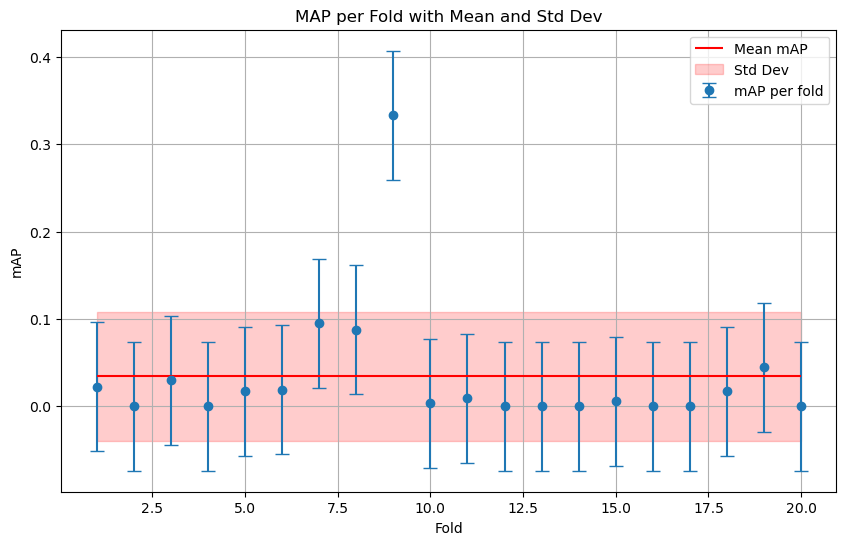

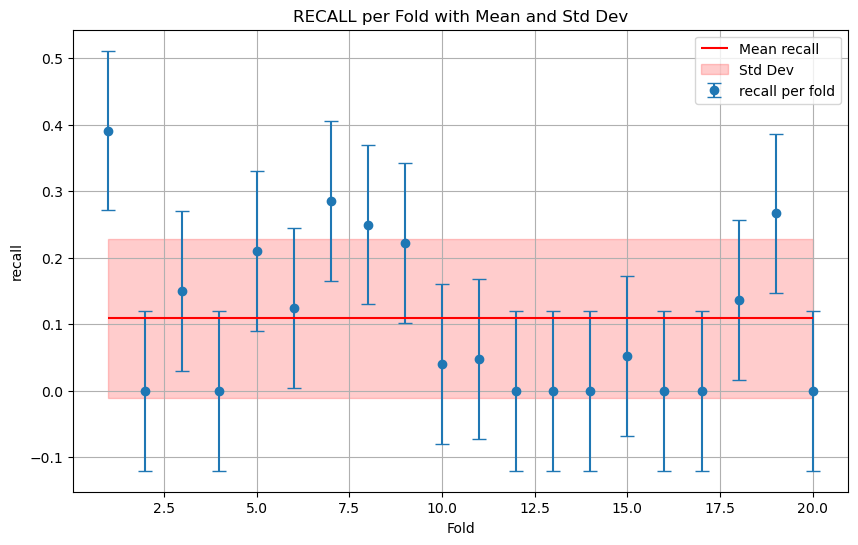

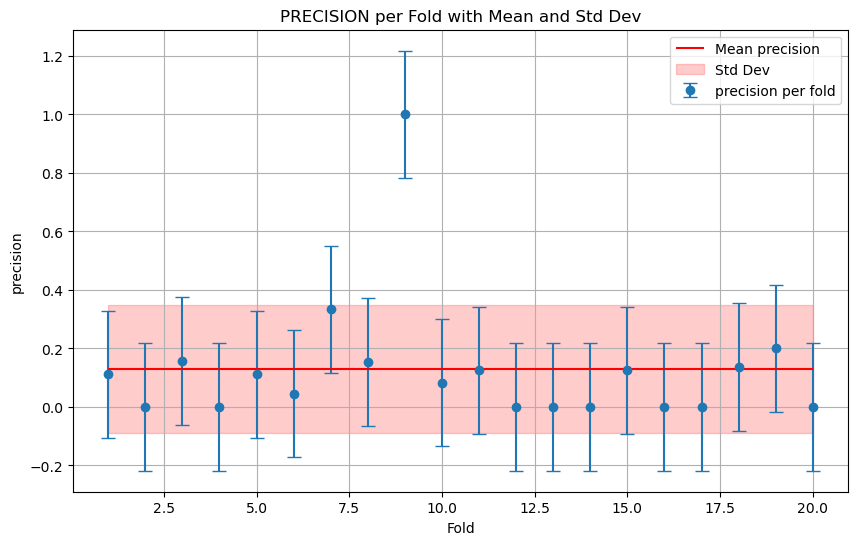

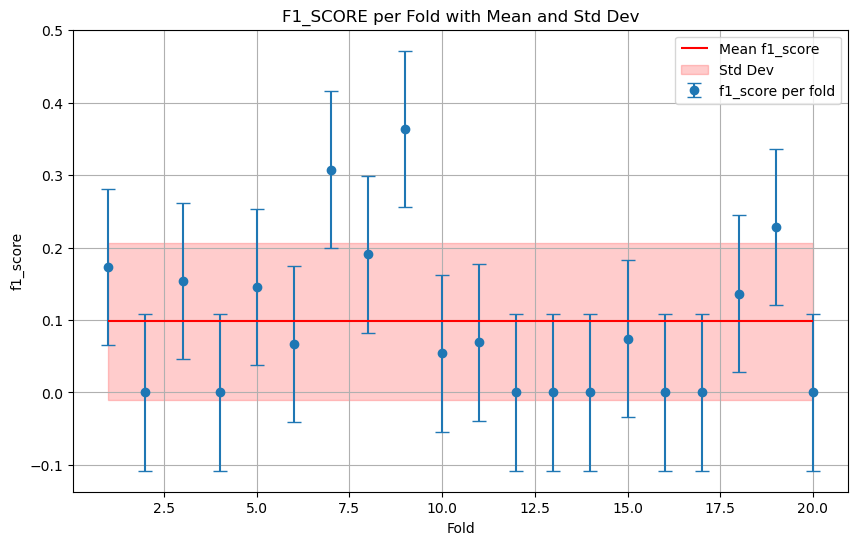

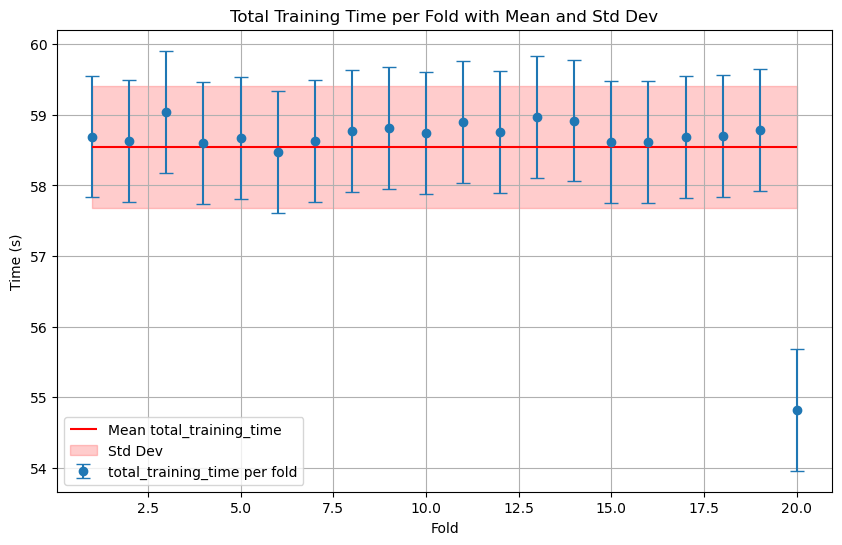

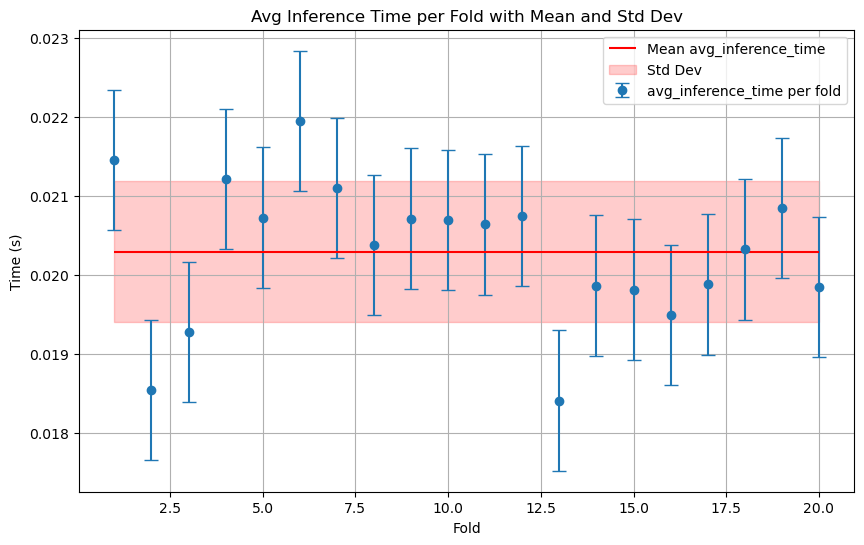

In [22]:
metrics_per_fold = process_all_folds(faster_r_cnn_predictions)
metrics_summary = compute_mean_and_variance(metrics_per_fold)

# Output the metrics
print("FASTER R CNN")
print('--------------------------------')
print("Mean and Variance of Metrics across all folds:\n")
print(f"mAP: Mean = {metrics_summary['mAP_mean']:.4f}, Variance = {metrics_summary['mAP_variance']:.4f}")
print(f"Recall: Mean = {metrics_summary['recall_mean']:.4f}, Variance = {metrics_summary['recall_variance']:.4f}")
print(f"Precision: Mean = {metrics_summary['precision_mean']:.4f}, Variance = {metrics_summary['precision_variance']:.4f}")
print(f"F1 Score: Mean = {metrics_summary['f1_score_mean']:.4f}, Variance = {metrics_summary['f1_score_variance']:.4f}")
print(f"Total Training Time: {metrics_summary['training_time_total']:.2f} seconds")
print(f"Average Training Time per Fold: Mean = {metrics_summary['training_time_mean']:.2f} s, Variance = {metrics_summary['training_time_variance']:.2f}")
print(f"Average Inference Time per Fold: Mean = {metrics_summary['inference_time_mean']:.6f} s, Variance = {metrics_summary['inference_time_variance']:.6f}")

# Metrics to plot
metrics_to_plot = ['mAP', 'recall', 'precision', 'f1_score']


for metric in metrics_to_plot:
    plot_metric_with_error_bars(metrics_per_fold, metric)

plot_time_metric_with_error_bars(metrics_per_fold, 'total_training_time')
plot_time_metric_with_error_bars(metrics_per_fold, 'avg_inference_time')


#### STN + Faster RCNN Metrics

In [ ]:
file_path = 'all_fold_data_faster_rcnn.pkl'

pickle_file_path = os.path.join(base_path, file_path)
if os.path.exists(pickle_file_path):
    with open(pickle_file_path, 'rb') as file:
        data_dict = pickle.load(file)
    print(f"Loaded data type: {type(data_dict)}")
else:
    print("Pickle file not found. Please check the file path.")

In [ ]:
metrics_per_fold = process_all_folds(data_dict)
metrics_summary = compute_mean_and_variance(metrics_per_fold)

# Output the metrics
print("STN FASTER R CNN")
print('--------------------------------')
print("Mean and Variance of Metrics across all folds:\n")
print(f"mAP: Mean = {metrics_summary['mAP_mean']:.4f}, Variance = {metrics_summary['mAP_variance']:.4f}")
print(f"Recall: Mean = {metrics_summary['recall_mean']:.4f}, Variance = {metrics_summary['recall_variance']:.4f}")
print(f"Precision: Mean = {metrics_summary['precision_mean']:.4f}, Variance = {metrics_summary['precision_variance']:.4f}")
print(f"F1 Score: Mean = {metrics_summary['f1_score_mean']:.4f}, Variance = {metrics_summary['f1_score_variance']:.4f}")
print(f"Total Training Time: {metrics_summary['training_time_total']:.2f} seconds")
print(f"Average Training Time per Fold: Mean = {metrics_summary['training_time_mean']:.2f} s, Variance = {metrics_summary['training_time_variance']:.2f}")
print(f"Average Inference Time per Fold: Mean = {metrics_summary['inference_time_mean']:.6f} s, Variance = {metrics_summary['inference_time_variance']:.6f}")

# Metrics to plot
metrics_to_plot = ['mAP', 'recall', 'precision', 'f1_score']


for metric in metrics_to_plot:
    plot_metric_with_error_bars(metrics_per_fold, metric)

plot_time_metric_with_error_bars(metrics_per_fold, 'total_training_time')
plot_time_metric_with_error_bars(metrics_per_fold, 'avg_inference_time')


#### RFB Metrics

In [ ]:
metrics_per_fold = process_all_folds()
metrics_summary = compute_mean_and_variance(metrics_per_fold)

# Output the metrics
print("RFB Metrics")
print('--------------------------------')
print("Mean and Variance of Metrics across all folds:\n")
print(f"mAP: Mean = {metrics_summary['mAP_mean']:.4f}, Variance = {metrics_summary['mAP_variance']:.4f}")
print(f"Recall: Mean = {metrics_summary['recall_mean']:.4f}, Variance = {metrics_summary['recall_variance']:.4f}")
print(f"Precision: Mean = {metrics_summary['precision_mean']:.4f}, Variance = {metrics_summary['precision_variance']:.4f}")
print(f"F1 Score: Mean = {metrics_summary['f1_score_mean']:.4f}, Variance = {metrics_summary['f1_score_variance']:.4f}")
print(f"Total Training Time: {metrics_summary['training_time_total']:.2f} seconds")
print(f"Average Training Time per Fold: Mean = {metrics_summary['training_time_mean']:.2f} s, Variance = {metrics_summary['training_time_variance']:.2f}")
print(f"Average Inference Time per Fold: Mean = {metrics_summary['inference_time_mean']:.6f} s, Variance = {metrics_summary['inference_time_variance']:.6f}")

# Metrics to plot
metrics_to_plot = ['mAP', 'recall', 'precision', 'f1_score']


for metric in metrics_to_plot:
    plot_metric_with_error_bars(metrics_per_fold, metric)

plot_time_metric_with_error_bars(metrics_per_fold, 'total_training_time')
plot_time_metric_with_error_bars(metrics_per_fold, 'avg_inference_time')

## Stratified Nested K-fold for Hypertuning Parameters

In [166]:
def stratified_k_fold_split(dataset, num_folds, seed=55):
    """
    Splits the dataset into stratified folds.

    Parameters:
    - dataset: The dataset to split.
    - num_folds: Number of folds.
    - seed: Random seed for reproducibility.

    Returns:
    - folds: A list of lists, where each inner list contains indices for one fold.
    """
    # Get labels for all samples
    labels_list = []
    for idx in range(len(dataset)):
        # Assuming dataset[idx] returns (image, boxes, labels)
        labels = dataset[idx][2].numpy()
        labels_list.append(labels)

    # Flatten labels and count class occurrences
    class_counts = defaultdict(int)
    for labels in labels_list:
        unique_labels = set(labels.tolist())  # Convert numpy array to list for set operation
        for label in unique_labels:
            class_counts[label] += 1

    # Initialize folds
    folds = [[] for _ in range(num_folds)]
    label_folds = {label: [[] for _ in range(num_folds)] for label in class_counts.keys()}

    # Distribute samples to folds
    random.seed(seed)
    for label in class_counts.keys():
        # Get all indices with this label
        indices_with_label = [idx for idx, labels in enumerate(labels_list) if label in labels]
        random.shuffle(indices_with_label)
        fold_sizes = [len(indices_with_label) // num_folds] * num_folds
        for i in range(len(indices_with_label) % num_folds):
            fold_sizes[i] += 1
        start = 0
        for fold_idx, fold_size in enumerate(fold_sizes):
            end = start + fold_size
            label_folds[label][fold_idx].extend(indices_with_label[start:end])
            start = end

    # Initialize a set to keep track of assigned indices
    assigned_indices = set()

    # Combine folds from all labels
    for fold_idx in range(num_folds):
        fold_indices = []
        for label in class_counts.keys():
            # Only add indices that haven't been assigned yet
            label_indices = [idx for idx in label_folds[label][fold_idx] if idx not in assigned_indices]
            fold_indices.extend(label_indices)
            assigned_indices.update(label_indices)
        random.shuffle(fold_indices)
        folds[fold_idx] = fold_indices

    return folds



In [167]:
### FASTER RCNN

def nested_cross_validate_model(model_name, dataset, num_outer_folds=5, num_inner_folds=3, num_epochs=5, **kwargs):
    """
    Performs Nested Stratified K-Fold Cross-Validation with hyperparameter tuning.

    Parameters:
    - model_name (str): Name of the model ('faster_rcnn').
    - dataset (torch.utils.data.Dataset): The dataset to perform cross-validation on.
    - num_outer_folds (int): Number of outer folds for cross-validation.
    - num_inner_folds (int): Number of inner folds for hyperparameter tuning.
    - num_epochs (int): Number of epochs to train in each fold.
    - kwargs: Additional parameters.

    Returns:
    - None
    """
    # Extract the parameters from kwargs
    device = kwargs.get('device')
    batch_size = kwargs.get('batch_size', 10)
    # Mapping class indices to class names
    class_mapping = {0: 'gun', 1: 'knife', 2: 'plier', 3: 'scissor', 4: 'wrench'}
    num_classes = len(class_mapping) + 1  # +1 for background
    best_overall_recall = -1

    # Prepare class weights tensor
    class_weights = {'gun': 0.065648621975652,
                     'knife': 0.35833206161710135,
                     'plier': 0.04574451850431081,
                     'scissor': 0.3739117164700188,
                     'wrench': 0.15636308143291694}

    class_weights_tensor = torch.ones(num_classes)  # Initialize with ones for all classes including background

    # Map class indices to weights
    for class_index, class_name in class_mapping.items():
        class_weight = class_weights[class_name]
        class_weights_tensor[class_index] = class_weight

    class_weights_tensor = class_weights_tensor.to(device)

    # Outer Stratified K-Fold Split
    outer_folds = stratified_k_fold_split(dataset, num_outer_folds)

    # To store metrics across folds
    outer_fold_metrics = []

    for outer_fold_idx in range(num_outer_folds):
        print(f"\nOuter Fold {outer_fold_idx + 1}/{num_outer_folds}")
        # Split data for outer fold
        val_indices = outer_folds[outer_fold_idx]
        train_val_indices = [idx for i, fold in enumerate(outer_folds) if i != outer_fold_idx for idx in fold]
        train_val_subset = Subset(dataset, train_val_indices)
        val_subset = Subset(dataset, val_indices)

        # Inner Stratified K-Fold for Hyperparameter Tuning
        inner_folds = stratified_k_fold_split(train_val_subset, num_inner_folds)
        best_hyperparams = None
        best_mAP = -1

        # Access the hyperparameter space from kwargs
        hyperparameter_space = kwargs.get('hyperparameter_space')

        hyperparameter_combinations = [
            {
                'anchor_sizes': anchor_sizes,
                'aspect_ratios': aspect_ratios,
                'rpn_nms_thresh': rpn_nms_thresh
            }
            for anchor_sizes in hyperparameter_space['anchor_sizes']
            for aspect_ratios in hyperparameter_space['aspect_ratios']
            for rpn_nms_thresh in hyperparameter_space['rpn_nms_thresh']
        ]

        for hyperparams in hyperparameter_combinations:
            print(f"\nTesting hyperparameters: {hyperparams}")
            inner_fold_maps = []

            for inner_fold_idx in range(num_inner_folds):
                # Split data for inner fold
                print(f"\nInner Fold {inner_fold_idx + 1}/{num_inner_folds}")
                inner_val_indices = inner_folds[inner_fold_idx]
                inner_train_indices = [idx for i, fold in enumerate(inner_folds) if i != inner_fold_idx for idx in fold]
                inner_train_subset = Subset(train_val_subset, inner_train_indices)
                inner_val_subset = Subset(train_val_subset, inner_val_indices)

                # Create DataLoaders
                train_loader = DataLoader(inner_train_subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
                val_loader = DataLoader(inner_val_subset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

                # Create model
                try:
                    model = create_model_frcnn(num_classes=num_classes, **hyperparams)
                    model.to(device)

                    # Define optimizer and scheduler
                    params = [p for p in model.parameters() if p.requires_grad]
                    optimizer = optim.SGD(
                        params,
                        lr=0.005,  # Default value if not passed
                        momentum=0.9,
                        weight_decay=0.0005
                    )
                    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

                    # Train model
                    trained_model, _, _, total_training_time, best_model_state = train_model_frcnn(
                        model, train_loader, val_loader, optimizer, scheduler, num_epochs, class_weights_tensor,
                        fold_idx=inner_fold_idx, device=device
                    )

                    # Load best model state
                    trained_model.load_state_dict(best_model_state)

                    print(f"Calculating Predictions for best model in innerfold {inner_fold_idx + 1}, hyperparameter combo {hyperparams}")

                    # Collect predictions and ground truths
                    fold_predictions, fold_ground_truths, avg_inference_time = collect_predictions_and_ground_truths_with_speed(
                        trained_model, val_loader, device
                    )

                    # Calculate mAP
                    mAP = calculate_map(fold_predictions, fold_ground_truths, iou_threshold=0.5, num_classes=num_classes-1)
                    inner_fold_maps.append(mAP)

                    # Clean up
                    del model, trained_model, optimizer, scheduler
                    torch.cuda.empty_cache()
                    gc.collect()

                except Exception as e:
                    print(f"Error with hyperparameters {hyperparams}: {e}")
                    continue

            # Average mAP across inner folds
            avg_mAP = np.mean(inner_fold_maps) if inner_fold_maps else -1
            print(f"Average mAP for hyperparameters {hyperparams}: {avg_mAP}")

            # Update best hyperparameters
            if avg_mAP > best_mAP:
                best_mAP = avg_mAP
                best_hyperparams = hyperparams

        print(f"\nBest hyperparameters for Outer Fold {outer_fold_idx + 1}: {best_hyperparams} with mAP: {best_mAP}")

        # Train on full training data with best hyperparameters
        train_loader = DataLoader(train_val_subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

        # Create model with best hyperparameters
        model = create_model_frcnn(num_classes=num_classes, **best_hyperparams)
        model.to(device)

        # Define optimizer and scheduler
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.SGD(
            params,
            lr=0.005,
            momentum=0.9,
            weight_decay=0.0005
        )
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        # Train model
        trained_model, best_fold_val_loss, best_epoch, total_training_time, best_model_state = train_model_frcnn(
            model, train_loader, val_loader, optimizer, scheduler, num_epochs, class_weights_tensor,
            fold_idx=outer_fold_idx, device=device
        )

        # Load best model state
        trained_model.load_state_dict(best_model_state)

        print(f"Calculating Predictions for best model in outerfold {outer_fold_idx + 1}")

        # Collect predictions and ground truths
        fold_predictions, fold_ground_truths, avg_inference_time = collect_predictions_and_ground_truths_with_speed(
            trained_model, val_loader, device
        )

        # Calculate Recall@IoU
        recall = calculate_recall(fold_predictions, fold_ground_truths, iou_threshold=0.5)

        # Store metrics
        fold_metrics = {
            'fold_index': outer_fold_idx + 1,
            'best_hyperparameters': best_hyperparams,
            'validation_loss': best_fold_val_loss,
            'best_epoch': best_epoch,
            'total_training_time': total_training_time,
            'avg_inference_time': avg_inference_time,
            'recall_at_iou': recall
        }
        outer_fold_metrics.append(fold_metrics)

        print(f"Fold {outer_fold_idx + 1} Recall@IoU=0.5: {recall}")

        # Check if current recall is better than the best overall recall
        if recall > best_overall_recall:
            best_overall_recall = recall
            best_overall_model_state = copy.deepcopy(best_model_state)
            best_overall_fold = outer_fold_idx + 1
            best_overall_hyperparams = best_hyperparams
            print(f"New best overall model found at Fold {best_overall_fold} with Recall@IoU=0.5: {best_overall_recall}")


        # Clean up
        del model, trained_model, optimizer, scheduler
        torch.cuda.empty_cache()
        gc.collect()

    # Aggregate final results
    recalls = [metrics['recall_at_iou'] for metrics in outer_fold_metrics]
    mean_recall = np.mean(recalls)
    std_recall = np.std(recalls)

    print("\nFinal Results:")
    print(f"Mean Recall@IoU=0.5 across folds: {mean_recall}")
    print(f"Recall Standard Deviation: {std_recall}")

    # Save the best overall model to disk
    if best_overall_model_state is not None:
        model_save_path = f'best_overall_model_fold_{best_overall_fold}.pth'
        torch.save(best_overall_model_state, model_save_path)
        print(f"\nBest overall model saved at {model_save_path} with Recall@IoU=0.5: {best_overall_recall}")
        print(f"Best hyperparameters: {best_overall_hyperparams}")

In [ ]:
### STN FASTER RCNN

def nested_cross_validate_model_stn_frcnn(model_name, dataset, num_outer_folds=5, num_inner_folds=3, num_epochs=5, **kwargs):
    """
    Performs Nested Stratified K-Fold Cross-Validation with hyperparameter tuning.

    Parameters:
    - model_name (str): Name of the model ('faster_rcnn').
    - dataset (torch.utils.data.Dataset): The dataset to perform cross-validation on.
    - num_outer_folds (int): Number of outer folds for cross-validation.
    - num_inner_folds (int): Number of inner folds for hyperparameter tuning.
    - num_epochs (int): Number of epochs to train in each fold.
    - kwargs: Additional parameters.

    Returns:
    - None
    """
    # Extract the parameters from kwargs
    device = kwargs.get('device')
    batch_size = kwargs.get('batch_size', 10)
    # Mapping class indices to class names
    class_mapping = {0: 'gun', 1: 'knife', 2: 'plier', 3: 'scissor', 4: 'wrench'}
    num_classes = len(class_mapping) + 1  # +1 for background

    # Prepare class weights tensor
    class_weights = {'gun': 0.1190057659742028,
                     'knife': 0.1961004103944656,
                     'plier': 0.08725201808509703,
                     'scissor': 0.43879561915616316,
                     'wrench': 0.15884618639007145}

    class_weights_tensor = torch.ones(num_classes)  # Initialize with ones for all classes including background

    # Map class indices to weights
    for class_index, class_name in class_mapping.items():
        class_weight = class_weights[class_name]
        class_weights_tensor[class_index] = class_weight

    class_weights_tensor = class_weights_tensor.to(device)

    # Outer Stratified K-Fold Split
    outer_folds = stratified_k_fold_split(dataset, num_outer_folds)

    # To store metrics across folds
    outer_fold_metrics = []

    for outer_fold_idx in range(num_outer_folds):
        print(f"\nOuter Fold {outer_fold_idx + 1}/{num_outer_folds}")
        # Split data for outer fold
        val_indices = outer_folds[outer_fold_idx]
        train_val_indices = [idx for i, fold in enumerate(outer_folds) if i != outer_fold_idx for idx in fold]
        train_val_subset = Subset(dataset, train_val_indices)
        val_subset = Subset(dataset, val_indices)

        # Inner Stratified K-Fold for Hyperparameter Tuning
        inner_folds = stratified_k_fold_split(train_val_subset, num_inner_folds)
        best_hyperparams = None
        best_mAP = -1

        # Access the hyperparameter space from kwargs
        hyperparameter_space = kwargs.get('hyperparameter_space')

        hyperparameter_combinations = [
            {
                'anchor_sizes': anchor_sizes,
            }
            for anchor_sizes in hyperparameter_space['anchor_sizes']
        ]

        for hyperparams in hyperparameter_combinations:
            print(f"\nTesting hyperparameters: {hyperparams}")
            inner_fold_maps = []

            for inner_fold_idx in range(num_inner_folds):
                # Split data for inner fold
                print(f"\nInner Fold {inner_fold_idx + 1}/{num_inner_folds}")
                inner_val_indices = inner_folds[inner_fold_idx]
                inner_train_indices = [idx for i, fold in enumerate(inner_folds) if i != inner_fold_idx for idx in fold]
                inner_train_subset = Subset(train_val_subset, inner_train_indices)
                inner_val_subset = Subset(train_val_subset, inner_val_indices)

                # Create DataLoaders
                train_loader = DataLoader(inner_train_subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
                val_loader = DataLoader(inner_val_subset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

                # Create model
                try:
                    model = create_model(num_classes=num_classes, aspect_ratios=aspect_ratios, rpn_nms_thresh=rpn_nms_thresh, backbone_name='resnet50', pretrained=True, stn_type=stn_type, **hyperparams)
                    model.to(device)

                    # Define optimizer and scheduler
                    params = [p for p in model.parameters() if p.requires_grad]
                    optimizer = optim.SGD(
                        params,
                        lr=0.005,  # Default value if not passed
                        momentum=0.9,
                        weight_decay=0.0005
                    )
                    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

                    # Train model
                    trained_model, _, _, total_training_time, best_model_state = train_model(
                        model, train_loader, val_loader, optimizer, scheduler, num_epochs, class_weights_tensor,
                        fold_idx=inner_fold_idx, device=device
                    )

                    # Load best model state
                    trained_model.load_state_dict(best_model_state)

                    print(f"Calculating Predictions for best model in innerfold {inner_fold_idx + 1}, hyperparameter combo {hyperparams}")

                    # Collect predictions and ground truths
                    fold_predictions, fold_ground_truths, avg_inference_time = collect_predictions_and_ground_truths_with_speed(
                        trained_model, val_loader, device
                    )

                    # Calculate mAP
                    mAP = calculate_map(fold_predictions, fold_ground_truths, iou_threshold=0.5, num_classes=num_classes-1)
                    inner_fold_maps.append(mAP)

                    # Clean up
                    del model, trained_model, optimizer, scheduler
                    torch.cuda.empty_cache()
                    gc.collect()

                except Exception as e:
                    print(f"Error with hyperparameters {hyperparams}: {e}")
                    continue

            # Average mAP across inner folds
            avg_mAP = np.mean(inner_fold_maps) if inner_fold_maps else -1
            print(f"Average mAP for hyperparameters {hyperparams}: {avg_mAP}")

            # Update best hyperparameters
            if avg_mAP > best_mAP:
                best_mAP = avg_mAP
                best_hyperparams = hyperparams

        print(f"\nBest hyperparameters for Outer Fold {outer_fold_idx + 1}: {best_hyperparams} with mAP: {best_mAP}")

        # Train on full training data with best hyperparameters
        train_loader = DataLoader(train_val_subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

        # Create model with best hyperparameters
        model = create_model(num_classes=num_classes, aspect_ratios=aspect_ratios, rpn_nms_thresh=rpn_nms_thresh, backbone_name='resnet50', pretrained=True, stn_type=stn_type,**best_hyperparams)
        model.to(device)

        # Define optimizer and scheduler
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.SGD(
            params,
            lr=0.005,
            momentum=0.9,
            weight_decay=0.0005
        )
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        # Train model
        trained_model, best_fold_val_loss, best_epoch, total_training_time, best_model_state = train_model(
            model, train_loader, val_loader, optimizer, scheduler, num_epochs, class_weights_tensor,
            fold_idx=outer_fold_idx, device=device
        )

        # Load best model state
        trained_model.load_state_dict(best_model_state)

        print(f"Calculating Predictions for best model in outerfold {outer_fold_idx + 1}")

        # Collect predictions and ground truths
        fold_predictions, fold_ground_truths, avg_inference_time = collect_predictions_and_ground_truths_with_speed(
            trained_model, val_loader, device
        )

        # Calculate Recall@IoU
        recall = calculate_recall(fold_predictions, fold_ground_truths, iou_threshold=0.5)

        # Store metrics
        fold_metrics = {
            'fold_index': outer_fold_idx + 1,
            'best_hyperparameters': best_hyperparams,
            'validation_loss': best_fold_val_loss,
            'best_epoch': best_epoch,
            'total_training_time': total_training_time,
            'avg_inference_time': avg_inference_time,
            'recall_at_iou': recall
        }
        outer_fold_metrics.append(fold_metrics)

        print(f"Fold {outer_fold_idx + 1} Recall@IoU=0.5: {recall}")

        # Check if current recall is better than the best overall recall
        if recall > best_overall_recall:
            best_overall_recall = recall
            best_overall_model_state = copy.deepcopy(best_model_state)
            best_overall_fold = outer_fold_idx + 1
            best_overall_hyperparams = best_hyperparams
            print(f"New best overall model found at Fold {best_overall_fold} with Recall@IoU=0.5: {best_overall_recall}")


        # Clean up
        del model, trained_model, optimizer, scheduler
        torch.cuda.empty_cache()
        gc.collect()

    # Aggregate final results
    recalls = [metrics['recall_at_iou'] for metrics in outer_fold_metrics]
    mean_recall = np.mean(recalls)
    std_recall = np.std(recalls)

    print("\nFinal Results:")
    print(f"Mean Recall@IoU=0.5 across folds: {mean_recall}")
    print(f"Recall Standard Deviation: {std_recall}")

    # Save the best overall model to disk
    if best_overall_model_state is not None:
        model_save_path = f'best_overall_model_fold_{best_overall_fold}.pth'
        torch.save(best_overall_model_state, model_save_path)
        print(f"\nBest overall model saved at {model_save_path} with Recall@IoU=0.5: {best_overall_recall}")
        print(f"Best hyperparameters: {best_overall_hyperparams}")


In [ ]:
### RFBNEt











### Training models through Stratified Nested k-fold algorithm (HP Tuning)

In [ ]:
# Stratified k-fold Cross-validation parameters
num_folds = 20
num_epochs = 7
batch_size = 10

# 20-fold Cross-validation parameters (Faster RCNN+STN)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA GPU available, using the GPU")
else:
    device = torch.device("cpu")
    print("No GPU available, using the CPU")


In [ ]:
## TRAIN FASTER RCNN

# Define hyperparameter for Faster RCNN search space
hyperparameter_space = {
    'anchor_sizes': [
        ((32, 64, 128),),  # Small-to-medium objects
        ((64, 128, 256),)  # Medium-to-large objects
    ],
    'aspect_ratios': [
        ((0.5, 1.0, 2.0),),  # Standard aspect ratios
        ((1.0, 2.0),)        # Focused on more common aspect ratios
    ],
    'rpn_nms_thresh': [
        0.7,  # Higher threshold for less aggressive suppression
        0.5   # Lower threshold for more aggressive suppression, useful for crowded objects
    ]
}

nested_cross_validate_model(
    model_name='faster_rcnn',
    dataset=train_dataset,
    num_outer_folds=5,         # 5 outer folds
    num_inner_folds=2,         # 2 inner folds for tuning
    num_epochs=20,             # Up to 20 epochs with early stopping patience of 5
    device=device,
    batch_size=8,              # Optimal batch size for stability and efficiency
    hyperparameter_space=hyperparameter_space  # The reduced 2x2x2 grid search
)


In [ ]:
## TRAIN STN FASTER RCNN

#HP tuning Faster RCNN STN
# # Define hyperparameter for Faster RCNN  STN search space

hyperparameter_space = {
    'anchor_sizes': [
        ((32, 64, 128),), # flexibility in detecting small, medium, and somewhat large objects
        (64, 128, 256), # focses on medium to large objects

    ]

}

aspect_ratios = ((0.5, 1.0, 2.0),)
rpn_nms_thresh = 0.7
stn_type ='affine'

nested_cross_validate_model_stn_frcnn(
    model_name='stn_frcnn',
    dataset=train_dataset,
    num_outer_folds=5,
    num_inner_folds=3,
    num_epochs=10,
    device=device,
    batch_size=1,  # Adjust batch size based on your resources
    hyperparameter_space = hyperparameter_space,

)

In [ ]:
## TRAIN RFBNet






## Evaluating performance on Testing Set using the best hyper parameters.

### Preparing the TEST data

In [72]:
class XrayDataset(Dataset):
    def __init__(self, df_images, df_annotations):
        self.df_images = df_images
        self.df_annotations = df_annotations

    def __len__(self):
        return len(self.df_images)

    def __getitem__(self, idx):
        # Load image tensor (ensure it's a PyTorch tensor)
        image_tensor = self.df_images.iloc[idx]['normalized_tensor']
        if not isinstance(image_tensor, torch.Tensor):
            image_tensor = torch.tensor(image_tensor, dtype=torch.float32)

        # Get the filename for this image
        filename = self.df_images.iloc[idx]['filename']

        # Get bounding box and labels for the same image
        annotation = self.df_annotations[self.df_annotations['filename'] == filename]

        # Convert bounding box to torch tensors
        boxes = torch.tensor(annotation[['xmin', 'ymin', 'xmax', 'ymax']].values, dtype=torch.float32)

        # Convert one-hot encoded labels back to class indices
        one_hot_labels = annotation[['class_gun', 'class_knife', 'class_plier', 'class_scissor', 'class_wrench']].values
        labels = torch.tensor([label.argmax() for label in one_hot_labels], dtype=torch.int64)  # Integer labels

        # Retrieve weighted_ssq_occlusions for the image
        weighted_ssq = self.df_images.iloc[idx]['weighted_ssq_occlusions']

        return image_tensor, boxes, labels, weighted_ssq  # Include weighted_ssq in the return

# Custom collate function to handle varying number of bounding boxes and include weighted_ssq
def custom_collate_fn(batch):
    images = []
    targets = []  # Store dictionaries for boxes, labels, and weighted_ssq

    for item in batch:
        images.append(item[0])  # Image tensor

        # Store targets as a dictionary with 'boxes', 'labels', and 'weighted_ssq'
        targets.append({
            'boxes': item[1],   # Bounding boxes
            'labels': item[2],  # Class labels (integer encoded)
            'weighted_ssq': item[3]  # Weighted sum of squares for occlusion
        })

    # Stack images normally, since their sizes are uniform
    images = torch.stack(images, 0)

    # Return stacked images and list of dictionaries for boxes, labels, and weighted_ssq
    return images, targets

In [ ]:
# Add weighted_ssq values to `df_test_images` based on filename matching
# Drop the existing weighted_ssq_occlusions column if it exists in df_test_images before merging
if 'weighted_ssq_occlusions' in df_test_images.columns:
    df_test_images = df_test_images.drop(columns=['weighted_ssq_occlusions'])

# Merge the DataFrames to add the weighted_ssq_occlusions column from weighted_ssq_df
df_test_images = df_test_images.merge(weighted_ssq_df, on='filename', how='left')


# Initialize normalized_tensor column in df_test_images for processing
df_test_images['normalized_tensor'] = None

# Process the tensors in mini-batches to normalize
batch_size = 32
process_in_mini_batches(df_test_images, batch_size)

# Apply one-hot encoding to the 'class' column in df_test_annotations
# Apply one-hot encoding to the 'class' column in df_test_annotations if it exists
if 'class' in df_test_annotations.columns:
    df_test_annotations = pd.get_dummies(df_test_annotations, columns=['class'])
else:
    print("'class' column not found in df_test_annotations.")

# Clean up unnecessary columns for final DataLoader creation
df_test_images_cleaned = df_test_images.drop(columns=['tensor', 'height', 'width', 'mode'])
df_test_annotations_cleaned = df_test_annotations.drop(columns=['depth', 'height', 'width', 'pose', 'truncated', 'difficult'])

# Create a unified dataset and DataLoader for all occlusion levels
test_dataset = XrayDataset(df_test_images_cleaned, df_test_annotations_cleaned)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, collate_fn=custom_collate_fn)

In [ ]:
df_test_annotations_cleaned.head()

In [ ]:
df_test_images_cleaned.head()

In [ ]:
# Inspect the full raw structure of the first 2 records from the DataLoader, including weights
print("\nInspecting the full raw structure of the first 2 records from test_loader:")

# Iterate over the test_loader and print the raw data for the first batch
for images, targets in test_loader:
    # Print the full structure for the first 2 images in the batch
    for i in range(2):
        print(f"\nRecord {i + 1}:")
        print("Image Tensor:", images[i])  # Full tensor data for the image
        print("Image Tensor Shape:", images[i].shape)  # Shape of the image tensor
        print("Bounding Boxes:", targets[i]['boxes'])  # Full bounding boxes data
        print("Bounding Boxes Shape:", targets[i]['boxes'].shape)  # Shape of bounding boxes tensor
        print("Labels:", targets[i]['labels'])  # Full labels tensor
        print("Labels Shape:", targets[i]['labels'].shape)  # Shape of labels tensor
        print("Weighted SSQ Occlusion:", targets[i]['weighted_ssq'])  # Weighted occlusion value for each image
    break  # Stop after the first batch


### Testing Model

In [85]:
def collect_predictions_and_ground_truths(model, data_loader, device):
    """
    Collects predictions, ground truths, and weighted_ssq_occlusions from the model.
    
    Parameters:
    - model: The trained model.
    - data_loader: DataLoader for the dataset.
    - device: The device to run the model on.
    
    Returns:
    - all_predictions: List of prediction dictionaries.
    - all_ground_truths: List of ground truth dictionaries.
    - weighted_ssq_list: List of weighted_ssq_occlusions values.
    - images_list: List of images for visualization.
    """
    model.eval()
    all_predictions = []
    all_ground_truths = []
    weighted_ssq_list = []
    images_list = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for idx in range(len(images)):
                pred_boxes = outputs[idx]['boxes'].cpu().numpy()
                pred_scores = outputs[idx]['scores'].cpu().numpy()
                pred_labels = outputs[idx]['labels'].cpu().numpy()

                gt_boxes = targets[idx]['boxes'].cpu().numpy()
                gt_labels = targets[idx]['labels'].cpu().numpy()
                weighted_ssq = targets[idx]['weighted_ssq'].item()  # Assuming it's a scalar tensor

                all_predictions.append({
                    'boxes': pred_boxes,
                    'scores': pred_scores,
                    'labels': pred_labels
                })
                all_ground_truths.append({
                    'boxes': gt_boxes,
                    'labels': gt_labels
                })
                weighted_ssq_list.append(weighted_ssq)
                images_list.append(images[idx].cpu())  # For visualization

    return all_predictions, all_ground_truths, weighted_ssq_list, images_list


def compute_per_image_metrics(predictions, ground_truths, weighted_ssq_list, num_classes):
    """
    Computes per-image recall and mAP using existing functions.
    
    Parameters:
    - predictions: List of prediction dictionaries.
    - ground_truths: List of ground truth dictionaries.
    - weighted_ssq_list: List of weighted_ssq_occlusions values.
    - num_classes: Number of classes.
    
    Returns:
    - per_image_metrics: List of dictionaries with 'recall', 'mAP', 'weighted_ssq_occlusions'.
    """
    per_image_metrics = []

    for i in range(len(predictions)):
        pred = [predictions[i]]  # Single-image prediction list
        gt = [ground_truths[i]]  # Single-image ground truth list

        recall = calculate_recall(pred, gt, iou_threshold=0.5)
        mAP = calculate_map(pred, gt, iou_threshold=0.5, num_classes=num_classes)

        per_image_metrics.append({
            'recall': recall,
            'mAP': mAP,
            'weighted_ssq': weighted_ssq_list[i]
        })

    return per_image_metrics

def visualize_predictions_single_image(image, prediction, ground_truth, class_names, weighted_ssq):
    """
    Visualizes predictions and ground truths on a single image.
    
    Parameters:
    - image: Tensor image.
    - prediction: Dictionary containing 'boxes', 'labels', 'scores'.
    - ground_truth: Dictionary containing 'boxes', 'labels'.
    - class_names: List of class names.
    - weighted_ssq: Weighted SSQ occlusion value.
    """
    img = image
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)

    # Attempt to load Arial font; fall back to default if unavailable
    try:
        font = ImageFont.truetype("arial.ttf", size=16)
    except IOError:
        font = ImageFont.load_default()

    # Draw ground truth boxes with enhanced styling
    gt_boxes = ground_truth['boxes']
    gt_labels = ground_truth['labels']
    for box, label in zip(gt_boxes, gt_labels):
        draw.rectangle(box.tolist(), outline="lime", width=3)  # Bright green for GT boxes
        text_position = (box[0], box[1] - 20)
        draw.rectangle([text_position, (box[0] + 80, box[1])], fill=(0, 255, 0, 120))  # Semi-transparent green background
        draw.text(text_position, f"GT: {class_names[label]}", fill="black", font=font)

    # Draw predicted boxes with enhanced styling
    pred_boxes = prediction['boxes']
    pred_labels = prediction['labels']
    pred_scores = prediction['scores']
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        draw.rectangle(box.tolist(), outline="red", width=2)  # Red for predictions
        text_position = (box[0], box[1] - 20)
        draw.rectangle([text_position, (box[0] + 100, box[1])], fill=(255, 0, 0, 120))  # Semi-transparent red background
        draw.text(text_position, f"{class_names[label]}: {score:.2f}", fill="white", font=font)  # White text for contrast

    # Enhance contrast and display the image
    enhancer = ImageEnhance.Contrast(img)
    img_enhanced = enhancer.enhance(1.2)  # Slightly boost contrast
    plt.figure(figsize=(12, 8))
    plt.title(f"Weighted SSQ Occlusion: {weighted_ssq}")
    plt.imshow(img_enhanced)
    plt.axis('off')
    plt.show()

In [86]:
def test_model_with_weighted_ssq(model, data_loader, device, class_names, num_classes, visualization=True, num_images_to_visualize=3):
    model.to(device)
    predictions, ground_truths, weighted_ssq_list, images_list = collect_predictions_and_ground_truths(model, data_loader, device)

    # Compute per-image metrics using existing functions
    per_image_metrics = compute_per_image_metrics(predictions, ground_truths, weighted_ssq_list, num_classes)

    # Overall metrics
    overall_recall = np.mean([m['recall'] for m in per_image_metrics])
    overall_mAP = np.mean([m['mAP'] for m in per_image_metrics])

    print(f"Overall Recall: {overall_recall:.4f}, Overall mAP: {overall_mAP:.4f}")

    # Optional visualization
    if visualization:
        # Select random images to visualize
        total_images = len(images_list)
        num_images = min(num_images_to_visualize, total_images)
        random_indices = random.sample(range(total_images), num_images)
        images_to_visualize = [images_list[i] for i in random_indices]
        predictions_to_visualize = [predictions[i] for i in random_indices]
        ground_truths_to_visualize = [ground_truths[i] for i in random_indices]
        weighted_ssq_to_visualize = [weighted_ssq_list[i] for i in random_indices]

        for image, pred, gt, weighted_ssq in zip(images_to_visualize, predictions_to_visualize, ground_truths_to_visualize, weighted_ssq_to_visualize):
            # Visualize predictions and ground truths
            visualize_predictions_single_image(image, pred, gt, class_names, weighted_ssq)

    return per_image_metrics


In [87]:
def plot_metrics_vs_occlusion(per_image_metrics):
    """
    Plots recall and mAP against weighted_ssq_occlusions.

    Parameters:
    - per_image_metrics: List of dictionaries with 'recall', 'mAP', 'weighted_ssq_occlusions'.
    """

    # Extract metrics and occlusion values
    occlusion_values = [m['weighted_ssq'] for m in per_image_metrics]
    recall_values = [m['recall'] for m in per_image_metrics]
    mAP_values = [m['mAP'] for m in per_image_metrics]

    # Scatter plot for Recall
    plt.figure(figsize=(10, 6))
    plt.scatter(occlusion_values, recall_values, alpha=0.6, edgecolors='k')
    plt.title('Recall vs Weighted SSQ Occlusion')
    plt.xlabel('Weighted SSQ Occlusion')
    plt.ylabel('Recall')
    plt.grid(True)
    plt.show()

    # Scatter plot for mAP
    plt.figure(figsize=(10, 6))
    plt.scatter(occlusion_values, mAP_values, alpha=0.6, edgecolors='k', color='orange')
    plt.title('mAP vs Weighted SSQ Occlusion')
    plt.xlabel('Weighted SSQ Occlusion')
    plt.ylabel('mAP')
    plt.grid(True)
    plt.show()


### Calling the function for testing

In [ ]:
## TEST FASTER RCNN MODEL

# Number of classes (excluding background)
num_classes = 5  # As per your dataset

# Create class names list
class_names = ['gun', 'knife', 'plier', 'scissor', 'wrench']

# Create the model with specified hyperparameters
model = create_model_frcnn(
    num_classes=num_classes + 1,  # +1 for background
    anchor_sizes=((64, 128, 256),),
    aspect_ratios=((0.5, 1.0, 2.0),),
    rpn_nms_thresh=0.7,
    backbone_name='resnet50',
    pretrained=True
)

# Move model to device
model.to(device)

# Load the best-performing model weights
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.load_state_dict(torch.load('overall_best_model_fold_7_epoch_5.pth'))
    print("CUDA GPU available, using the GPU")
else:
    device = torch.device("cpu")
    model.load_state_dict(torch.load('overall_best_model_fold_7_epoch_5.pth', map_location=device))
    print("No GPU available, using the CPU")

# Test the model
per_image_metrics = test_model_with_weighted_ssq(
    model=model,
    data_loader=test_loader,  # Use your test_loader here
    device=device,
    class_names=class_names,
    num_classes=num_classes,
    visualization=True
)

# Generate graphs
plot_metrics_vs_occlusion(per_image_metrics)

In [ ]:
## TEST STN FASTER RCNN MODEL






